In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from models import Autoencoder
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils import translate_text
from sklearn.model_selection import KFold
import shap
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
from sklearn.model_selection import KFold
import torch.nn.functional as F
import io
from PIL import Image
from utils import get_cbcl_details
import random
import netron

In [2]:
seed = 8  
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_unrelated.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 1:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.2)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

In [5]:
from utils import get_cbcl_details
items = [get_cbcl_details(col) for col in qns.iloc[:, 1:].columns]
items = np.array(items)

## SAEIBS

In [226]:
import torch
import torch.nn as nn
import torch.nn.functional as F
def flatten(t):
    return [item for sublist in t for item in sublist]


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, cond_dropout, drop_rate, activation_fn=F.leaky_relu):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.cond_dropout = cond_dropout
        self.drop_rate = drop_rate
        self.activation_fn = activation_fn
        neurons = [input_dim, *hidden_dim, latent_dim]
        if cond_dropout:
            layers = flatten(
                [[nn.Linear(neurons[i - 1], neurons[i]), nn.Dropout(p=drop_rate)] for i in range(1, len(neurons))])
            self.hidden = nn.ModuleList(layers[:-1])
        else:
            linear_layers = [nn.Linear(neurons[i - 1], neurons[i]) for i in range(1, len(neurons))]
            self.hidden = nn.ModuleList(linear_layers)

    def forward(self, x):
        for layer in self.hidden:
            x = self.activation_fn(layer(x))
        return x


class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, cond_dropout, drop_rate, actFn, activation_fn=F.leaky_relu):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.cond_dropout = cond_dropout
        self.drop_rate = drop_rate
        self.actFn = actFn
        self.activation_fn = activation_fn
        neurons = [latent_dim, *reversed(hidden_dim)]
        if cond_dropout:
            layers = flatten(
                [[nn.Linear(neurons[i-1], neurons[i]), nn.Dropout(p=drop_rate)] for i in range(1, len(neurons))])
            self.hidden = nn.ModuleList(layers)
        else:
            linear_layers = [nn.Linear(neurons[i - 1], neurons[i]) for i in range(1, len(neurons))]
            self.hidden = nn.ModuleList(linear_layers)
        self.fc = nn.Linear(neurons[-1], input_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = self.activation_fn(layer(x))
        if self.actFn == 'sigmoid':
            x = torch.sigmoid(self.fc(x))  # last layer before output is sigmoid, transfer between 0 and 1
        elif self.actFn == 'tanh':
            x = torch.tanh(self.fc(x))
        elif self.actFn == 'leakyRelu':
            x = F.leaky_relu(self.fc(x))
        return x
class SAEIBS_CBCL(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, cond_dropout=False, drop_rate=0.1, actFn="leakyRelu"):
        super(SAEIBS_CBCL, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim, hidden_dim[:-1], hidden_dim[-1], cond_dropout, drop_rate)
        self.decoder = Decoder(input_dim, hidden_dim[:-1], hidden_dim[-1], cond_dropout, drop_rate, actFn)
        self.V = nn.Parameter(torch.empty(latent_dim, latent_dim))
        self.rank = latent_dim
        self.mean_emb = nn.Parameter(torch.empty(latent_dim,), requires_grad=False)

    def initialize_svd(self, x, ibs_all):
        # 假设 x 是 encoder 输出 (N, D)
        emb = torch.mm(ibs_all, x)
        self.mean_emb.data = torch.mean(emb, dim=0)
        _, _, V = torch.svd_lowrank(emb - self.mean_emb, self.rank)
        max_ind = torch.argmax(torch.abs(V), dim=0)
        colsign = torch.sign(V[max_ind, torch.arange(V.shape[1])])
        self.V.data = V * colsign

    def forward(self, x, ibs_all):
        x_enc = self.encoder(x)                       # 编码后的 CBCL latent 表征
        emb = torch.mm(ibs_all, x_enc)               # 加入结构（IBS）相似性
        self.mean_emb.data = torch.mean(emb, dim=0)  # 更新均值
        _, _, V = torch.svd_lowrank(emb - self.mean_emb, self.rank)
        max_ind = torch.argmax(torch.abs(V), dim=0)
        colsign = torch.sign(V[max_ind, torch.arange(V.shape[1])])
        self.V.data = V * colsign

        z = torch.matmul(emb - self.mean_emb, self.V)             # 主成分表示（结构引导 latent）
        x_hat = torch.matmul(z, self.V.T) + self.mean_emb         # 可选的重构编码
        x_recon = self.decoder(x_hat)                             # 重构 CBCL（用于训练）
        return x_recon, z, x_enc
    # def forward(self, x, ibs_all):
    #     x_enc = self.encoder(x)                       # 编码后的 CBCL latent 表征
    #     emb = torch.mm(ibs_all, x_enc)               # 加入结构（IBS）相似性
    #     self.mean_emb.data = torch.mean(emb, dim=0)  # 更新均值

    #     # SVD
    #     U, S, V = torch.svd_lowrank(emb - self.mean_emb, self.rank)
    #     max_ind = torch.argmax(torch.abs(V), dim=0)
    #     colsign = torch.sign(V[max_ind, torch.arange(V.shape[1])])
    #     self.V.data = V * colsign

    #     # 投影得到 z
    #     z = torch.matmul(emb - self.mean_emb, self.V)

    #     S_sqrt = torch.sqrt(S + 1e-8)  # 防止除以0
    #     z_white = z / S_sqrt

    #     # 结构重建（可选）
    #     x_hat = torch.matmul(z_white * S_sqrt, self.V.T) + self.mean_emb  # 还原前再乘回 S
    #     x_recon = self.decoder(x_hat)

    #     return x_recon, z_white, x_enc

In [227]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # shape: (N, 114)，归一化到 0~1
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)    # shape: (N, 114)，归一化到 0~1
ibs_train = np.corrcoef(X_train_tensor)                      # shape: (N, N)
ibs_train = torch.tensor(ibs_train, dtype=torch.float32)
ibs_val = np.corrcoef(X_val_tensor)                        # shape: (N, N)
ibs_val = torch.tensor(ibs_val, dtype=torch.float32)

In [228]:
model = SAEIBS_CBCL(
    input_dim=114,
    hidden_dim=[512, 128, 64],       # encoder 隐藏层
    latent_dim=5,              # 最终输出维度
    cond_dropout=True,
    drop_rate=0.25,
    actFn="sigmoid"
)

model.initialize_svd(model.encoder(X_train_tensor), ibs_train)

In [229]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)
loss_fn = nn.MSELoss()

# Early stopping 参数
patience = 50
best_val_loss = np.inf
counter = 0
best_model_state = None

for epoch in range(2000):
    # === Training ===
    model.train()
    optimizer.zero_grad()
    x_recon, z, _ = model(X_train_tensor, ibs_train)
    loss = loss_fn(x_recon, X_train_tensor)
    loss.backward()
    optimizer.step()

    # === Validation ===
    model.eval()
    with torch.no_grad():
        val_recon, _, _ = model(X_val_tensor, ibs_val)
        val_loss = loss_fn(val_recon, X_val_tensor)

    print(f"Epoch {epoch}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")

    # === Early Stopping Check ===
    if val_loss.item() < best_val_loss - 1e-4:  # 设置一个小阈值避免浮动过早触发
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best val_loss: {best_val_loss:.4f}")
            model.load_state_dict(best_model_state)
            break

    # === Learning Rate Scheduler Step ===
    scheduler.step()


Epoch 0: train_loss=1.2898, val_loss=1.1939
Epoch 1: train_loss=1.2081, val_loss=1.1705
Epoch 2: train_loss=1.1359, val_loss=1.1303
Epoch 3: train_loss=1.0626, val_loss=1.0787
Epoch 4: train_loss=1.0158, val_loss=1.0281
Epoch 5: train_loss=0.9980, val_loss=0.9894
Epoch 6: train_loss=0.9929, val_loss=0.9636
Epoch 7: train_loss=0.9906, val_loss=0.9466
Epoch 8: train_loss=0.9890, val_loss=0.9354
Epoch 9: train_loss=0.9868, val_loss=0.9272
Epoch 10: train_loss=0.9843, val_loss=0.9215
Epoch 11: train_loss=0.9821, val_loss=0.9170
Epoch 12: train_loss=0.9804, val_loss=0.9134
Epoch 13: train_loss=0.9792, val_loss=0.9104
Epoch 14: train_loss=0.9777, val_loss=0.9076
Epoch 15: train_loss=0.9760, val_loss=0.9050
Epoch 16: train_loss=0.9739, val_loss=0.9022
Epoch 17: train_loss=0.9716, val_loss=0.8996
Epoch 18: train_loss=0.9692, val_loss=0.8973
Epoch 19: train_loss=0.9661, val_loss=0.8951
Epoch 20: train_loss=0.9636, val_loss=0.8934
Epoch 21: train_loss=0.9603, val_loss=0.8921
Epoch 22: train_loss

In [230]:
model.eval()
with torch.no_grad():
    X_reconstruction, latent_factors, _ = model(X_train_tensor, ibs_train)  # z_cbcl 是 (N, latent_dim)，可用于后续脑数据分析

In [231]:
total_variance = np.var(X_train, axis=0).sum()
explained_variance_ratio_total = 1 - np.var(X_train - X_reconstruction.numpy(), axis=0).sum() / total_variance
explained_variance_ratio_total

0.14319942254369167

In [232]:
import torch.nn.functional as F

# 假设：
# X_train_tensor: 原始输入，shape (N, D)
# X_reconstruction: autoencoder 的输出，shape (N, D)

reconstruction_error = F.mse_loss(X_reconstruction, X_train_tensor).item()
print("整体重构误差（MSE）:", reconstruction_error)


整体重构误差（MSE）: 0.8744712471961975


In [ ]:
latent_factors = latent_factors.numpy()  # shape: (N, latent_dim)，结构引导的 latent 表征

reconstructed = X_reconstruction

# Calculate the variance of each latent factor
latent_variances = np.var(latent_factors, axis=0)

# Calculate the total variance of the original data
total_variance = np.var(X, axis=0).sum()

# Calculate the explained variance ratio for each latent factor
explained_variance_ratios = latent_variances / total_variance

# Print the explained variance ratio for each latent factor
# for i, ratio in enumerate(explained_variance_ratios):
#     print(f"Explained variance ratio of latent factor {i+1}: {ratio:.8f}")

# # Calculate reconstruction errors
# reconstruction_errors = torch.mean(
#     (torch.tensor(X, dtype=torch.float32) - reconstructed) ** 2,
#     dim=1,
# ).numpy()

# Calculate the variance contribution of the reconstructed data
reconstruction_variance = np.var(reconstructed.numpy(), axis=0).sum()

# Calculate the total explained variance ratio
explained_variance_ratio_total = reconstruction_variance / total_variance
# print(
#     f"Total explained variance ratio (by all factors): {explained_variance_ratio_total:.8f}"
# )

print(
latent_factors,
# reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
)

[[-2.221385    0.85006094 -0.33298108  0.10722663  0.08577972]
 [-0.26403117  1.2559017   0.3579997   0.16123578  0.288675  ]
 [ 3.423532   -0.90778095  0.06444078  0.5621183   0.04156527]
 ...
 [ 2.5797756   0.59770626  0.66591626 -0.48821616 -0.09311317]
 [ 0.6805698  -0.74570966 -0.34142977  0.18002735  0.18767928]
 [ 0.63863426 -0.17204693 -0.5452663  -0.1278531   0.05692906]] [0.45482346 0.02469036 0.00448085 0.00280989 0.00257592] 1.3013775215693133e-06


In [151]:
pd.DataFrame(latent_factors)

0          1         2         3         4
0    -1048.878174 -11.410047  0.021272 -0.304160  0.203579
1     -197.936935 -24.123974  0.314753  0.244320 -0.003997
2     1149.830200  11.857202  0.075384  0.186569  0.165067
3     -524.841980   4.859844  0.244336 -0.055156  0.064887
4     -718.051697  -2.145086 -0.551948 -0.053510  0.129550
...           ...        ...       ...       ...       ...
9059  1730.336304 -16.897045  0.143905 -0.200572 -0.056388
9060  1388.565430   6.150578  0.427918  0.043441  0.002000
9061   310.666321 -13.947257 -0.681915  0.036751 -0.308737
9062   796.219238  12.095035  0.141816  0.068373  0.127542
9063   479.921844   6.827872  0.246624 -0.207445  0.018462

[9064 rows x 5 columns]

In [141]:
# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)
# original_features = X if isinstance(X, np.ndarray) else X.values
original_features = (
    X_train if isinstance(X_train, np.ndarray) else X_train.values
)

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]
scaler = StandardScaler()
latent_factors_scaled = scaler.fit_transform(latent_factors)
loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(
    loadings, columns=[f"Latent_{j+1}" for j in range(n_latent_factors)]
)
# loadings_df.index = [f"Feature_{i+1}" for i in range(n_original_features)]
loadings_df.index = items

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）the loading matrix of the autoencoder
# print(loadings_df)

In [142]:
loadings_df

Latent_1  Latent_2  \
Acts too young for their age                        0.000126  0.003513   
Argues a lot Discute mucho                          0.000262  0.002691   
Fails to finish things they start                   0.000236  0.003236   
There is very little they enjoy                     0.000056  0.002170   
Bowel movements outside toilet Hace sus necesid...  0.000007  0.000274   
...                                                      ...       ...   
Wets the bed Se orina en la cama                    0.000025  0.000185   
Whining Se queja mucho                              0.000155  0.001631   
Wishes to be of opposite sex Desea ser del sexo...  0.000003  0.000083   
Withdrawn, doesn't get involved with others Se ...  0.000042  0.001375   
Worries Se preocupa mucho                           0.000163 -0.002544   

                                                    Latent_3  Latent_4  \
Acts too young for their age                       -0.002019  0.015752   
Argues a lot Discute mucho                          0.014110 -0.042797   
Fails to finish things they start                  -0.000619  0.027685   
There is very little they enjoy                    -0.000968  0.001763   
Bowel movements outside toilet Hace sus necesid... -0.000215  0.000361   
...                                                      ...       ...   
Wets the bed Se orina en la cama                    0.001483  0.003647   
Whining Se queja mucho                             -0.002516 -0.027743   
Wishes to be of opposite sex Desea ser del sexo... -0.000458 -0.000010   
Withdrawn, doesn't get involved with others Se ... -0.004502  0.002130   
Worries Se preocupa mucho                          -0.032477 -0.021716   

                                                    Latent_5  
Acts too young for their age                       -0.023457  
Argues a lot Discute mucho                          0.034431  
Fails to finish things they start                   0.008672  
There is very little they enjoy                    -0.012012  
Bowel movements outside toilet Hace sus necesid...  0.001104  
...                                                      ...  
Wets the bed Se orina en la cama                    0.024523  
Whining Se queja mucho                              0.005849  
Wishes to be of opposite sex Desea ser del sexo... -0.000967  
Withdrawn, doesn't get involved with others Se ... -0.008455  
Worries Se preocupa mucho                          -0.023883  

[114 rows x 5 columns]

In [101]:
import pandas as pd

# 假设 loadings_df 是一个 DataFrame，行是特征，列名是 Latent_1 到 Latent_8
latent_order = ['Latent_8', 'Latent_7', 'Latent_6', 'Latent_5', 'Latent_4', 'Latent_3', 'Latent_2', 'Latent_1']
sorted_features = []

for i, latent in enumerate(latent_order):
    if i < 7:
        top_k = 3
    else:
        top_k = loadings_df.shape[0] - len(sorted_features)  # 剩余的9个
    
    sorted_block = loadings_df.loc[~loadings_df.index.isin(sorted_features)] \
                              .assign(abs_loading=loadings_df[latent].abs()) \
                              .sort_values(by='abs_loading', ascending=False) \
                              .head(top_k).index.tolist()
    
    sorted_features.extend(sorted_block)

# 如果你想要排序后的 loadings_df
sorted_loadings_df = loadings_df.loc[sorted_features]
sorted_loadings_df

KeyError: 'Latent_8'

In [143]:
# 根据 Latent_8 的绝对值排序（从大到小）
loadings_df = loadings_df.reindex(
    loadings_df['Latent_1'].abs().sort_values(ascending=False).index
)
loadings_df

Latent_1  Latent_2  \
Inattentive or easily distracted No presta aten...  0.000296  0.005183   
Can't concentrate, can't pay attention for long...  0.000265  0.005945   
Argues a lot Discute mucho                          0.000262  0.002691   
Fails to finish things they start                   0.000236  0.003236   
Can't sit still, restless, or hyperactive No pu...  0.000228  0.005681   
...                                                      ...       ...   
Plays with own sex parts in public Se toca/jueg...  0.000005  0.000204   
Runs away from home Se fuga de la casa              0.000005  0.000186   
Sets fires Prende fuegos/inicia incendios           0.000004  0.000193   
Wishes to be of opposite sex Desea ser del sexo...  0.000003  0.000083   
Thumb-sucking Se chupa el dedo                      0.000001  0.000161   

                                                    Latent_3  Latent_4  \
Inattentive or easily distracted No presta aten... -0.002613  0.040710   
Can't concentrate, can't pay attention for long... -0.000269  0.053744   
Argues a lot Discute mucho                          0.014110 -0.042797   
Fails to finish things they start                  -0.000619  0.027685   
Can't sit still, restless, or hyperactive No pu...  0.007579  0.038828   
...                                                      ...       ...   
Plays with own sex parts in public Se toca/jueg...  0.000024  0.000197   
Runs away from home Se fuga de la casa              0.000011 -0.000134   
Sets fires Prende fuegos/inicia incendios           0.000316  0.000188   
Wishes to be of opposite sex Desea ser del sexo... -0.000458 -0.000010   
Thumb-sucking Se chupa el dedo                      0.000352  0.001480   

                                                    Latent_5  
Inattentive or easily distracted No presta aten...  0.038647  
Can't concentrate, can't pay attention for long...  0.029521  
Argues a lot Discute mucho                          0.034431  
Fails to finish things they start                   0.008672  
Can't sit still, restless, or hyperactive No pu...  0.003919  
...                                                      ...  
Plays with own sex parts in public Se toca/jueg... -0.001483  
Runs away from home Se fuga de la casa             -0.001128  
Sets fires Prende fuegos/inicia incendios          -0.001247  
Wishes to be of opposite sex Desea ser del sexo... -0.000967  
Thumb-sucking Se chupa el dedo                     -0.001303  

[114 rows x 5 columns]

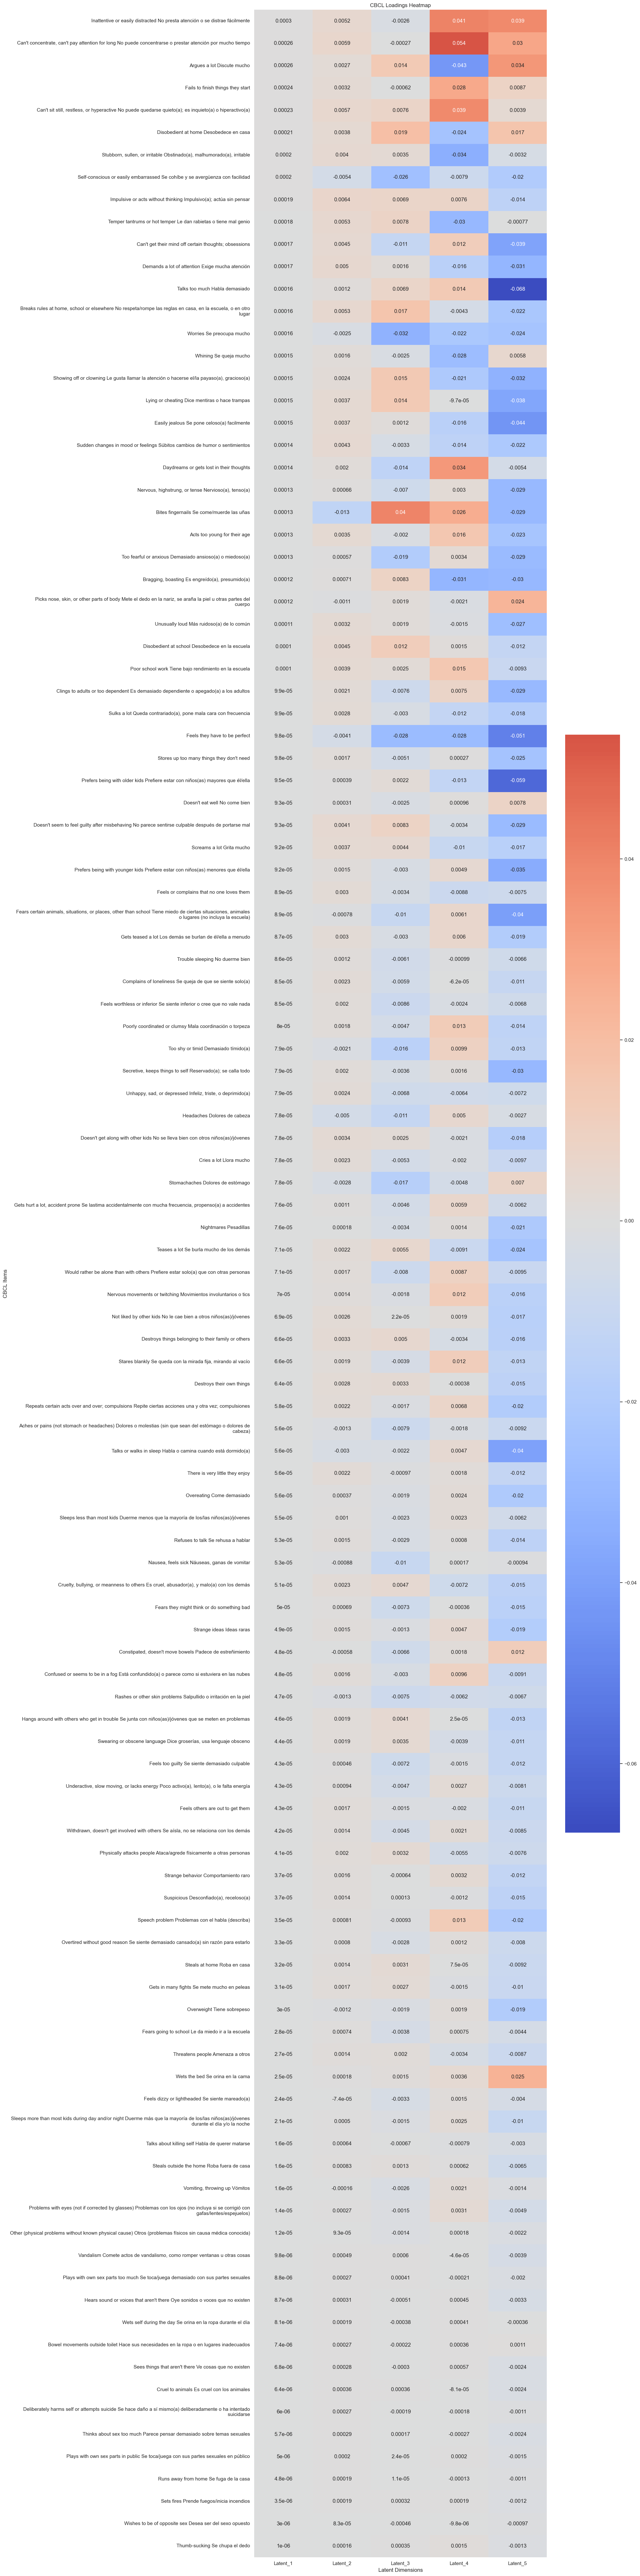

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 80))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("CBCL Loadings Heatmap")
plt.xlabel("Latent Dimensions")
plt.ylabel("CBCL Items")
plt.tight_layout()
plt.show()


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2620\1963253360.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


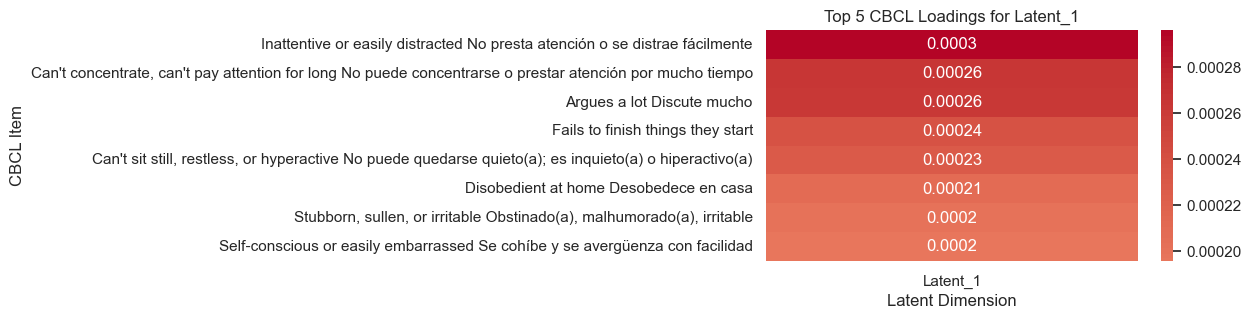

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2620\1963253360.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


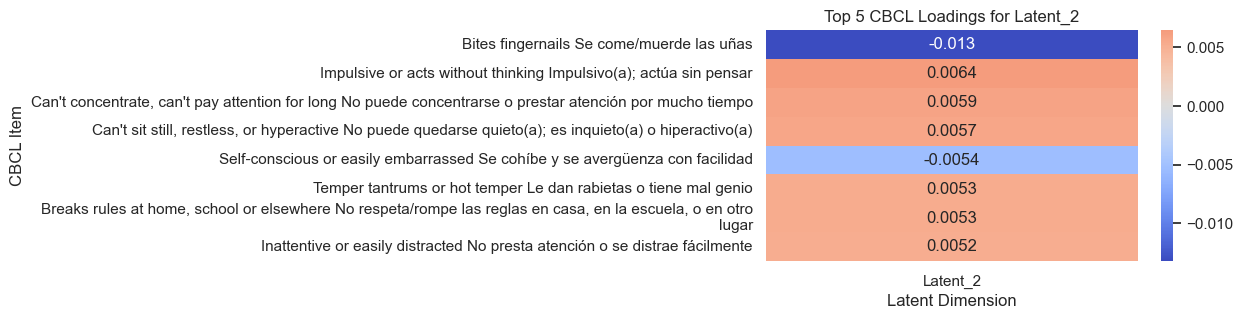

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2620\1963253360.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


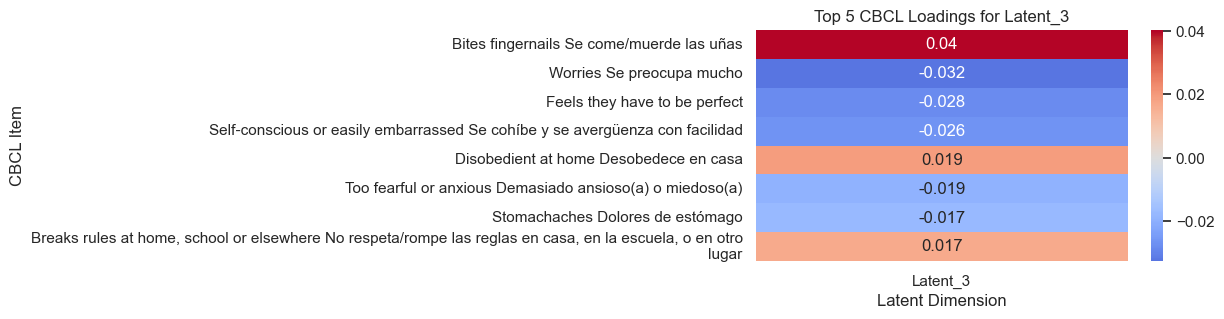

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2620\1963253360.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


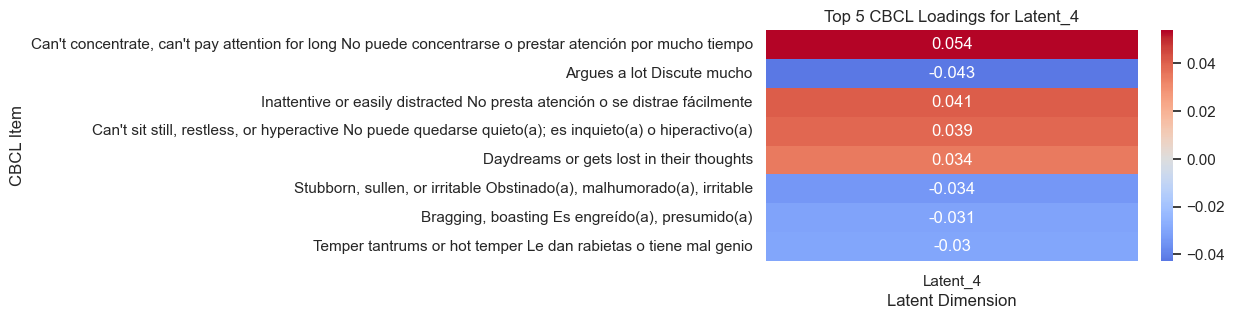

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2620\1963253360.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


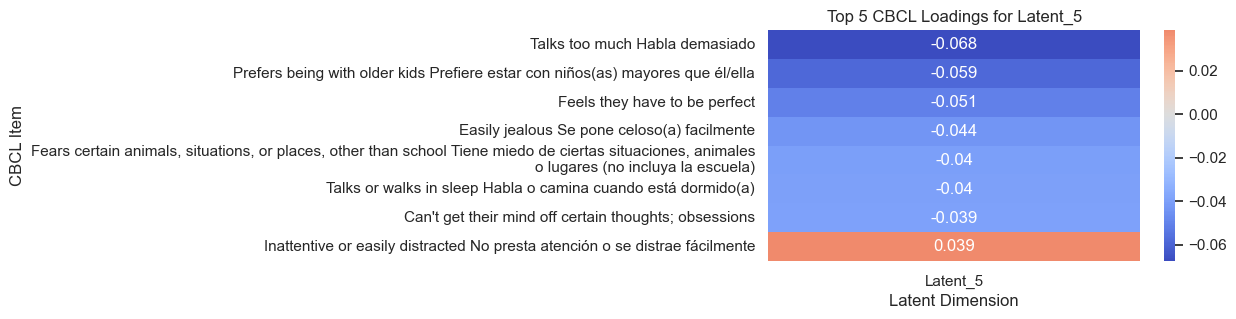

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set(style='whitegrid')

# 遍历每一列（latent）
for col in loadings_df.columns:
    # 获取当前列绝对值最大的前5个特征（CBCL item）
    top5 = loadings_df[col].abs().sort_values(ascending=False).head(8).index
    top5_data = loadings_df.loc[top5, [col]]

    # 绘图
    plt.figure(figsize=(6, 3))  # 每张图小一些方便展示
    sns.heatmap(top5_data, annot=True, cmap='coolwarm', center=0, cbar=True)
    plt.title(f"Top 5 CBCL Loadings for {col}")
    plt.xlabel("Latent Dimension")
    plt.ylabel("CBCL Item")
    plt.tight_layout()
    plt.show()


In [121]:
reconstructed = model(torch.tensor(X_train, dtype=torch.float32), ibs_train)
reconstructed[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SigmoidBackward0>)

In [148]:
latent_factors

array([[-7.1070575e+02, -1.1534801e+01, -8.8025999e+00, -2.5327101e+00,
         3.4687585e-01],
       [-1.2950710e+02, -2.8638132e+01,  5.5559926e+00, -8.6722678e-01,
         2.9743648e-01],
       [ 7.7142627e+02,  1.2996314e+01,  3.1715164e+00, -3.8861387e+00,
         8.7125790e-01],
       ...,
       [ 2.1877885e+02, -1.7132996e+01,  3.8992591e+00,  6.6632919e+00,
         4.2835873e-01],
       [ 5.4073962e+02,  1.3253025e+01,  9.3181425e-01, -2.8493659e+00,
        -1.0895320e+00],
       [ 3.3258530e+02,  1.0153916e+01, -4.5681639e+00, -1.5986403e+00,
         2.5670376e-01]], dtype=float32)

In [152]:
reconstructed = model(torch.tensor(X_train, dtype=torch.float32), ibs_train)[0]

latent_factors_np = latent_factors.numpy()  # shape: (N, latent_dim)
# Calculate the variance of each latent factor
latent_variances = np.var(latent_factors_np, axis=0)

# Calculate the total variance of the original data
total_variance = np.var(X_train, axis=0).sum()

# Calculate the explained variance ratio for each latent factor
explained_variance_ratios = latent_variances / total_variance

# Print the explained variance ratio for each latent factor
# for i, ratio in enumerate(explained_variance_ratios):
#     print(f"Explained variance ratio of latent factor {i+1}: {ratio:.8f}")

# Calculate reconstruction errors
reconstruction_errors = torch.mean(
    (torch.tensor(X_train, dtype=torch.float32) - reconstructed) ** 2,
    dim=1,
).detach().cpu().numpy()

# Calculate the variance contribution of the reconstructed data
reconstruction_variance = np.var(reconstructed.detach().numpy(), axis=0).sum()

# Calculate the total explained variance ratio
explained_variance_ratio_total = reconstruction_variance / total_variance
# print(
#     f"Total explained variance ratio (by all factors): {explained_variance_ratio_total:.8f}"
# )
explained_variance_ratio_total

3.9654853301618616e-06

In [155]:
reconstruction_errors

array([0.01096491, 0.02850877, 0.08114035, ..., 0.01754386, 0.07675438,
       0.05263158], dtype=float32)

In [33]:
# 假设 latent_factors 是 (N, d) 形状的 NumPy 数组，表示 N 个样本的 d 个潜在因子
def compute_correlation(latent_factors):
    df = pd.DataFrame(loadings_df)  # 转换为 DataFrame
    correlation_matrix = df.corr(method='pearson')  # 计算相关系数矩阵
    return correlation_matrix

# 示例：假设 latent_factors 是 Autoencoder 提取的因子
correlation_matrix = compute_correlation(latent_factors)
print(correlation_matrix)


          Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Latent_1  1.000000  0.354871  0.114751  0.011802 -0.005070
Latent_2  0.354871  1.000000  0.213110  0.222271 -0.166330
Latent_3  0.114751  0.213110  1.000000 -0.005285 -0.059904
Latent_4  0.011802  0.222271 -0.005285  1.000000 -0.004700
Latent_5 -0.005070 -0.166330 -0.059904 -0.004700  1.000000


In [34]:
loadings_df.index = qns.iloc[:, 1:].columns
df = pd.DataFrame()
for i in range(len(loadings_df.columns)):
    df0 = (
        loadings_df["Latent_{0}".format(i + 1)]
        .reindex(
            loadings_df["Latent_{0}".format(i + 1)]
            .abs()
            .sort_values(ascending=False)
            .index
        )
        .to_frame(name="Latent_{0}".format(i + 1))
    )
    df0 = df0.reset_index().rename(columns={"index": "Row_Name"})
    df = pd.concat([df, df0], axis=1)
df_even_columns = df.iloc[
    :, ::2
]  # # Select all rows and every second column from the DataFrame

details_autoencoder = translate_text(df_even_columns.head(10), "en")
#details_autoencoder的奇数列
detail_columns = details_autoencoder.iloc[
    :, 1::2
]  # # Select all rows and every second column from the DataFrame
detail_columns

Factor 0 Translated_Detail  \
0  Inattentive or easily distracted does not pay ...   
1                      Argues to Lot discusses a lot   
2  Can't concentrate, Can't pay attention for lon...   
3                   FAILS TO FINISH THINGS THE START   
4  Can't Sit Still, Restless, or Hyperactive cann...   
5                Disobedient at home disobey at home   
6  Stubborn, Sullen, Orritable stubborn (A), Malh...   
7  Self-Conscious or Easily Geldssed is cohifted ...   
8  Impactive or Acts Without Thinking impulsive (...   
9                            Tem Tentrums or Hot Tem   

                          Factor 1 Translated_Detail  \
0              Bites fingernails eats/bite the nails   
1  Impactive or Acts Without Thinking impulsive (...   
2                            Tem Tentrums or Hot Tem   
3  Demands to Lot of Attention demands close atte...   
4  Breaks Rules at Home, School or Elsewhere does...   
5  Can't Sit Still, Restless, or Hyperactive cann...   
6  Self-Conscious or Easily Geldssed is cohifted ...   
7  Can't concentrate, Can't pay attention for lon...   
8                                Headaches headaches   
9  Sudden changes in mood or sudden feelings humo...   

                          Factor 2 Translated_Detail  \
0  Can't concentrate, Can't pay attention for lon...   
1  Inattentive or easily distracted does not pay ...   
2                      Feels they have to be perfect   
3                              Worries worries a lot   
4  Self-Conscious or Easily Geldssed is cohifted ...   
5  Can't Sit Still, Restless, or Hyperactive cann...   
6  Too Fearful or Anxious too anxious (a) or fear...   
7  Stubborn, Sullen, Orritable stubborn (A), Malh...   
8                   FAILS TO FINISH THINGS THE START   
9                            Tem Tentrums or Hot Tem   

                          Factor 3 Translated_Detail  \
0                      Argues to Lot discusses a lot   
1                Disobedient at home disobey at home   
2  Too Fearful or Anxious too anxious (a) or fear...   
3                              Worries worries a lot   
4           Daydreams or Gets Lost in Their Thoughts   
5  Can't concentrate, Can't pay attention for lon...   
6  Nervous, highstrung, or tense nervous (a), ten...   
7                      Feels they have to be perfect   
8  Can't Get Their Mind Off Certain Thoughts; Obs...   
9  Stubborn, Sullen, Orritable stubborn (A), Malh...   

                          Factor 4 Translated_Detail  
0              Bites fingernails eats/bite the nails  
1                           TALKS TOO MANum Too much  
2                           Overweight is overweight  
3                       Too Shy or Timid too shy (a)  
4  TALKS OR WALKS IN SLEEP Talk or WALK WHEN IT I...  
5  Would Rather Be Alone than with other prefers ...  
6  Self-Conscious or Easily Geldssed is cohifted ...  
7  Showing off or clowning likes to get attention...  
8                            Overeating eat too much  
9  Bragging, boasting is conceited (a), presumed (a)

## Autoencoder

In [ ]:
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# the autoencoder architecture
class AutoencoderModel(nn.Module):
    def __init__(
        self, input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
    ):
        super(AutoencoderModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, latent_dim),

        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def forward(self, x):
        # forward
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def decorrelation_loss(latent_repr):
    """
    计算潜在表示的去相关正则化损失。
    latent_repr: (batch_size, latent_dim)
    """
    batch_size, latent_dim = latent_repr.shape
    # 计算协方差矩阵
    latent_repr = latent_repr - latent_repr.mean(dim=0, keepdim=True)  # 先中心化
    cov_matrix = (latent_repr.T @ latent_repr) / batch_size  # 计算协方差
    mask = torch.eye(latent_dim, device=latent_repr.device)  # 生成单位矩阵
    loss = torch.sum((cov_matrix * (1 - mask))**2)  # 只计算非对角元素
    return loss

class Autoencoder:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
    ):

        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        # Model initialization
        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = AutoencoderModel(
            input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.1, patience=5
        )
        self.explained_variance_ratio_total_value = None
    
    def get_model(self):
        return self.model
    
    def train(self, show_plot=False):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        # Modify the training loop to include decorrelation loss
        for epoch in range(2000):
            self.model.train()
            train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_features)
                reconstruction_loss = self.criterion(outputs, batch_features)
                
                # Calculate decorrelation loss
                latent_repr = self.model.encoder(batch_features)
                decorrelation_loss_value = decorrelation_loss(latent_repr)
                
                # Combine losses
                combined_loss = reconstruction_loss + decorrelation_loss_value
                
                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)
            train_losses.append(train_loss / len(self.train_loader.dataset))

            # Validation step
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    outputs = self.model(batch_features)
                    reconstruction_loss = self.criterion(outputs, batch_features)
                    
                    # Calculate decorrelation loss
                    latent_repr = self.model.encoder(batch_features)
                    decorrelation_loss_value = decorrelation_loss(latent_repr)
                    
                    # Combine losses
                    combined_loss = reconstruction_loss + decorrelation_loss_value
                    
                    val_loss += combined_loss.item() * batch_features.size(0)
            val_losses.append(val_loss / len(self.val_loader.dataset))
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        if show_plot:
            # Plot loss curves
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss Curves")
            plt.show()

    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            # Forward pass to get reconstructed data
            if not isinstance(X, np.ndarray):
                X = np.array(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            reconstructed = self.model(X_tensor)

            # Get the output of the encoder, i.e., latent factors
            latent_factors = self.model.encoder(
                X_tensor
            ).cpu().numpy()

            # Calculate the variance of each latent factor
            latent_variances = np.var(latent_factors, axis=0)

            # Calculate the total variance of the original data
            total_variance = np.var(X, axis=0).sum()

            # Calculate the explained variance ratio for each latent factor
            explained_variance_ratios = latent_variances / total_variance

            # Print the explained variance ratio for each latent factor
            # for i, ratio in enumerate(explained_variance_ratios):
            #     print(f"Explained variance ratio of latent factor {i+1}: {ratio:.8f}")

            # Calculate reconstruction errors
            reconstruction_errors = torch.mean(
                (X_tensor - reconstructed) ** 2,
                dim=1,
            ).cpu().numpy()

            # Calculate the variance contribution of the reconstructed data
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()

            # Calculate the total explained variance ratio
            explained_variance_ratio_total = reconstruction_variance / total_variance
            # print(
            #     f"Total explained variance ratio (by all factors): {explained_variance_ratio_total:.8f}"
            # )

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed
        )


## sparse AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# Sparse Autoencoder Model
class SparseAutoencoderModel(nn.Module):
    """
    Sparse autoencoder with an L-layer encoder and decoder. 
    Uses a KL-divergence-based sparsity penalty on the latent representation. 
    """

    def __init__(
        self,
        input_dim,
        latent_dim,
        layer1_neurons,
        layer2_neurons,
        layer3_neurons,
        sparsity_target=0.05,
        beta=1.0,
    ):
        super(SparseAutoencoderModel, self).__init__()
        self.sparsity_target = sparsity_target
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def kl_divergence_loss(self, avg_activation):
        """
        KL Divergence-based sparsity penalty:
            KL(p || q) = p * log(p/q) + (1 - p)*log((1 - p)/(1 - q))
        """
        # We clamp the activation to avoid log(0) or log(∞)
        avg_activation = torch.clamp(avg_activation, 1e-10, 1.0)
        p = self.sparsity_target
        return torch.sum(
            p * torch.log(p / avg_activation)
            + (1 - p) * torch.log((1 - p) / (1 - avg_activation))
        )

    def get_latent_activations(self, x):
        """Utility to get the latent representation for an input batch x."""
        return self.encoder(x)


# The main class that encapsulates training/evaluation
class SparseAutoencoder:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
        sparsity_target=0.05,
        beta=1.0,
    ):

        # Build Datasets/Dataloaders
        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        # Model initialization
        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = SparseAutoencoderModel(
            input_dim=input_dim,
            latent_dim=latent_dim,
            layer1_neurons=layer1_neurons,
            layer2_neurons=layer2_neurons,
            layer3_neurons=layer3_neurons,
            sparsity_target=sparsity_target,
            beta=beta,
        ).to(device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=5)

    def get_model(self):
        return self.model

    def train(self, show_plot=False):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        for epoch in range(2000):
            # Training
            self.model.train()
            train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(batch_features)
                reconstruction_loss = self.criterion(outputs, batch_features)

                # ===== Sparsity penalty =====
                # Compute average activation of latent representation
                latent_repr = self.model.get_latent_activations(batch_features)
                avg_activation = torch.mean(torch.abs(latent_repr), dim=0)
                # Alternatively, use raw latent_repr if you do not want absolute value:
                # avg_activation = torch.mean(latent_repr, dim=0)

                kl_loss = self.model.kl_divergence_loss(avg_activation)
                # Weighted penalty
                sparsity_penalty = self.model.beta * kl_loss

                combined_loss = reconstruction_loss + sparsity_penalty
                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)

            epoch_train_loss = train_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    outputs = self.model(batch_features)
                    reconstruction_loss = self.criterion(outputs, batch_features)

                    # KL in validation
                    latent_repr = self.model.get_latent_activations(batch_features)
                    avg_activation = torch.mean(torch.abs(latent_repr), dim=0)
                    kl_loss = self.model.kl_divergence_loss(avg_activation)

                    combined_loss = reconstruction_loss + self.model.beta * kl_loss
                    val_loss += combined_loss.item() * batch_features.size(0)

            epoch_val_loss = val_loss / len(self.val_loader.dataset)
            val_losses.append(epoch_val_loss)

            # Step scheduler
            self.scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Plot if requested
        if show_plot:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Sparse AE Training/Validation Loss")
            plt.show()

    def evaluate_on_data(self, X):
        self.model.eval()
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            reconstructed = self.model(X_tensor)

            # Get latent factors
            latent_factors = self.model.encoder(X_tensor).cpu().numpy()

            # Calculate reconstruction errors
            reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
            reconstruction_errors = reconstruction_errors.cpu().numpy()

            # Calculate explained variances
            latent_variances = np.var(latent_factors, axis=0)

            # Total variance of the original data
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            # Total explained variance ratio
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            # explained_variance_ratio_total = reconstruction_variance / total_variance
            explained_variance_ratio_total = 1 - np.var((X_tensor - reconstructed).cpu().numpy(), axis=0).sum() / total_variance


        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed,
        )

    def export_to_onnx(self, X_train, onnx_path):
        # Use the first training sample as dummy input
        device = next(self.model.parameters()).device
        dummy_input = torch.tensor(X_train[:1], dtype=torch.float32).to(device)
        
        # Export the model to ONNX format
        torch.onnx.export(
            self.model,  # Trained model
            dummy_input,  # Use real data as example input
            onnx_path,  # Output file path
            input_names=["input"],  # Input name
            output_names=["reconstructed"],  # Output name
            dynamic_axes={
                "input": {0: "batch_size"},
                "reconstructed": {0: "batch_size"},
            },  # Dynamic batch size support
            opset_version=11,  # ONNX opset version
        )

        print(f"Model exported to {onnx_path}")

        # Start Netron to visualize the model
        netron.start(onnx_path)


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Dataset Class ====== #
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# ====== Decorrelaton Loss Function ====== #
def decorrelation_loss(latent_repr):
    """
    Computes a decorrelation penalty by examining off-diagonal
    entries in the covariance matrix of latent_repr.
    """
    batch_size, latent_dim = latent_repr.shape
    # Center the latent representation
    latent_repr = latent_repr - latent_repr.mean(dim=0, keepdim=True)

    # Covariance matrix
    cov_matrix = (latent_repr.T @ latent_repr) / batch_size

    # Create a mask for off-diagonal elements
    mask = torch.eye(latent_dim, device=latent_repr.device)
    loss = torch.sum((cov_matrix * (1 - mask)) ** 2)
    return loss


# ====== Sparse + Decorrelating Autoencoder Model ====== #
class SparseDecorrelatingAutoencoderModel(nn.Module):
    """
    This autoencoder includes:
      - A KL-divergence-based sparsity penalty
      - A decorrelation penalty on the latent codes
    """

    def __init__(
        self,
        input_dim,
        latent_dim,
        layer1_neurons,
        layer2_neurons,
        layer3_neurons,
        sparsity_target=0.05,
        beta=1.0,
        gamma=1.0,
    ):
        """
        Args:
            input_dim (int): Dimension of input
            latent_dim (int): Dimension of latent space
            layer1_neurons, layer2_neurons, layer3_neurons (int): #neurons in each hidden layer
            sparsity_target (float): Desired average activation (p in KL)
            beta (float): Weighting factor for KL sparsity penalty
            gamma (float): Weighting factor for decorrelation loss
        """
        super(SparseDecorrelatingAutoencoderModel, self).__init__()
        self.sparsity_target = sparsity_target
        self.beta = beta
        self.gamma = gamma

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def kl_divergence_loss(self, avg_activation):
        """
        KL Divergence-based sparsity penalty:
            KL(p || q) = p * log(p/q) + (1 - p)*log((1 - p)/(1 - q))
        """
        # Clamp activations to avoid log(0)
        avg_activation = torch.clamp(avg_activation, 1e-10, 1.0)
        p = self.sparsity_target

        return torch.sum(
            p * torch.log(p / avg_activation)
            + (1 - p) * torch.log((1 - p) / (1 - avg_activation))
        )

    def get_latent_activations(self, x):
        """Utility to get the latent representation for an input batch x."""
        return self.encoder(x)


# ====== Main Trainer Class ====== #
class SparseDecorrelatingAutoencoder:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=64,
        layer2_neurons=32,
        layer3_neurons=16,
        sparsity_target=0.05,
        beta=1.0,
        gamma=1.0,
    ):
        """
        Args:
            X_train (np.ndarray): Training data
            X_val   (np.ndarray): Validation data
            encoding_dim (int): dimension of latent representation
            layerX_neurons (int): hidden layer sizes
            sparsity_target (float): desired average activation
            beta (float): weight factor for KL-based sparsity
            gamma (float): weight factor for decorrelation loss
        """

        # Build Datasets & Dataloaders
        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        # Model initialization
        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = SparseDecorrelatingAutoencoderModel(
            input_dim=input_dim,
            latent_dim=latent_dim,
            layer1_neurons=layer1_neurons,
            layer2_neurons=layer2_neurons,
            layer3_neurons=layer3_neurons,
            sparsity_target=sparsity_target,
            beta=beta,
            gamma=gamma,
        ).to(device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=5)

    def get_model(self):
        return self.model

    def train(self, show_plot=False):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        for epoch in range(2000):
            # Training
            self.model.train()
            train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(batch_features)
                reconstruction_loss = self.criterion(outputs, batch_features)

                # ===== Compute Latent Representation =====
                latent_repr = self.model.get_latent_activations(batch_features)

                # ===== Compute Sparsity Penalty (KL) =====
                avg_activation = torch.mean(torch.abs(latent_repr), dim=0)
                kl_loss = self.model.kl_divergence_loss(avg_activation)
                kl_penalty = self.model.beta * kl_loss

                # ===== Compute Decorrelation Penalty =====
                dec_loss = decorrelation_loss(latent_repr)
                dec_penalty = self.model.gamma * dec_loss

                # Combine Losses
                combined_loss = reconstruction_loss + kl_penalty + dec_penalty

                combined_loss.backward()
                self.optimizer.step()

                train_loss += combined_loss.item() * batch_features.size(0)

            epoch_train_loss = train_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    outputs = self.model(batch_features)
                    reconstruction_loss = self.criterion(outputs, batch_features)

                    latent_repr = self.model.get_latent_activations(batch_features)

                    avg_activation = torch.mean(torch.abs(latent_repr), dim=0)
                    kl_loss = self.model.kl_divergence_loss(avg_activation)
                    dec_loss = decorrelation_loss(latent_repr)

                    combined_loss = (
                        reconstruction_loss
                        + self.model.beta * kl_loss
                        + self.model.gamma * dec_loss
                    )
                    val_loss += combined_loss.item() * batch_features.size(0)

            epoch_val_loss = val_loss / len(self.val_loader.dataset)
            val_losses.append(epoch_val_loss)

            # Update Learning Rate Scheduler
            self.scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Plot if requested
        if show_plot:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Sparse + Decorrelated AE Training/Validation Loss")
            plt.show()

    def evaluate_on_data(self, X):
        self.model.eval()
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            reconstructed = self.model(X_tensor)

            # Get latent factors
            latent_factors = self.model.encoder(X_tensor).cpu().numpy()

            # Calculate reconstruction errors
            reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
            reconstruction_errors = reconstruction_errors.cpu().numpy()

            # Calculate explained variances
            latent_variances = np.var(latent_factors, axis=0)

            # Total variance of the original data
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            # Total explained variance ratio
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            explained_variance_ratio_total = reconstruction_variance / total_variance

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed,
        )


## COAutoencoderModel

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ========= 基础设置 =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 数据集封装 =========
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

# ========= 聚类层 =========
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim):
        super(ClusteringLayer, self).__init__()
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    def forward(self, z):
        logits = torch.matmul(z, self.cluster_centers.t())
        return F.softmax(logits, dim=1)

# ========= COAE 模型 =========
class COAEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, layer1, layer2, layer3, n_clusters):
        super(COAEModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1), nn.LeakyReLU(0.01),
            nn.Linear(layer1, layer2), nn.LeakyReLU(0.01),
            nn.Linear(layer2, layer3), nn.LeakyReLU(0.01),
            nn.Linear(layer3, latent_dim)
        )
        self.clustering_layer = ClusteringLayer(n_clusters, latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        enc0, enc2, enc4, enc6 = self.encoder[0], self.encoder[2], self.encoder[4], self.encoder[6]
        x = F.linear(z, enc6.weight.t()); x = F.leaky_relu(x, 0.01)
        x = F.linear(x, enc4.weight.t()); x = F.leaky_relu(x, 0.01)
        x = F.linear(x, enc2.weight.t()); x = F.leaky_relu(x, 0.01)
        x = F.linear(x, enc0.weight.t())
        return x

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        p = self.clustering_layer(z)
        return x_hat, z, p

# ========= 去相关正则项 =========
def orthogonality_loss(z):
    z = z - z.mean(dim=0, keepdim=True)
    cov = (z.T @ z) / z.size(0)
    I = torch.eye(z.size(1)).to(z.device)
    return torch.sum((cov - I) ** 2)

# ========= 聚类目标分布 Q =========
def compute_target_distribution(p):
    weight = (p ** 2) / torch.sum(p, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()

# ========= COAE 训练器 =========
class COAETrainer:
    def __init__(self, X_train, X_val, latent_dim, layer1, layer2, layer3, n_clusters):
        self.train_loader = DataLoader(QuestionnaireDataset(X_train), batch_size=16, shuffle=True)
        self.val_loader = DataLoader(QuestionnaireDataset(X_val), batch_size=16)
        input_dim = X_train.shape[1]

        self.model = COAEModel(input_dim, latent_dim, layer1, layer2, layer3, n_clusters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5)
        self.criterion = nn.MSELoss()
        self.lambda_orth = 1e-2
        self.mu_clust = 1.0

    def train(self, show_plot=False):
        best_val_loss = float('inf')
        patience, epochs_no_improve = 20, 0
        train_losses, val_losses = [], []

        for epoch in range(200):
            self.model.train()
            total_train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()

                x_hat, z, p = self.model(batch_features)
                q = compute_target_distribution(p).detach()

                recon_loss = self.criterion(x_hat, batch_features)
                orth_loss = orthogonality_loss(z)
                clust_loss = F.kl_div(p.log(), q, reduction='batchmean')
                loss = recon_loss + self.lambda_orth * orth_loss + self.mu_clust * clust_loss

                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item() * batch_features.size(0)

            train_losses.append(total_train_loss / len(self.train_loader.dataset))

            # 验证
            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    x_hat, z, p = self.model(batch_features)
                    q = compute_target_distribution(p)

                    recon_loss = self.criterion(x_hat, batch_features)
                    orth_loss = orthogonality_loss(z)
                    clust_loss = F.kl_div(p.log(), q, reduction='batchmean')
                    val_loss = recon_loss + self.lambda_orth * orth_loss + self.mu_clust * clust_loss
                    total_val_loss += val_loss.item() * batch_features.size(0)

            val_loss_avg = total_val_loss / len(self.val_loader.dataset)
            val_losses.append(val_loss_avg)
            self.scheduler.step(val_loss_avg)

            print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss_avg:.4f}")

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        if show_plot:
            plt.plot(train_losses, label="Train")
            plt.plot(val_losses, label="Validation")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("COAE Loss Curves")
            plt.show()

    def get_latent_representation(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            return self.model.encode(X_tensor).cpu().numpy()
    def evaluate_on_data(self, X):
        """
        评估数据的重建性能，计算：
        - 潜在表示 latent_factors
        - 每个因子的方差比 explained_variance_ratios
        - 总体解释方差比 explained_variance_ratio_total
        - 每个样本的重建误差 reconstruction_errors
        """
        self.model.eval()
        with torch.no_grad():
            if not isinstance(X, np.ndarray):
                X = np.array(X)

            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            reconstructed, z, _ = self.model(X_tensor)

            # 潜在空间表示
            latent_factors = z.cpu().numpy()

            # 每个因子的解释方差
            latent_variances = np.var(latent_factors, axis=0)
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            # 样本级别重建误差（MSE）
            reconstruction_errors = (
                (X_tensor - reconstructed).pow(2).mean(dim=1).cpu().numpy()
            )

            # 总体解释方差率（你定义的公式）
            residual = (X_tensor - reconstructed).cpu().numpy()
            explained_variance_ratio_total = 1 - np.var(residual, axis=0).sum() / total_variance

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed.cpu().numpy()
        )


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ========= 基础设置 =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 数据集封装 =========
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

# ========= 聚类层 =========
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim):
        super(ClusteringLayer, self).__init__()
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    def forward(self, z):
        logits = torch.matmul(z, self.cluster_centers.t())
        return F.softmax(logits, dim=1)


# ========= 模型定义 =========
class COAEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, layer1, layer2, layer3, n_clusters):
        super(COAEModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1), nn.ReLU(),
            nn.Linear(layer1, layer2), nn.ReLU(),
            nn.Linear(layer2, layer3), nn.ReLU(),
            nn.Linear(layer3, latent_dim), nn.Sigmoid()  # ✅ 添加 sigmoid 控制输出范围
        )
        self.clustering_layer = ClusteringLayer(n_clusters, latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        enc0, enc2, enc4, enc6 = self.encoder[0], self.encoder[2], self.encoder[4], self.encoder[6]
        x = F.linear(z, enc6.weight.t()); x = F.relu(x)
        x = F.linear(x, enc4.weight.t()); x = F.relu(x)
        x = F.linear(x, enc2.weight.t()); x = F.relu(x)
        x = F.linear(x, enc0.weight.t())
        return x

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        p = self.clustering_layer(z)
        return x_hat, z, p

# ========= 去相关正则项 =========
def orthogonality_loss(z):
    z = z - z.mean(dim=0, keepdim=True)
    cov = (z.T @ z) / z.size(0)
    I = torch.eye(z.size(1)).to(z.device)
    return torch.sum((cov - I) ** 2)

# ========= 稀疏性 KL 散度函数 =========
def sparsity_kl_divergence(rho, rho_hat):
    rho_hat = torch.clamp(rho_hat, 1e-10, 1 - 1e-10)
    return torch.sum(
        rho * torch.log(rho / rho_hat) + 
        (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    )

# ========= 聚类目标分布 Q =========
def compute_target_distribution(p):
    weight = (p ** 2) / torch.sum(p, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()

# ========= COAE 训练器 =========
class COAETrainer:
    def __init__(self, X_train, X_val, latent_dim, layer1, layer2, layer3, n_clusters):
        self.train_loader = DataLoader(QuestionnaireDataset(X_train), batch_size=32, shuffle=True)
        self.val_loader = DataLoader(QuestionnaireDataset(X_val), batch_size=32)
        input_dim = X_train.shape[1]

        self.model = COAEModel(input_dim, latent_dim, layer1, layer2, layer3, n_clusters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5)
        self.criterion = nn.MSELoss()

        self.lambda_orth = 1e-1
        self.mu_clust = 1.0
        self.lambda_sparsity = 1e-4
        self.sparsity_target = 0.8

    def train(self, show_plot=False):
        best_val_loss = float('inf')
        patience, epochs_no_improve = 50, 0
        train_losses, val_losses = [], []

        for epoch in range(200):
            self.model.train()
            total_train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()

                x_hat, z, p = self.model(batch_features)
                q = compute_target_distribution(p).detach()

                recon_loss = self.criterion(x_hat, batch_features)
                orth_loss = orthogonality_loss(z)
                clust_loss = F.kl_div(p.log(), q, reduction='batchmean')
                rho_hat = torch.mean(torch.sigmoid(z), dim=0)
                sparse_loss = sparsity_kl_divergence(self.sparsity_target, rho_hat)
                

                loss = recon_loss + \
                       self.lambda_orth * orth_loss + \
                       self.mu_clust * clust_loss + \
                       self.lambda_sparsity * sparse_loss

                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item() * batch_features.size(0)

            train_losses.append(total_train_loss / len(self.train_loader.dataset))

            # 验证
            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    x_hat, z, p = self.model(batch_features)
                    q = compute_target_distribution(p)

                    recon_loss = self.criterion(x_hat, batch_features)
                    orth_loss = orthogonality_loss(z)
                    clust_loss = F.kl_div(p.log(), q, reduction='batchmean')
                    rho_hat = torch.mean(torch.sigmoid(z), dim=0)
                    sparse_loss = sparsity_kl_divergence(self.sparsity_target, rho_hat)

                    val_loss = recon_loss + \
                               self.lambda_orth * orth_loss + \
                               self.mu_clust * clust_loss + \
                               self.lambda_sparsity * sparse_loss

                    total_val_loss += val_loss.item() * batch_features.size(0)

            val_loss_avg = total_val_loss / len(self.val_loader.dataset)
            val_losses.append(val_loss_avg)
            self.scheduler.step(val_loss_avg)
            print(f"  KL 稀疏损失: {sparse_loss.item():.4f}")
            print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss_avg:.4f}")

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        if show_plot:
            plt.plot(train_losses, label="Train")
            plt.plot(val_losses, label="Validation")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("COAE Loss Curves")
            plt.show()

    def get_latent_representation(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            return self.model.encode(X_tensor).cpu().numpy()


## VAE

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------- Dataset ---------------------------------
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # VAE 依旧是自监督任务，输入 = 目标
        return self.data[idx], self.data[idx]

# ------------------------- VAE Model -------------------------------
class VAEModel(nn.Module):
    def __init__(
        self, input_dim, latent_dim,
        layer1_neurons, layer2_neurons, layer3_neurons
    ):
        super(VAEModel, self).__init__()

        # ---------- Encoder ----------
        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(0.01),
        )
        self.enc_mu     = nn.Linear(layer3_neurons, latent_dim)
        self.enc_logvar = nn.Linear(layer3_neurons, latent_dim)

        # ---------- Decoder ----------
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer1_neurons, input_dim)
        )

    # ---------- Helpers ----------
    def encode(self, x):
        h = self.encoder_net(x)
        return self.enc_mu(h), self.enc_logvar(h)

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# ------------------------- VAE Wrapper -----------------------------
class VariationalAutoencoder:
    def __init__(
        self, X_train, X_val, encoding_dim,
        layer1_neurons=0, layer2_neurons=0, layer3_neurons=0,
        beta_kl=1.0  # 可调节 KL 权重
    ):
        self.beta_kl = beta_kl

        train_ds = QuestionnaireDataset(X_train)
        val_ds   = QuestionnaireDataset(X_val)
        self.train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        self.val_loader   = DataLoader(val_ds,   batch_size=32)

        input_dim  = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = VAEModel(
            input_dim, latent_dim,
            layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)

        self.recon_loss_fn = nn.MSELoss(reduction="sum")  # sum → 方便 KL 归一化
        self.optim     = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optim, mode="min", factor=0.1, patience=5)

        self.explained_variance_ratio_total_value = None

    # ---------- Public ----------
    def get_model(self):
        return self.model

    def train(self, show_plot=False):
        best_val = float("inf")
        patience, wait = 20, 0
        train_hist, val_hist = [], []

        for epoch in range(2000):
            # ----- train step -----
            self.model.train()
            epoch_loss = 0
            for x, _ in self.train_loader:
                x = x.to(device)
                self.optim.zero_grad()

                recon, mu, logvar = self.model(x)
                # 重构误差（按样本平均）
                recon_loss = self.recon_loss_fn(recon, x) / x.size(0)
                # KL 散度
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + self.beta_kl * kl_loss

                loss.backward()
                self.optim.step()

                epoch_loss += loss.item() * x.size(0)

            train_hist.append(epoch_loss / len(self.train_loader.dataset))

            # ----- val step -----
            self.model.eval()
            val_loss_acc = 0
            with torch.no_grad():
                for x, _ in self.val_loader:
                    x = x.to(device)
                    recon, mu, logvar = self.model(x)
                    recon_loss = self.recon_loss_fn(recon, x) / x.size(0)
                    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + self.beta_kl * kl_loss
                    val_loss_acc += loss.item() * x.size(0)

            val_loss = val_loss_acc / len(self.val_loader.dataset)
            val_hist.append(val_loss)
            self.scheduler.step(val_loss)

            # Early-stopping
            if val_loss < best_val:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if show_plot:
            plt.plot(train_hist, label="Train")
            plt.plot(val_hist,   label="Val")
            plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("VAE Loss")
            plt.show()

    # 与原 evaluate_on_data 相同接口，内部逻辑切到 VAE
    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            X_np = np.asarray(X)
            X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)

            recon, mu, logvar = self.model(X_tensor)
            latent_factors = mu.cpu().numpy()  # 使用均值向量作为潜在表示

            # 下面的解释方差计算保持不变
            latent_variances = np.var(latent_factors, axis=0)
            total_variance  = np.var(X_np, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            rec_errors = torch.mean((X_tensor - recon) ** 2, dim=1).cpu().numpy()
            recon_variance = np.var(recon.cpu().numpy(), axis=0).sum()
            # evr_total = recon_variance / total_variance
            evr_total = 1 - np.var((X_tensor - recon).cpu().numpy(), axis=0).sum() / total_variance

            

        return (
            latent_factors,          # 潜在均值
            rec_errors,              # 样本重构误差
            explained_variance_ratios,
            evr_total,
            recon.cpu().numpy()      # 重构数据
        )

# ------------------------- 工具函数 -------------------------------
def is_nni_running():
    """If NNI is running, return True; otherwise, return False."""
    return "NNI_PLATFORM" in os.environ


## Beta VAE

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# Beta-VAE architecture
class BetaVAEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons):
        super(BetaVAEModel, self).__init__()

        # Encoder
        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
        )
        self.fc_mu = nn.Linear(layer3_neurons, latent_dim)
        self.fc_logvar = nn.Linear(layer3_neurons, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def encode(self, x):
        h = self.encoder_net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

    def get_latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z


class BetaVAE:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
    ):
        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = BetaVAEModel(
            input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=5)
        self.explained_variance_ratio_total_value = None

    def get_model(self):
        return self.model

    def train(self, show_plot=False, beta_max=0.5, kl_anneal_epochs=200, recon_loss_weight =100):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        for epoch in range(2000):
            self.model.train()
            train_loss = 0

            # KL annealing: 让 beta 从 0 慢慢涨到 beta_max
            beta = min(beta_max, beta_max * epoch / kl_anneal_epochs)

            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()
                reconstructed, mu, logvar = self.model(batch_features)

                reconstruction_loss = self.criterion(reconstructed, batch_features)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_features.size(0)

                combined_loss = recon_loss_weight*reconstruction_loss + beta * kl_loss

                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)
            train_losses.append(train_loss / len(self.train_loader.dataset))

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    reconstructed, mu, logvar = self.model(batch_features)

                    reconstruction_loss = self.criterion(reconstructed, batch_features)
                    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_features.size(0)
                    combined_loss = recon_loss_weight*reconstruction_loss + beta * kl_loss

                    val_loss += combined_loss.item() * batch_features.size(0)
            val_losses.append(val_loss / len(self.val_loader.dataset))
            self.scheduler.step(val_loss)

            print(f"Epoch {epoch+1}, Beta {beta:.4f}, Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

            # 每5个epoch监控潜变量分布
            if epoch % 5 == 0:
                batch_features, _ = next(iter(self.val_loader))
                batch_features = batch_features.to(device)
                self.model.eval()
                with torch.no_grad():
                    mu, logvar = self.model.encode(batch_features)
                    std = torch.exp(0.5 * logvar)
                    eps = torch.randn_like(std)
                    z = mu + eps * std
                    z = z.cpu().numpy()

                # 潜变量直方图
                plt.figure(figsize=(8, 4))
                plt.hist(z.flatten(), bins=50, density=True, alpha=0.6)
                plt.title(f"Latent variable histogram at epoch {epoch}")
                plt.xlabel("z value")
                plt.ylabel("Density")
                plt.show()

                # Q-Q图
                import scipy.stats as stats
                plt.figure(figsize=(6, 6))
                stats.probplot(z.flatten(), dist="norm", plot=plt)
                plt.title(f"Q-Q plot at epoch {epoch}")
                plt.show()

                # Shapiro-Wilk检验
                shapiro_test = stats.shapiro(z.flatten())
                print(f"Epoch {epoch}: Shapiro-Wilk p-value = {shapiro_test.pvalue:.5f}")
                print(f"Epoch {epoch}: Latent mean = {z.mean():.4f}, std = {z.std():.4f}")

        if show_plot:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss Curves")
            plt.show()


    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            if not isinstance(X, np.ndarray):
                X = np.array(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            reconstructed, _, _ = self.model(X_tensor)

            latent_factors = self.model.get_latent(X_tensor).cpu().numpy()

            latent_variances = np.var(latent_factors, axis=0)
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            # explained_variance_ratio_total = reconstruction_variance / total_variance
            explained_variance_ratio_total = 1 - np.var((X_tensor - reconstructed).cpu().numpy(), axis=0).sum() / total_variance

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed
        )


## FactorVAE

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim, dropout_rate=0.0):
        """
        编码器：将输入映射到潜在空间的均值和log-方差。
        参数:
        - input_dim: 输入数据的维度 (例如Flatten后长度，对图像可为 C*H*W)。
        - hidden_dims: 隐藏层神经元数量列表。
        - z_dim: 潜在空间维度。
        """
        super(Encoder, self).__init__()
        self.dropout_rate = dropout_rate
        # 构建全连接层序列
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU(True))
            layers.append(nn.Dropout(self.dropout_rate))
            prev_dim = h_dim
        # 最终层输出2*z_dim，因为要同时输出均值和log方差
        layers.append(nn.Linear(prev_dim, 2 * z_dim))
        self.net = nn.Sequential(*layers)
        self.z_dim = z_dim

    def forward(self, x):
        """
        前向传播：输出潜在分布的均值mu和对数方差logvar。
        """
        stats = self.net(x)                # 得到长度为2*z_dim的向量
        mu = stats[:, :self.z_dim]         # 前半部分作为均值
        logvar = stats[:, self.z_dim:]     # 后半部分作为log-方差
        # FactorVAE新增: 输出均值和log方差用于随机采样潜在向量
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dims, output_dim, dropout_rate=0.0):

        """
        解码器：将潜在向量重建为输出。
        参数:
        - z_dim: 潜在空间维度。
        - hidden_dims: 隐藏层神经元数量列表（解码层）。
        - output_dim: 重建输出的维度（例如Flatten后长度）。
        """
        super(Decoder, self).__init__()
        self.dropout_rate = dropout_rate
        layers = []
        prev_dim = z_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU(True))
            layers.append(nn.Dropout(self.dropout_rate))
            prev_dim = h_dim
        # 最终层输出为原始数据维度大小
        layers.append(nn.Linear(prev_dim, output_dim))
        # 如果输出是图像像素，可视需要添加激活如Sigmoid；这里假设后续损失会处理
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        """
        前向传播：将潜在向量z解码为重建输出。
        """
        x_recon = self.net(z)
        return x_recon

class Discriminator(nn.Module):
    def __init__(self, z_dim, hidden_dims=[200, 200]):
        """
        判别器：判断输入的潜在向量是否来自真实编码分布q(z)或独立因素分布prod(q(z_j))。
        参数:
        - z_dim: 潜在空间维度。
        - hidden_dims: 隐藏层神经元数量列表。
        """
        super(Discriminator, self).__init__()
        layers = []
        prev_dim = z_dim
        # 构建一系列全连接层（使用LeakyReLU作为激活）
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = h_dim
        # 最终输出2分类（两个logits，对应标签0或1）
        layers.append(nn.Linear(prev_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        """
        前向传播：输出对数几率(logits)值（大小为2，表示属于各类别的未归一化分数）。
        """
        logits = self.net(z)
        return logits
class FactorVAE(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        """
        FactorVAE模型：包含Encoder和Decoder。
        """
        super(FactorVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def encode(self, x):
        return self.encoder(x)


    def reparameterize(self, mu, logvar):
        """
        FactorVAE新增: 重参数化采样。根据给定的均值mu和对数方差logvar采样潜在向量z。
        公式: z = mu + sigma * epsilon, 其中epsilon ~ N(0, I), sigma = exp(0.5 * logvar)
        """
        # 计算标准差
        std = torch.exp(0.5 * logvar)
        # 从标准正态分布采样epsilon，与std形状相同 (保持device一致)
        eps = torch.randn_like(std)    # 【FactorVAE新增】确保epsilon在相同设备上采样
        # 返回采样的潜在变量
        return mu + std * eps

    def forward(self, x):
        """
        前向传播：输出重建结果以及潜在分布参数和采样结果。
        返回: (x_recon, mu, logvar, z)
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z
class Trainer:
    def __init__(self, model: FactorVAE, discriminator: Discriminator,
                 lr_vae=1e-3, lr_d=1e-3, beta_max=0.1, warmup_epochs=10, device=None):
        """
        Trainer初始化:
        - model: FactorVAE模型 (包含encoder和decoder)
        - discriminator: 判别器模型
        - lr_vae: VAE部分的学习率
        - lr_d: 判别器的学习率
        - beta_max: β的最大值 (最终惩罚系数)
        - warmup_epochs: β从0涨到beta_max所持续的epoch数
        - device: 训练使用的设备 (cpu或cuda)
        """
        self.model = model
        self.discriminator = discriminator
        self.beta_max = beta_max
        self.warmup_epochs = warmup_epochs
        # 优化器
        self.optim_vae = torch.optim.Adam(self.model.parameters(), lr=lr_vae)
        self.optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        # 设置设备
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        self.model.to(device)
        self.discriminator.to(device)
        # 用一个 dict 来存所有曲线
        self.history = {
            'recon': [],    # 重建 loss
            'kl': [],       # KL loss
            'tc': [],       # Total Correlation loss
            'd': [],        # 判别器 loss
            'vae_total': [],# VAE 综合 loss
            'beta': [],     # 每个 epoch 的 β 值
        }
    def _permute_latent(self, z):
        """
        FactorVAE新增: 打乱潜在向量z各维度。用于生成独立分布样本\bar{q}(z)。
        输入: z: Tensor shape [batch, z_dim]
        输出: 打乱每个维度后的z_perm (每一列来自原z的一组随机重排)
        """
        # 对每个潜在维度独立随机打乱
        B, D = z.size()
        z_perm = []
        for j in range(D):
            idx = torch.randperm(B, device=self.device)  # 在当前设备上生成随机索引
            z_j = z[:, j]          # 取出第j维 (shape [B])
            z_perm_j = z_j[idx]    # 打乱该维的所有batch样本顺序
            z_perm.append(z_perm_j)
        z_perm = torch.stack(z_perm, dim=1)
        return z_perm

    def train(self, data_loader, num_epochs):
        """
        训练模型。每个epoch逐步增加β值，并在每个训练step交替优化VAE和判别器。
        """
        self.model.train()
        self.discriminator.train()
        for epoch in range(1, num_epochs+1):
            # 线性暖启动: 计算当前epoch使用的β (从0增加到beta_max)
            if epoch <= self.warmup_epochs:
                beta = self.beta_max * (epoch / float(self.warmup_epochs))
            else:
                beta = self.beta_max
                        # 计算 warm-up 后的 beta
            # 累加本 epoch 的各项 loss
            epoch_recon = epoch_kl = epoch_tc = epoch_d = epoch_vae = 0.0
            n_batches = 0
            for batch in data_loader:
                n_batches += 1
                if isinstance(batch, (list, tuple)):
                    x = batch[0].to(self.device)
                else:
                    x = batch.to(self.device)
            # 1. 计算当前batch的大小                
                # ----------------------
                # 判别器更新步骤 (D-step)
                # ----------------------
                # 1. 从当前模型获取潜在向量 z（编码器前向+采样），并生成打乱的z_perm
                # 注意：用 detach() 确保在D步骤中不更新VAE的编码器/解码器
                with torch.no_grad():
                    mu, logvar = self.model.encoder(x)
                    z = self.model.reparameterize(mu, logvar)
                z_det = z.detach()                      # detach之后的z用于判别器训练
                z_perm = self._permute_latent(z_det)    # 打乱得到z_perm
                # 2. 计算判别器预测
                logits_z = self.discriminator(z_det)         # 判别器预测真实z的logits
                logits_z_perm = self.discriminator(z_perm)   # 判别器预测独立z_perm的logits
                # 3. 判别器损失: 真实z标签为0，打乱z标签为1
                # 使用交叉熵损失来区分，两者损失取平均
                labels_z = torch.zeros(logits_z.size(0), dtype=torch.long, device=self.device)      # 全0标签
                labels_z_perm = torch.ones(logits_z_perm.size(0), dtype=torch.long, device=self.device)  # 全1标签
                loss_d_real = F.cross_entropy(logits_z, labels_z)         # 真实z的判别损失
                loss_d_fake = F.cross_entropy(logits_z_perm, labels_z_perm)  # 打乱z的判别损失
                loss_d = 0.5 * (loss_d_real + loss_d_fake)                # 综合判别器损失
                # … 计算 loss_d …
                epoch_d += loss_d.item()
                # 4. 反向传播和优化判别器
                self.optim_d.zero_grad()
                loss_d.backward()
                self.optim_d.step()

                # ----------------------
                # VAE更新步骤 (VAE-step)
                # ----------------------
                # 5. 前向传播获取模型输出和重新采样的z（注意：需要重新计算以建立梯度图）
                x_recon, mu, logvar, z = self.model(x)
                # 6. 计算重建损失 (例如MSE误差)
                # 将每个样本的重建误差求和再取平均
                recon_loss = ((x_recon - x) ** 2).view(x.size(0), -1).sum(dim=1).mean()
                # 7. 计算KL散度损失 (使用解析形式)
                # KL(q(z|x) || p(z)) = 0.5 * sum( exp(logvar) + mu^2 - 1 - logvar )
                kl_loss = 0.5 * (logvar.exp() + mu**2 - 1. - logvar).sum(dim=1).mean()
                # 8. 计算VAE的对抗损失（Total Correlation近似）
                # 判别器在此时的参数保持不变，仅用于提供梯度给VAE
                # 将判别器参数暂时禁止梯度，以确保只优化VAE
                for p in self.discriminator.parameters():
                    p.requires_grad = False
                logits_z = self.discriminator(z)   # 判别器对当前z的输出
                # VAE希望“欺骗”判别器，把真实z也判为类别1（即独立分布样本）
                labels_trick = torch.ones(logits_z.size(0), dtype=torch.long, device=self.device)
                tc_loss = F.cross_entropy(logits_z, labels_trick)
                # 恢复判别器参数的requires_grad，准备下次判别器更新
                for p in self.discriminator.parameters():
                    p.requires_grad = True
                # 9. 综合VAE损失: 重建误差 + KL散度 + β * 对抗损失
                loss_vae = recon_loss + kl_loss + beta * tc_loss   # FactorVAE新增: β权衡TC损失
                # … 计算 recon_loss, kl_loss, tc_loss, loss_vae …
                epoch_recon += recon_loss.item()
                epoch_kl    += kl_loss.item()
                epoch_tc    += tc_loss.item()
                epoch_vae   += loss_vae.item()
                # 10. 反向传播和优化VAE (encoder+decoder)
                self.optim_vae.zero_grad()
                loss_vae.backward()
                self.optim_vae.step()
            print(f"Epoch {epoch}, Batch {n_batches}, Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, TC Loss: {tc_loss.item():.4f}, D Loss: {loss_d.item():.4f}")
            # 取平均并存入 history
            self.history['recon'].append(epoch_recon   / n_batches)
            self.history['kl'].append(epoch_kl          / n_batches)
            self.history['tc'].append(epoch_tc          / n_batches)
            self.history['d'].append(epoch_d            / n_batches)
            self.history['vae_total'].append(epoch_vae  / n_batches)
            self.history['beta'].append(beta)
        self.plot_history()
        
    def plot_history(self):
        """使用 Matplotlib 绘制训练过程中的 loss 曲线和 β 升温曲线。"""
        # Loss 曲线
        plt.figure(figsize=(8,5))
        plt.plot(self.history['recon'],    label='Reconstruction')
        plt.plot(self.history['kl'],       label='KL')
        plt.plot(self.history['tc'],       label='TC')
        plt.plot(self.history['vae_total'],label='VAE Total')
        plt.plot(self.history['d'],        label='Discriminator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Loss Curves')
        plt.show()

        # β 升温曲线
        plt.figure(figsize=(6,4))
        plt.plot(self.history['beta'], label='β Value')
        plt.xlabel('Epoch')
        plt.ylabel('β')
        plt.title('Warm-up β Schedule')
        plt.show()
    def evaluate_on_data(self, X):
        """
        在数据 X（numpy array 或 list）上评估：
        - 重建结果 reconstructed
        - 潜在因子 latent_factors
        - 每个潜在因子的解释方差比 explained_variance_ratios
        - 总体解释方差比 explained_variance_ratio_total
        - 每个样本的重建误差 reconstruction_errors

        返回：
          (latent_factors, reconstruction_errors,
           explained_variance_ratios,
           explained_variance_ratio_total,
           reconstructed)
        """
        device = self.device
        self.model.eval()

        # 转为 numpy / Tensor
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

        with torch.no_grad():
            # forward 直接返回 (recon, mu, logvar, z)
            reconstructed, mu, logvar, z = self.model(X_tensor)

            # 将 z 转为 numpy
            latent_factors = z.cpu().numpy()

            # 每个因子的方差与总方差
            latent_variances = np.var(latent_factors, axis=0)
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            # 样本级别重建均方误差
            reconstruction_errors = (
                (X_tensor - reconstructed).pow(2)
                .mean(dim=1)
                .cpu()
                .numpy()
            )

            # 重建输出整体方差贡献
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            # explained_variance_ratio_total = reconstruction_variance / total_variance
            explained_variance_ratio_total = 1 - np.var((X_tensor - reconstructed).cpu().numpy(), axis=0).sum() / total_variance

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed.cpu().numpy()
        )

# train the model

Early stopping at epoch 88


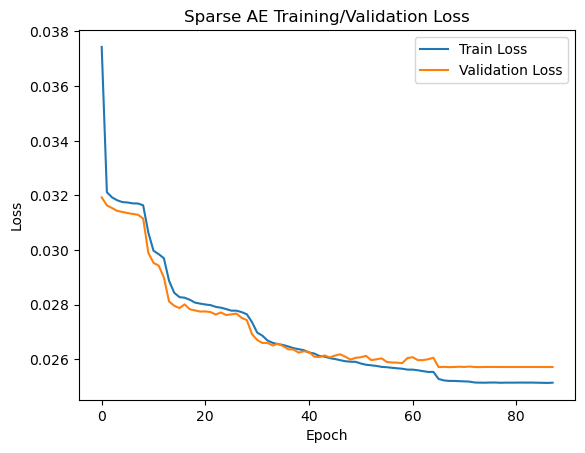

Explained Variance Ratio (total): 0.3547444727738417


In [17]:
sparseAE = SparseAutoencoder(
    X_train=X_train,
    X_val=X_val,
    encoding_dim=5,             # 必须提供，潜在维度
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,
    sparsity_target=0.05,
    beta=1.0,
)

sparseAE.train(show_plot=True)

# 评估
mu_z, rec_errs, evr_each, evr_total, X_recon = sparseAE.evaluate_on_data(X_test)
print("Explained Variance Ratio (total):", evr_total)


Early stopping at epoch 66


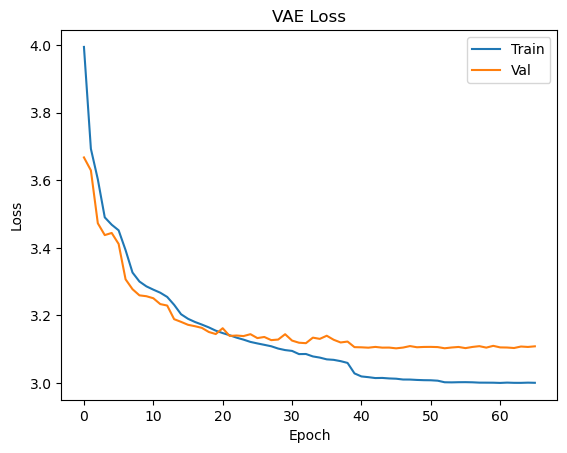

0.3465507635839741

In [ ]:
vae = VariationalAutoencoder(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,
    beta_kl=0.1          # β-VAE 可自由调节
)
vae.train(show_plot=True)

mu_z, rec_errs, evr_each, evr_total, X_recon = vae.evaluate_on_data(X_test)
evr_total


In [36]:
mu_z, rec_errs, evr_each, evr_total, X_recon = vae.evaluate_on_data(X_train)
evr_total

0.38382876273338684

In [ ]:
bvae = BetaVAE(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,         # β-VAE 可自由调节
)
bvae.train(show_plot=True)

latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed = bvae.evaluate_on_data(X_train)

Epoch 1: Train Loss=0.1380, Val Loss=0.1416
Epoch 2: Train Loss=0.1439, Val Loss=0.1358
Epoch 3: Train Loss=0.1416, Val Loss=0.1410
Epoch 4: Train Loss=0.1393, Val Loss=0.1325
Epoch 5: Train Loss=0.1279, Val Loss=0.1187
Epoch 6: Train Loss=0.1137, Val Loss=0.1054
Epoch 7: Train Loss=0.1036, Val Loss=0.0975
Epoch 8: Train Loss=0.0966, Val Loss=0.0954
Epoch 9: Train Loss=0.0915, Val Loss=0.0898
Epoch 10: Train Loss=0.0885, Val Loss=0.0881
Epoch 11: Train Loss=0.0849, Val Loss=0.0849
Epoch 12: Train Loss=0.0828, Val Loss=0.0819
Epoch 13: Train Loss=0.0801, Val Loss=0.0804
Epoch 14: Train Loss=0.0774, Val Loss=0.0778
Epoch 15: Train Loss=0.0754, Val Loss=0.0765
Epoch 16: Train Loss=0.0739, Val Loss=0.0753
Epoch 17: Train Loss=0.0729, Val Loss=0.0734
Epoch 18: Train Loss=0.0707, Val Loss=0.0724
Epoch 19: Train Loss=0.0698, Val Loss=0.0712
Epoch 20: Train Loss=0.0683, Val Loss=0.0703
Epoch 21: Train Loss=0.0671, Val Loss=0.0695
Epoch 22: Train Loss=0.0664, Val Loss=0.0684
Epoch 23: Train Los

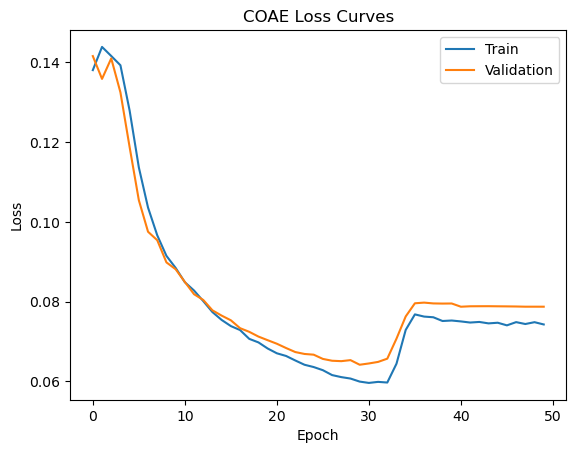

Total Explained Variance Ratio (COAE): 0.21512548477861848


In [34]:
coae = COAETrainer(X_train, X_val, 
    latent_dim=5, 
    layer1=128, 
    layer2=64, 
    layer3=32, 
    n_clusters=5)
coae.train(show_plot=True)

z, rec_errs, evr_each, evr_total, X_recon = coae.evaluate_on_data(X_train)

print("Total Explained Variance Ratio (COAE):", evr_total)


Early stopping at epoch 59


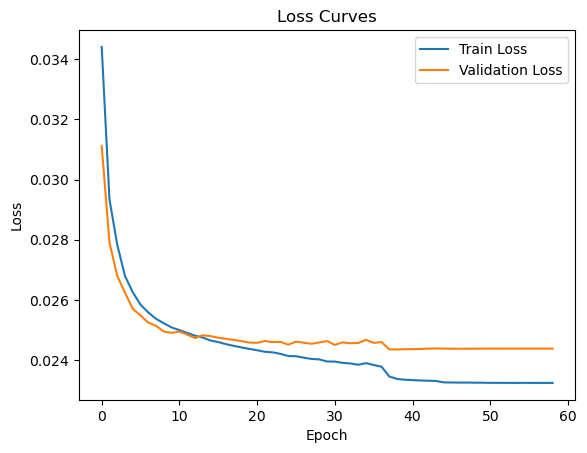

0.42273332016774323

In [29]:
autoencoder = Autoencoder(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,         # β-VAE 可自由调节
)
autoencoder.train(show_plot=True)

latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed = autoencoder.evaluate_on_data(X_train)
# 这里的 X_train, X_val, X_test 是预先定义好的数据集
explained_variance_ratio_total

In [18]:
explained_variance_ratio_total

0.42063804519264864

In [194]:
from sklearn.decomposition import NMF
import torch

# X_train: numpy 数组，shape=[n_samples, n_features]
z_dim = 10  # NMF 因子数，跟 VAE latent dim 保持一致
nmf = NMF(n_components=z_dim, init='random', random_state=0, max_iter=200)
H = nmf.fit_transform(X_train)          # shape [n_samples, z_dim]
W = nmf.components_.T                   # shape [n_features, z_dim]


c:\Anaconda\envs\mne\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Epoch 1, Batch 284, Recon Loss: 4.9530, KL Loss: 0.2790, TC Loss: 0.7097, D Loss: 0.7284
Epoch 2, Batch 284, Recon Loss: 4.7773, KL Loss: 0.3930, TC Loss: 0.6780, D Loss: 0.6963
Epoch 3, Batch 284, Recon Loss: 5.1795, KL Loss: 0.2817, TC Loss: 0.6724, D Loss: 0.7066
Epoch 4, Batch 284, Recon Loss: 4.5292, KL Loss: 0.3137, TC Loss: 0.6955, D Loss: 0.6947
Epoch 5, Batch 284, Recon Loss: 3.5275, KL Loss: 0.1335, TC Loss: 0.7026, D Loss: 0.7067
Epoch 6, Batch 284, Recon Loss: 4.7321, KL Loss: 0.5773, TC Loss: 0.6984, D Loss: 0.6877
Epoch 7, Batch 284, Recon Loss: 3.0455, KL Loss: 0.2401, TC Loss: 0.6858, D Loss: 0.6902
Epoch 8, Batch 284, Recon Loss: 4.6431, KL Loss: 0.1861, TC Loss: 0.6917, D Loss: 0.6922
Epoch 9, Batch 284, Recon Loss: 3.7566, KL Loss: 0.1964, TC Loss: 0.7066, D Loss: 0.6932
Epoch 10, Batch 284, Recon Loss: 5.1687, KL Loss: 0.7099, TC Loss: 0.6943, D Loss: 0.7096
Epoch 11, Batch 284, Recon Loss: 3.3608, KL Loss: 0.1991, TC Loss: 0.7030, D Loss: 0.7054
Epoch 12, Batch 284

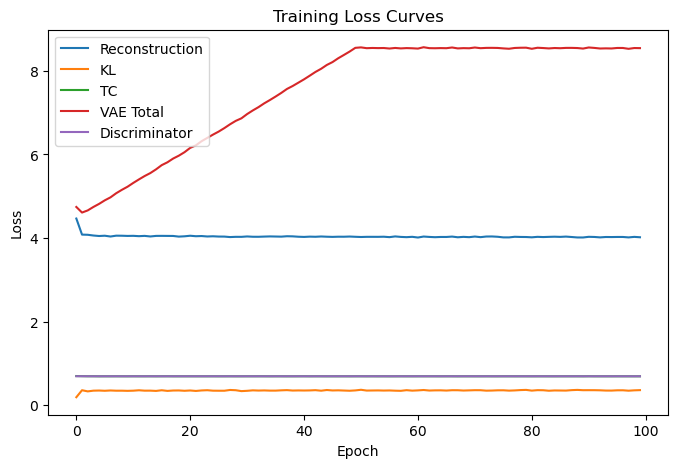

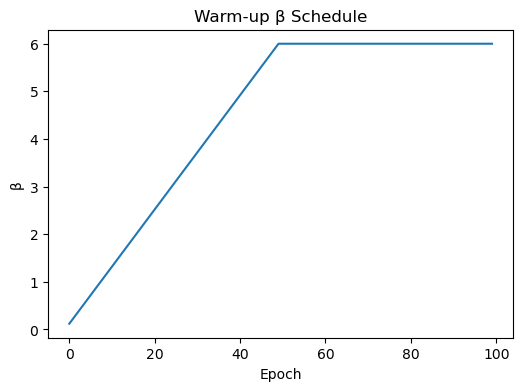

In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 1. 准备数据
# 假设 X_train 是一个 numpy 数组
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# 这里直接用 TensorDataset，因为我们只关心输入 x
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 定义模型结构和超参数
input_dim = X_train.shape[1]
hidden_dims = [112, 106, 96]      # 你可以根据需要调整
z_dim = 5                   # 潜在因子的维度
beta_max = 6.0               # FactorVAE 中 β 的最终最大值
warmup_epochs = 50           # β 从 0 升到 beta_max 用多少个 epoch
num_epochs = 100             # 总训练轮数

# 3. 实例化各个模块
encoder = Encoder(input_dim=input_dim, hidden_dims=hidden_dims, z_dim=z_dim)
decoder = Decoder(z_dim=z_dim, hidden_dims=list(reversed(hidden_dims)), output_dim=input_dim)
factor_vae = FactorVAE(encoder, decoder)
discriminator = Discriminator(z_dim=z_dim, hidden_dims=[1000, 1000])

# 4. 创建 Trainer
trainer = Trainer(
    model=factor_vae,
    discriminator=discriminator,
    lr_vae=5e-4,
    lr_d=2e-4,
    beta_max=beta_max,
    warmup_epochs=warmup_epochs,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# 5. 开始训练
trainer.train(train_loader, num_epochs=num_epochs)

# （可选）训练结束后保存模型
# torch.save({
#     'encoder_state_dict': encoder.state_dict(),
#     'decoder_state_dict': decoder.state_dict(),
#     'discriminator_state_dict': discriminator.state_dict(),
# }, "factor_vae_checkpoint.pth")


In [40]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
) = trainer.evaluate_on_data(X_test)
explained_variance_ratio_total

0.12883652348426078

In [186]:
import copy
import torch
import torch.nn.functional as F

# 假设你已有：factor_vae, discriminator, train_loader, X_train, Trainer 类

# ====================================
# 1. 拷贝一个模型实例作为 AE 基线
# ====================================
ae_model = copy.deepcopy(factor_vae)

# ====================================
# 2. AE 预训练：只用重建损失
# ====================================
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=5e-4)
num_ae_epochs = 100
ae_model.to(device)  # 确保模型在正确的设备上
ae_model.train()
for epoch in range(1, num_ae_epochs + 1):
    running_loss = 0.0
    for batch in train_loader:
        # 拆包
        x = batch[0].to(device)
        # forward
        recon, mu, logvar, z = ae_model(x)
        # 只算 MSE 重建
        loss = F.mse_loss(recon, x, reduction='mean')
        # 优化
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        running_loss += loss.item()

    print(f"[AE Pretrain] Epoch {epoch}/{num_ae_epochs}, Recon MSE: {running_loss/len(train_loader):.4f}")

# ====================================
# 3. 评估 AE 基线的解释方差
# ====================================
# 用一个临时 Trainer，只需能够跑 evaluate_on_data
ae_trainer = Trainer(
    model=ae_model,
    discriminator=discriminator,
    beta_max=0.0,           # 不会跑 TC
    warmup_epochs=1,        # 不用 warm-up
    device=device
)
latent_ae, errors_ae, ratios_ae, total_ratio_ae, recon_ae = ae_trainer.evaluate_on_data(X_train)
_,_,_,total_ratio_ae_test,_ = ae_trainer.evaluate_on_data(X_test)
print(f"纯 AE 基线解释方差: {total_ratio_ae:.4f}")  # 应该接近你预期的 ~0.34
print(f"AE 基线测试集解释方差: {total_ratio_ae_test:.4f}")  # 应该接近你预期的 ~0.34



[AE Pretrain] Epoch 1/100, Recon MSE: 0.0366
[AE Pretrain] Epoch 2/100, Recon MSE: 0.0326
[AE Pretrain] Epoch 3/100, Recon MSE: 0.0321
[AE Pretrain] Epoch 4/100, Recon MSE: 0.0308
[AE Pretrain] Epoch 5/100, Recon MSE: 0.0304
[AE Pretrain] Epoch 6/100, Recon MSE: 0.0303
[AE Pretrain] Epoch 7/100, Recon MSE: 0.0301
[AE Pretrain] Epoch 8/100, Recon MSE: 0.0298
[AE Pretrain] Epoch 9/100, Recon MSE: 0.0291
[AE Pretrain] Epoch 10/100, Recon MSE: 0.0288
[AE Pretrain] Epoch 11/100, Recon MSE: 0.0287
[AE Pretrain] Epoch 12/100, Recon MSE: 0.0285
[AE Pretrain] Epoch 13/100, Recon MSE: 0.0284
[AE Pretrain] Epoch 14/100, Recon MSE: 0.0283
[AE Pretrain] Epoch 15/100, Recon MSE: 0.0281
[AE Pretrain] Epoch 16/100, Recon MSE: 0.0278
[AE Pretrain] Epoch 17/100, Recon MSE: 0.0276
[AE Pretrain] Epoch 18/100, Recon MSE: 0.0274
[AE Pretrain] Epoch 19/100, Recon MSE: 0.0274
[AE Pretrain] Epoch 20/100, Recon MSE: 0.0273
[AE Pretrain] Epoch 21/100, Recon MSE: 0.0272
[AE Pretrain] Epoch 22/100, Recon MSE: 0.02

[Decoder Adpt] Epoch1/5  MSE=0.0248
[Decoder Adpt] Epoch2/5  MSE=0.0248
[Decoder Adpt] Epoch3/5  MSE=0.0248
[Decoder Adpt] Epoch4/5  MSE=0.0247
[Decoder Adpt] Epoch5/5  MSE=0.0248
Epoch 1, Batch 284, Recon Loss: 4.4356, KL Loss: 10.3590, TC Loss: 0.7263, D Loss: 0.6622
Epoch 2, Batch 284, Recon Loss: 4.6482, KL Loss: 3.5206, TC Loss: 0.7480, D Loss: 0.6632
Epoch 3, Batch 284, Recon Loss: 4.9457, KL Loss: 2.9842, TC Loss: 0.9145, D Loss: 0.6456
Epoch 4, Batch 284, Recon Loss: 3.7747, KL Loss: 2.1267, TC Loss: 0.5691, D Loss: 0.7364
Epoch 5, Batch 284, Recon Loss: 2.4399, KL Loss: 1.7482, TC Loss: 0.7495, D Loss: 0.7028
Epoch 6, Batch 284, Recon Loss: 6.3667, KL Loss: 1.4959, TC Loss: 0.7054, D Loss: 0.6565
Epoch 7, Batch 284, Recon Loss: 3.7872, KL Loss: 1.1749, TC Loss: 0.7322, D Loss: 0.7232
Epoch 8, Batch 284, Recon Loss: 4.1509, KL Loss: 1.2167, TC Loss: 0.7599, D Loss: 0.6187
Epoch 9, Batch 284, Recon Loss: 4.1539, KL Loss: 0.7459, TC Loss: 0.7482, D Loss: 0.7329
Epoch 10, Batch 28

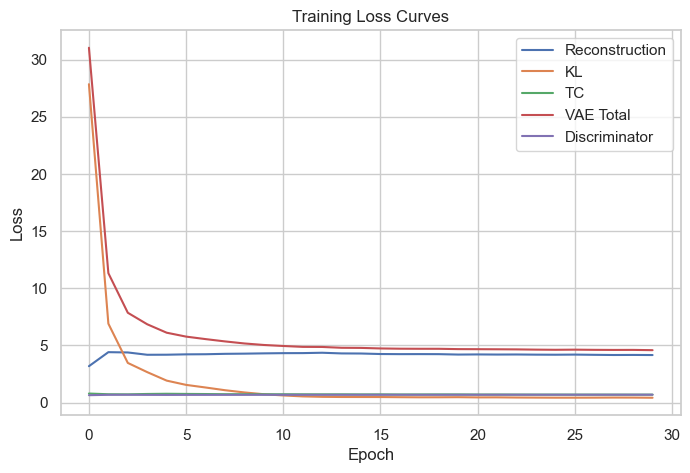

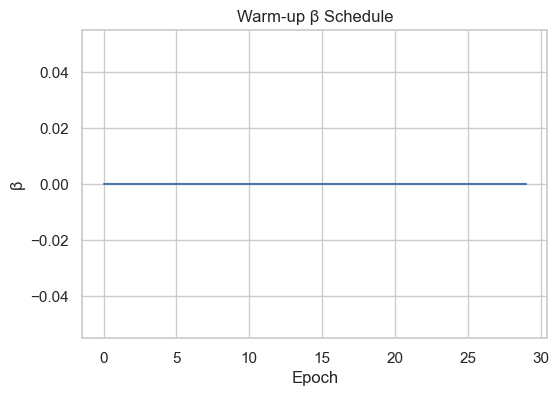

Epoch 1, Batch 284, Recon Loss: 2.7826, KL Loss: 0.2015, TC Loss: 0.6945, D Loss: 0.6905
Epoch 2, Batch 284, Recon Loss: 2.2869, KL Loss: 0.2852, TC Loss: 0.7035, D Loss: 0.6997
Epoch 3, Batch 284, Recon Loss: 3.2869, KL Loss: 0.2028, TC Loss: 0.6759, D Loss: 0.6755
Epoch 4, Batch 284, Recon Loss: 3.7489, KL Loss: 0.3238, TC Loss: 0.6787, D Loss: 0.6777
Epoch 5, Batch 284, Recon Loss: 2.8969, KL Loss: 0.1243, TC Loss: 0.6942, D Loss: 0.6911
Epoch 6, Batch 284, Recon Loss: 4.6238, KL Loss: 0.4708, TC Loss: 0.6805, D Loss: 0.7286
Epoch 7, Batch 284, Recon Loss: 1.9240, KL Loss: 0.3033, TC Loss: 0.7074, D Loss: 0.6941
Epoch 8, Batch 284, Recon Loss: 4.2620, KL Loss: 0.1062, TC Loss: 0.6965, D Loss: 0.7032
Epoch 9, Batch 284, Recon Loss: 5.5783, KL Loss: 0.4967, TC Loss: 0.6894, D Loss: 0.6958
Epoch 10, Batch 284, Recon Loss: 4.5868, KL Loss: 0.8468, TC Loss: 0.6959, D Loss: 0.6868
Epoch 11, Batch 284, Recon Loss: 4.3946, KL Loss: 0.3133, TC Loss: 0.6956, D Loss: 0.6742
Epoch 12, Batch 284

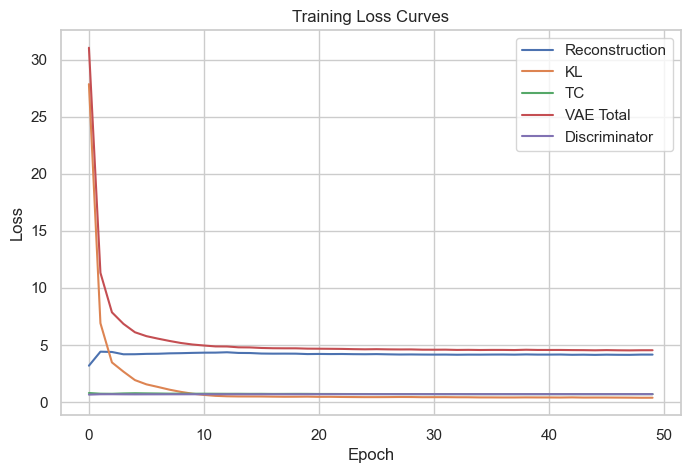

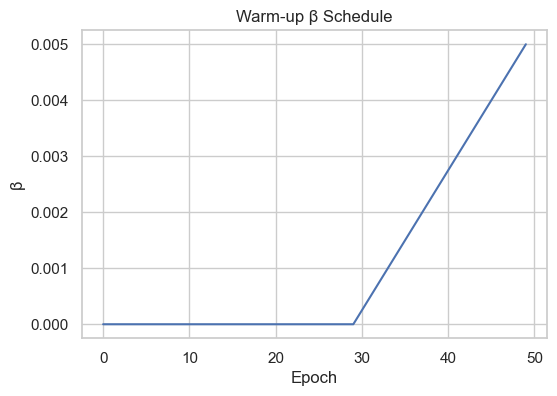

→ FactorVAE 微调阶段解释方差: 0.0879


In [187]:
import copy

# —— 1) 基于 AE 权重 拷贝一个用于微调 —— #
ft_model = copy.deepcopy(ae_model).to(device)

# —— 2.1) 冻结 Encoder，只训练 Decoder —— #
for p in ft_model.encoder.parameters():
    p.requires_grad = False
for p in ft_model.decoder.parameters():
    p.requires_grad = True

decoder_opt = torch.optim.Adam(
    filter(lambda p: p.requires_grad, ft_model.parameters()),
    lr=1e-4
)

ft_model.train()
for epoch in range(5):
    epoch_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        mu, logvar = ft_model.encoder(x)
        z = ft_model.reparameterize(mu, logvar).detach()
        recon = ft_model.decoder(z)
        loss = F.mse_loss(recon, x, reduction='mean')
        decoder_opt.zero_grad(); loss.backward(); decoder_opt.step()
        epoch_loss += loss.item()
    print(f"[Decoder Adpt] Epoch{epoch+1}/5  MSE={epoch_loss/len(train_loader):.4f}")

# —— 2.2) 全面解冻 + 引入 TC —— #
for p in ft_model.parameters():
    p.requires_grad = True

# 深拷贝一个干净的 Discriminator
ft_discriminator = copy.deepcopy(discriminator).to(device)

finetuner = Trainer(
    model=ft_model,
    discriminator=ft_discriminator,
    lr_vae=1e-4,
    lr_d=2e-4,
    beta_max=0.0,
    warmup_epochs=80,
    device=device
)

# —— **只调用一次** 微调 —— #
finetuner.train(train_loader, num_epochs=30)

# 阶段②：0→0.005，20 epoch
finetuner.beta_max = 0.005
finetuner.warmup_epochs = 20
finetuner.train(train_loader, num_epochs=20)

# # 阶段③：0.005→0.01，20 epoch
# finetuner.beta_max = 0.01
# finetuner.warmup_epochs = 20
# finetuner.train(train_loader, num_epochs=20)


# —— 最后评估 —— #
latent_ft, errors_ft, ratios_ft, total_ratio_ft, recon_ft = \
    finetuner.evaluate_on_data(X_train)
print(f"→ FactorVAE 微调阶段解释方差: {total_ratio_ft:.4f}")

# print(f"→ FactorVAE 微调阶段解释方差: {total_ratio_ft:.4f}")


Early stopping at epoch 143


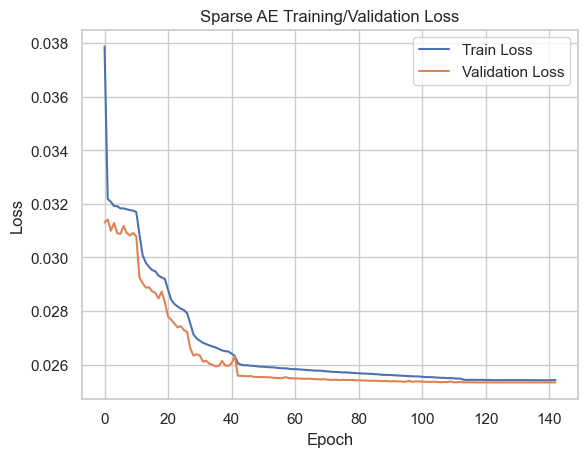

In [ ]:
# 示例参数
encoding_dim = 5
layer1_neurons = 127
layer2_neurons = 117
layer3_neurons = 106
# layer1_neurons = 128
# layer2_neurons = 64
# layer3_neurons = 32
# layer4_neurons = 90
# n_clusters = 4  # 可根据需要调整聚类数

# 初始化 COAETrainer（推荐使用该封装）
autoencoder = SparseAutoencoder(
    X_train=X_train,
    X_val=X_val,
    encoding_dim=encoding_dim,
    layer1_neurons=layer1_neurons,
    layer2_neurons=layer2_neurons,
    layer3_neurons=layer3_neurons,
    # layer4_neurons=layer4_neurons,
    # n_clusters=n_clusters
)

# 开始训练
autoencoder.train(show_plot=True)
# autoencoder.export_to_onnx(X_train, onnx_path = "../output/sparse_autoencoder.onnx")

In [224]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF

# 假设 X_train 已经定义为 NumPy 数组，X_test 同理。
# ----------------------------------------------------------------
# 1. 数据准备
X_train_np = np.array(X_train)
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 定义模型超参数
input_dim = X_train_np.shape[1]
z_dim = 5               # 潜在因子维度
# 对于 Method1, 使用 无隐藏层 AE 以直接利用 NMF 初始化
ae_hidden_dims = []     # 取消所有隐藏层

# 3. NMF 分解
nmf_model = NMF(n_components=z_dim, init='random', max_iter=500)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"NMF 字典 H_nmf 形状: {H_nmf.shape}")
# 3. 还原重建结果
reconstructed = np.dot(W_nmf, H_nmf)

# 4. 计算潜变量 (W) 的每个因子的方差
latent_variances = np.var(W_nmf, axis=0)  # W 是 (n_samples, n_components)

# 5. 计算总方差
total_variance = np.var(X_train, axis=0).sum()

# 6. 每个潜变量解释方差的比例
explained_variance_ratios = latent_variances / total_variance

# 7. 样本级别重建误差（MSE）
reconstruction_errors = np.mean((X_train - reconstructed) ** 2, axis=1)

# 8. 重建后的总方差贡献
reconstruction_variance = np.var(reconstructed, axis=0).sum()
explained_variance_ratio_total = reconstruction_variance / total_variance

# 9. 打印
print("每个潜变量解释的方差比例：", explained_variance_ratios)
print("总重建解释方差比例：", explained_variance_ratio_total)
print("平均样本重建MSE：", reconstruction_errors.mean())


# 4. 构建无隐藏层的 AE (Encoder + Decoder)
class SimpleEncoder(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(SimpleEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, 2*z_dim)
        self.z_dim = z_dim
    def forward(self, x):
        stats = self.fc(x)
        mu      = stats[:, :self.z_dim]
        logvar  = stats[:, self.z_dim:]
        return mu, logvar

class SimpleDecoder(nn.Module):
    def __init__(self, z_dim, output_dim, init_W=None):
        super(SimpleDecoder, self).__init__()
        self.fc = nn.Linear(z_dim, output_dim)
        if init_W is not None:
            # init_W shape must be (z_dim, output_dim)
            self.fc.weight.data.copy_(init_W)
            self.fc.bias.data.zero_()
    def forward(self, z):
        return self.fc(z)

class SimpleVAE(nn.Module):
    def __init__(self, enc, dec):
        super(SimpleVAE, self).__init__()
        self.encoder = enc
        self.decoder = dec
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

# 5. 实例化简单 AE 并用 NMF 字典初始化 Decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_ae  = SimpleEncoder(input_dim=input_dim, z_dim=z_dim)
decoder_ae  = SimpleDecoder(z_dim=z_dim, output_dim=input_dim,
                             init_W=torch.tensor(H_nmf.T, dtype=torch.float32))
ae_model = SimpleVAE(encoder_ae, decoder_ae).to(device)

# 6. AE 预训练（只用重建 MSE）
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=5e-4)
num_ae_epochs = 200
ae_model.train()
for epoch in range(1, num_ae_epochs+1):
    running_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        recon, mu, logvar, z = ae_model(x)
        loss = F.mse_loss(recon, x, reduction='mean')
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"[AE Pretrain] Epoch {epoch}/{num_ae_epochs}, Recon MSE: {running_loss/len(train_loader):.4f}")

# 7. 将预训练的 Decoder 权重 迁移回原始深度模型
# factor_vae.decoder.net[-1] 应对应解码器最后一层的 Linear
# 示例：
# factor_vae.decoder.net[-1].weight.data.copy_(ae_model.decoder.fc.weight.t())
# factor_vae.decoder.net[-1].bias.data.copy_(ae_model.decoder.fc.bias)

# 8. 添加 evaluate_on_data 方法

def evaluate_on_data(model, device, X):
    """
    在数据 X（numpy array 或 list）上评估：
    - 重建结果 reconstructed
    - 潜在因子 latent_factors
    - 每个潜在因子的解释方差比 explained_variance_ratios
    - 总体解释方差比 explained_variance_ratio_total
    - 每个样本的重建误差 reconstruction_errors

    返回：
      (latent_factors, reconstruction_errors,
       explained_variance_ratios,
       explained_variance_ratio_total,
       reconstructed)
    """
    model.eval()
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    with torch.no_grad():
        reconstructed, mu, logvar, z = model(X_tensor)
        latent_factors = z.cpu().numpy()

        latent_variances = np.var(latent_factors, axis=0)
        total_variance = np.var(X, axis=0).sum()
        explained_variance_ratios = latent_variances / total_variance

        reconstruction_errors = (
            (X_tensor - reconstructed).pow(2)
            .mean(dim=1)
            .cpu()
            .numpy()
        )

        reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
        explained_variance_ratio_total = reconstruction_variance / total_variance

    return (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
        reconstructed.cpu().numpy()
    )

# ======================================================================
# 后续可用 evaluate_on_data(ae_model, device, X_test) 查看预训练 AE 表现。
# 同理，对深度 FactorVAE 可使用相同函数进行评估。
# ======================================================================


NMF 字典 H_nmf 形状: (5, 114)
每个潜变量解释的方差比例： [0.03731522 0.01205813 0.0067541  0.00688278 0.00421307]
总重建解释方差比例： 0.32094432066161976
平均样本重建MSE： 0.02695891577126193
[AE Pretrain] Epoch 10/200, Recon MSE: 0.0361
[AE Pretrain] Epoch 20/200, Recon MSE: 0.0284
[AE Pretrain] Epoch 30/200, Recon MSE: 0.0271
[AE Pretrain] Epoch 40/200, Recon MSE: 0.0268
[AE Pretrain] Epoch 50/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 60/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 70/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 80/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 90/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 100/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 110/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 120/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 130/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 140/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 150/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 160/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 170/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 180/200, Recon MSE: 0.0265
[AE 

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF

# 假设 X_train 已经定义为 NumPy 数组，X_test 同理。
# ----------------------------------------------------------------
# 1. 数据准备
X_train_np = np.array(X_train)
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 定义模型超参数
input_dim = X_train_np.shape[1]
z_dim = 5               # 潜在因子维度
layer1_neurons = 5
layer2_neurons = 16
layer3_neurons = 32

# 3. NMF 分解
nmf_model = NMF(n_components=z_dim, init='random', max_iter=5000)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"NMF 字典 H_nmf 形状: {H_nmf.shape}")
# 3. 还原重建结果
reconstructed = np.dot(W_nmf, H_nmf)

# # 4. 计算潜变量 (W) 的每个因子的方差
# latent_variances = np.var(W_nmf, axis=0)  # W 是 (n_samples, n_components)

# # 5. 计算总方差
# total_variance = np.var(X_train, axis=0).sum()

# # 6. 每个潜变量解释方差的比例
# explained_variance_ratios = latent_variances / total_variance

# # 7. 样本级别重建误差（MSE）
# reconstruction_errors = np.mean((X_train - reconstructed) ** 2, axis=1)

# # 8. 重建后的总方差贡献
# reconstruction_variance = np.var(reconstructed, axis=0).sum()
# explained_variance_ratio_total = reconstruction_variance / total_variance
# 假设：X_train 是 (n_samples, n_features)，
# reconstructed 是 NMF 重建结果 (n_samples, n_features)

# 1. 计算残差
residuals = X_train - reconstructed

# 2. 原始数据每个特征的方差 Var(X_j)
var_original = np.var(X_train, axis=0)

# 3. 残差每个特征的方差 Var(X_j - Ŷ_j)
var_residual  = np.var(residuals, axis=0)

# 4. 每个特征的 VAF = 1 - Var(residual) / Var(original)
explained_variance_ratios = 1 - (var_residual / var_original)

# 5. 计算总体的 VAF
total_var_original = var_original.sum()
total_var_residual = var_residual.sum()
explained_variance_ratio_total = 1 - (total_var_residual / total_var_original)

# 6. 样本级别重建误差（MSE）
reconstruction_errors = np.mean(residuals**2, axis=1)

# 9. 打印
print("每个潜变量解释的方差比例：", explained_variance_ratios)
print("总重建解释方差比例：", explained_variance_ratio_total)
print("平均样本重建MSE：", reconstruction_errors.mean())

# 4. 构建深度 AE (Encoder + Decoder)
class DeepVAE(nn.Module):
    def __init__(self, input_dim, layer1, layer2, layer3, latent_dim, init_W=None):
        super(DeepVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2, layer3),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3, 2 * latent_dim),  # 输出 mu 与 logvar
        )
        self.latent_dim = latent_dim
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3, layer2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2, layer1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1, input_dim),
        )
        # 用 NMF 字典初始化 Decoder 最后一层
        if init_W is not None:
            # init_W: (latent_dim, input_dim) -> 需要转置匹配 PyTorch Linear weight (out_features, in_features)
            final_lin = self.decoder[-1]
            final_lin.weight.data.copy_(torch.tensor(init_W, dtype=torch.float32))
            final_lin.bias.data.zero_()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        stats = self.encoder(x)
        mu = stats[:, :self.latent_dim]
        logvar = stats[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

# 5. 实例化深度 VAE 并用 NMF 字典初始化 Decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = DeepVAE(
    input_dim=input_dim,
    layer1=layer1_neurons,
    layer2=layer2_neurons,
    layer3=layer3_neurons,
    latent_dim=z_dim,
    init_W=H_nmf.T
).to(device)

# 6. AE 预训练（只用重建 MSE）
optimizer_ae = torch.optim.Adam(vae_model.parameters(), lr=5e-4)
num_ae_epochs = 200
vae_model.train()
for epoch in range(1, num_ae_epochs+1):
    running_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        recon, mu, logvar, z = vae_model(x)
        loss = F.mse_loss(recon, x, reduction='mean')
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item()
    if epoch % 3 == 0:
        print(f"[AE Pretrain] Epoch {epoch}/{num_ae_epochs}, Recon MSE: {running_loss/len(train_loader):.4f}")

# 7. 添加 evaluate_on_data 函数

def evaluate_on_data(model, device, X):
    model.eval()
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)


    # with torch.no_grad():
    #     reconstructed, mu, logvar, z = model(X_tensor)
    #     latent_factors = z.cpu().numpy()

    #     latent_variances = np.var(latent_factors, axis=0)
    #     total_variance = np.var(X, axis=0).sum()
    #     explained_variance_ratios = latent_variances / total_variance

    #     reconstruction_errors = (
    #         (X_tensor - reconstructed).pow(2)
    #         .mean(dim=1)
    #         .cpu()
    #         .numpy()
    #     )

    #     reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
    #     explained_variance_ratio_total = reconstruction_variance / total_variance
        
    # return (
    #     latent_factors,
    #     reconstruction_errors,
    #     explained_variance_ratios,
    #     explained_variance_ratio_total,
    #     reconstructed.cpu().numpy()
    # )

    with torch.no_grad():
        reconstructed, mu, logvar, z = model(X_tensor)
        latent_factors = z.cpu().numpy()

        # 计算残差
        X_hat = reconstructed.cpu().numpy()
        residuals = X - X_hat

        # 对每个特征维度计算 VAF
        var_original = np.var(X, axis=0)
        var_residual = np.var(residuals, axis=0)
        # VAF = 1 - Var(residual) / Var(original)
        explained_variance_ratios = 1 - (var_residual / var_original)

        # 总体 VAF
        total_var_original = var_original.sum()
        total_var_residual = var_residual.sum()
        explained_variance_ratio_total = 1 - (total_var_residual / total_var_original)

        reconstruction_errors = (
            (X_tensor - reconstructed).pow(2)
            .mean(dim=1)
            .cpu()
            .numpy()
        )

    return (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
        X_hat
    )


# 示例：评估预训练后模型在测试集上的表现
# latent, errs, ratios, total_ratio, recon = evaluate_on_data(vae_model, device, X_test)
# print(f"深度 AE 在测试集的总体方差解释率: {total_ratio:.4f}")


NMF 字典 H_nmf 形状: (5, 114)
每个潜变量解释的方差比例： [0.25729994 0.56078047 0.47978407 0.1690358  0.01226658 0.21935053
 0.77387031 0.39838675 0.60562664 0.23408857 0.24275244 0.18480286
 0.20203391 0.03895247 0.26797209 0.3178631  0.04012296 0.4014694
 0.27088999 0.32106905 0.53243369 0.35138116 0.1264454  0.27039476
 0.33332765 0.35976551 0.5378249  0.20866399 0.13484193 0.18703121
 0.30025243 0.30923498 0.1864494  0.30387735 0.1672036  0.18720145
 0.21561906 0.12756977 0.03065606 0.52070224 0.17809689 0.37660847
 0.96513649 0.42323848 0.18950579 0.16154041 0.21828684 0.1092339
 0.47819694 0.12208149 0.21467643 0.14313178 0.11516545 0.09494241
 0.25728499 0.45330384 0.33912833 0.02950496 0.13308497 0.47169496
 0.10328203 0.04498798 0.23013981 0.23594847 0.0121432  0.02360508
 0.28857064 0.20577008 0.13653715 0.1599538  0.1643963  0.18074184
 0.04111099 0.35477615 0.21003145 0.02715843 0.46443157 0.02176668
 0.29136197 0.27379043 0.12104226 0.03862995 0.76040229 0.05158703
 0.22027722 0.16430999 0

In [18]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
        ) = evaluate_on_data(vae_model, 'cuda', X_train)  # 评估重建效果
explained_variance_ratio_total # 0.348534457451562
# reconstruction_errors.mean()

0.3490718919010236

In [19]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
        ) = evaluate_on_data(vae_model, 'cuda', X_test)  # 评估重建效果
explained_variance_ratio_total # 0.348534457451562
# reconstruction_errors.mean()

0.3385599021245662

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF

# 假设 X_train 已定义为 NumPy 数组，这里开始 Method5：在 FactorVAE 中直接融合 NMF 结构
# ======================================================================
# 1. 数据准备
X_train_np = np.array(X_train)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_np, dtype=torch.float32)),
                          batch_size=32, shuffle=True)

# 2. NMF 分解
z_dim = 5  # 潜在因子数量
input_dim = X_train_np.shape[1]
nmf_model = NMF(n_components=z_dim, init='random', random_state=42, max_iter=500)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"Loaded NMF dictionary H_nmf with shape {H_nmf.shape}")

# 3. 构建融合 NMF 结构的 FactorVAE
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim, dropout_rate=0.0):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(0.01), nn.Dropout(dropout_rate)]
            prev = h
        layers.append(nn.Linear(prev, 2*z_dim))
        self.net = nn.Sequential(*layers)
        self.z_dim = z_dim

    def forward(self, x):
        stats = self.net(x)
        mu, logvar = stats[:, :self.z_dim], stats[:, self.z_dim:]
        return mu, logvar

class NMFDecoder(nn.Module):
    """只含一层线性层，权重矩阵即 NMF 字典。"""
    def __init__(self, init_W):
        super().__init__()
        # init_W: numpy array of shape (z_dim, input_dim)
        self.W = nn.Parameter(torch.tensor(init_W, dtype=torch.float32), requires_grad=True)

    def forward(self, z):
        # z: (batch,z_dim), W: (z_dim,input_dim)
        return torch.matmul(z, self.W)

class FactorVAE_NMF(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

class Discriminator(nn.Module):
    def __init__(self, z_dim, hidden_dims=[200,200]):
        super().__init__()
        layers = []
        prev = z_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(0.2)]
            prev = h
        layers.append(nn.Linear(prev, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

# 4. 训练器（和之前相同的 Trainer 支持 TC loss）
class Trainer:
    def __init__(self, model, discriminator,
                 lr_vae=1e-3, lr_d=1e-3, beta_max=0.1,
                 warmup_epochs=10, device=None):
        self.model = model
        self.discriminator = discriminator
        self.optim_vae = torch.optim.Adam(self.model.parameters(), lr=lr_vae)
        self.optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.beta_max = beta_max
        self.warmup_epochs = warmup_epochs
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.discriminator.to(self.device)

    def _permute_latent(self, z):
        B,D = z.size()
        z_perm = []
        for j in range(D):
            idx = torch.randperm(B, device=z.device)
            z_perm.append(z[:,j][idx])
        return torch.stack(z_perm, dim=1)

    def train(self, data_loader, num_epochs):
        for epoch in range(1, num_epochs+1):
            beta = self.beta_max * min(epoch / self.warmup_epochs, 1.0)
            for batch in data_loader:
                x = batch[0].to(self.device)
                # D-step
                with torch.no_grad():
                    mu, logvar = self.model.encoder(x)
                    z = self.model.reparameterize(mu, logvar)
                z_det = z.detach()
                z_perm = self._permute_latent(z_det)
                logits_real = self.discriminator(z_det)
                logits_fake = self.discriminator(z_perm)
                loss_d = 0.5*(F.cross_entropy(logits_real, torch.zeros(z_det.size(0),dtype=torch.long,device=self.device))
                             + F.cross_entropy(logits_fake, torch.ones(z_perm.size(0),dtype=torch.long,device=self.device)))
                self.optim_d.zero_grad(); loss_d.backward(); self.optim_d.step()
                # VAE-step
                x_recon, mu, logvar, z = self.model(x)
                recon_loss = ((x_recon - x)**2).view(x.size(0),-1).sum(dim=1).mean()
                kl_loss = 0.5*(logvar.exp() + mu**2 - 1 - logvar).sum(dim=1).mean()
                for p in self.discriminator.parameters(): p.requires_grad=False
                logits_z = self.discriminator(z)
                tc_loss = F.cross_entropy(logits_z, torch.ones(z.size(0),dtype=torch.long,device=self.device))
                for p in self.discriminator.parameters(): p.requires_grad=True
                loss_vae = recon_loss + kl_loss + beta * tc_loss
                self.optim_vae.zero_grad(); loss_vae.backward(); self.optim_vae.step()
        print("Training complete.")

    def evaluate_on_data(self, X):
        self.model.eval()
        X_np = np.array(X)
        X_t = torch.tensor(X_np, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            recon, mu, logvar, z = self.model(X_t)
            latent = z.cpu().numpy()
            latent_var = np.var(latent, axis=0)
            total_var = np.var(X_np, axis=0).sum()
            evr = latent_var / total_var
            recon_errs = ((X_t - recon)**2).mean(dim=1).cpu().numpy()
            recon_var = np.var(recon.cpu().numpy(), axis=0).sum()
            evr_total = recon_var / total_var
        return latent, recon_errs, evr, evr_total, recon.cpu().numpy()

# 5. 实例化并训练
hidden_dims = [112,106,96]
encoder = Encoder(input_dim, hidden_dims, z_dim)
decoder = NMFDecoder(H_nmf)
model = FactorVAE_NMF(encoder, decoder)
discriminator = Discriminator(z_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(model, discriminator, beta_max=0.1, warmup_epochs=10, device=device)
trainer.train(train_loader, num_epochs=100)

# 6. 评估效果
latent, errs, ratios, total_ratio, recon = trainer.evaluate_on_data(X_train_np)
print(f"FactorVAE+NMF 总体方差解释率: {total_ratio:.4f}")


Loaded NMF dictionary H_nmf with shape (5, 114)
Training complete.
FactorVAE+NMF 总体方差解释率: 0.2161


In [42]:
latent, errs, ratios, total_ratio, recon = trainer.evaluate_on_data(X_train_np)
print(f"FactorVAE+NMF 总体方差解释率: {total_ratio}")

FactorVAE+NMF 总体方差解释率: 0.21836170959920712


In [43]:
latent, errs, ratios, total_ratio, recon = trainer.evaluate_on_data(X_test)
print(f"FactorVAE+NMF 总体方差解释率: {total_ratio}")

FactorVAE+NMF 总体方差解释率: 0.20943931084487807


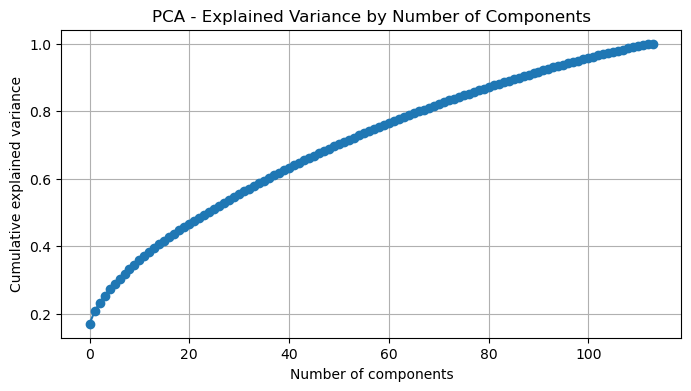

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 假设你的输入数据叫 X_train，先做标准化（这一步非常重要）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 执行 PCA，保留所有主成分
pca = PCA(n_components=X_scaled.shape[1])
pca.fit(X_scaled)

# 获取每个主成分的解释方差比率
explained_ratios = pca.explained_variance_ratio_

# 可视化累计解释方差
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(explained_ratios), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA - Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [56]:
(   latent_factors,
    reconstruction_errors,
    explained_variance_ratios,
    explained_variance_ratio_total,
    reconstructed,
        ) = autoencoder.evaluate_on_data(X_train)

In [141]:
_, _, _, explained_variance_ratio_total_test, _ = autoencoder.evaluate_on_data(X_val)
explained_variance_ratio_total_test


0.46129748413760513

In [ ]:
explained_variance_ratio_total

0.4834824423784089

In [143]:
ve_per_feature = 1 - np.var(X_train - reconstructed.cpu().numpy(), axis=0) / np.var(X_train, axis=0)
print("每道题的解释方差率:", ve_per_feature)
# 输出小于 0.1 的题目
low_variance_items = np.where(ve_per_feature < 0.1)[0]

print("解释方差率小于 0.1 的题目索引:", low_variance_items)

print("解释方差率小于 0.1 的题目:", items[low_variance_items])

每道题的解释方差率: [0.44129521 0.74635498 0.62178664 0.32509369 0.04522597 0.46398031
 0.80425968 0.51736982 0.74112287 0.48488176 0.33903182 0.3586391
 0.33162522 0.12677298 0.40322187 0.56181902 0.14152614 0.53487782
 0.41126752 0.48605481 0.66493017 0.54299201 0.20833082 0.39683628
 0.39107087 0.4808158  0.6231356  0.47865885 0.23383235 0.29254954
 0.68864821 0.44269748 0.35237935 0.49906331 0.21925217 0.37265918
 0.34459417 0.24827698 0.12133257 0.57140763 0.46656581 0.47450914
 0.84015729 0.56227642 0.35128409 0.23666716 0.36135491 0.14211919
 0.62426421 0.19800991 0.35589617 0.62281258 0.23402123 0.86776387
 0.25862455 0.55528842 0.48254062 0.09159151 0.15636727 0.56670169
 0.17643835 0.08236272 0.37496791 0.38841846 0.08871555 0.07919207
 0.4630625  0.35800398 0.40890433 0.30851986 0.31658676 0.3543786
 0.1087248  0.48883584 0.33108973 0.12897671 0.6667305  0.09791466
 0.54691235 0.61663619 0.1989133  0.10221106 0.81267439 0.32789568
 0.40262221 0.36046825 0.32626275 0.27589547 0.375774

In [31]:
latent_factors, rec_errs, evr_each, evr_total, X_recon = vae.evaluate_on_data(X_train)


In [57]:
from sklearn.decomposition import FastICA

# latent_factors 是 VAE 编码器输出的 mu 向量，形状 (N, latent_dim)
n_ica_components = latent_factors.shape[1]  # 通常设为 latent_dim

ica = FastICA(n_components=n_ica_components, random_state=0)
independent_components = ica.fit_transform(latent_factors)

# ICA 的成分形状还是 (样本数, latent_dim)
# 每列是一个独立成分，每行是样本在这个成分上的投影值
latent_factors = independent_components

In [256]:
latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)
# original_features = X if isinstance(X, np.ndarray) else X.values
original_features = (
    X_train if isinstance(X_train, np.ndarray) else X_train.values
)

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]
scaler = StandardScaler()
latent_factors_scaled = scaler.fit_transform(latent_factors)
loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(
    loadings, columns=[f"Latent_{j+1}" for j in range(n_latent_factors)]
)
# loadings_df.index = [f"Feature_{i+1}" for i in range(n_original_features)]
loadings_df.index = items


In [257]:
loadings_df = loadings_df.reindex(
    loadings_df['Latent_1'].abs().sort_values(ascending=False).index
)
loadings_df

Latent_1  Latent_2  \
Argues a lot Discute mucho                          0.347483  0.076955   
Disobedient at home Desobedece en casa              0.271929  0.113833   
Temper tantrums or hot temper Le dan rabietas o...  0.246777  0.119628   
Stubborn, sullen, or irritable Obstinado(a), ma...  0.230228  0.136414   
Demands a lot of attention Exige mucha atención     0.221982  0.026333   
...                                                      ...       ...   
Withdrawn, doesn't get involved with others Se ... -0.002839  0.114236   
Stares blankly Se queda con la mirada fija, mir...  0.002001  0.114136   
Confused or seems to be in a fog Está confundid... -0.001652  0.087603   
Wishes to be of opposite sex Desea ser del sexo...  0.001583  0.005909   
Underactive, slow moving, or lacks energy Poco ...  0.000777  0.098582   

                                                    Latent_3  Latent_4  \
Argues a lot Discute mucho                         -0.064090  0.020111   
Disobedient at home Desobedece en casa             -0.034079 -0.086248   
Temper tantrums or hot temper Le dan rabietas o... -0.042888  0.020133   
Stubborn, sullen, or irritable Obstinado(a), ma... -0.037911  0.066420   
Demands a lot of attention Exige mucha atención    -0.027775  0.102134   
...                                                      ...       ...   
Withdrawn, doesn't get involved with others Se ... -0.012561  0.021800   
Stares blankly Se queda con la mirada fija, mir...  0.014292 -0.003557   
Confused or seems to be in a fog Está confundid... -0.004065  0.003686   
Wishes to be of opposite sex Desea ser del sexo...  0.001142  0.001442   
Underactive, slow moving, or lacks energy Poco ... -0.007753  0.027253   

                                                    Latent_5  
Argues a lot Discute mucho                         -0.016924  
Disobedient at home Desobedece en casa             -0.030477  
Temper tantrums or hot temper Le dan rabietas o... -0.062606  
Stubborn, sullen, or irritable Obstinado(a), ma... -0.055400  
Demands a lot of attention Exige mucha atención     0.098439  
...                                                      ...  
Withdrawn, doesn't get involved with others Se ... -0.016077  
Stares blankly Se queda con la mirada fija, mir...  0.070106  
Confused or seems to be in a fog Está confundid...  0.055357  
Wishes to be of opposite sex Desea ser del sexo... -0.002010  
Underactive, slow moving, or lacks energy Poco ... -0.003538  

[114 rows x 5 columns]

In [258]:
import numpy as np

def average_absolute_correlation(matrix):
    """
    计算输入矩阵各列之间的平均绝对相关系数。
    
    参数:
        matrix: shape (N, d)，这里假定每行是一个样本，每列是一个factor/loading
    
    返回:
        avg_abs_corr: 所有列两两相关系数取绝对值后的平均值
    """
    # 1) 计算 d x d 的相关系数矩阵 (列 vs 列)
    corr_matrix = np.corrcoef(matrix, rowvar=False)  # rowvar=False表示按列计算相关
    
    # 2) 取上三角（不含对角线）的索引
    d = corr_matrix.shape[0]
    upper_tri_indices = np.triu_indices(d, k=1)  # (行索引数组, 列索引数组)
    
    # 3) 取出相关系数，并计算其绝对值
    off_diag_corr_values = corr_matrix[upper_tri_indices]  # 非对角线元素
    abs_off_diag = np.abs(off_diag_corr_values)
    
    # 4) 求平均
    avg_abs_corr = np.mean(abs_off_diag)
    
    return avg_abs_corr


# ==== 示例用法 ====
if __name__ == "__main__":
    # 模拟一个 latent factor 矩阵, shape = (N, d)
    # 比如 N=1000, d=5    
    # 计算 latent factors 的平均绝对相关
    avg_corr_latent = average_absolute_correlation(latent_factors)
    print("Average absolute correlation of latent factors:", avg_corr_latent)
    
    # 如果有 loading_factors 矩阵，同理：
    # loading_factors = ...
    # avg_corr_loading = average_absolute_correlation(loading_factors)
    # print("Average absolute correlation of loading factors:", avg_corr_loading)


Average absolute correlation of latent factors: 0.10220892811478277


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_13076\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


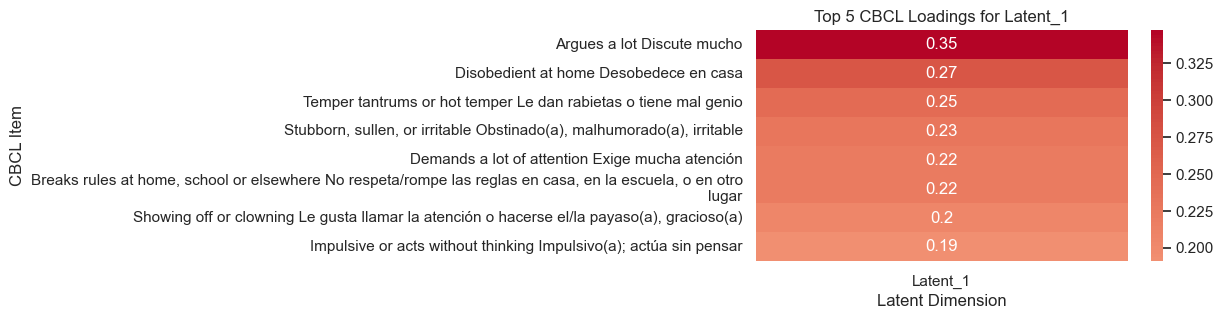

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_13076\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


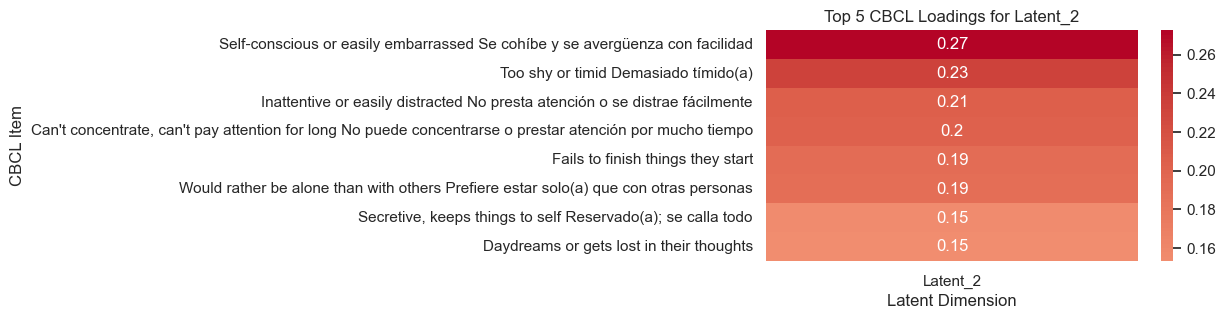

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_13076\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


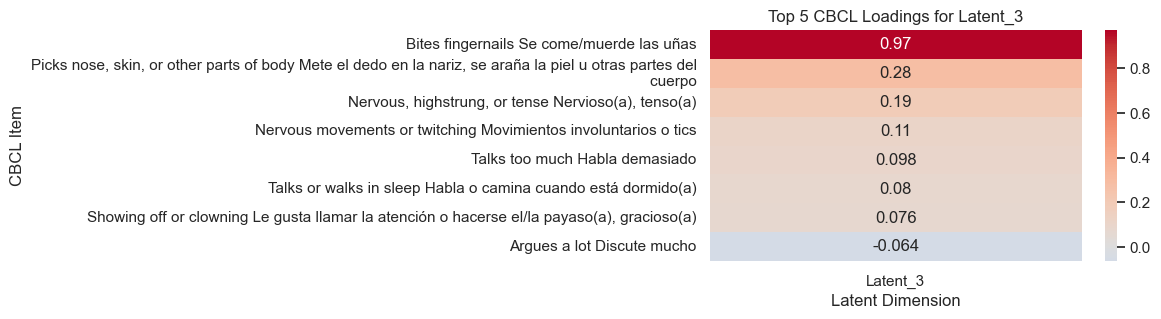

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_13076\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


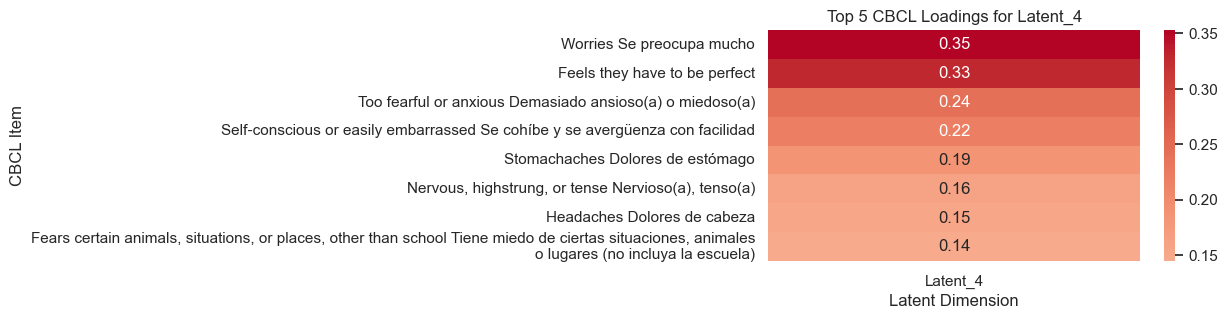

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_13076\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


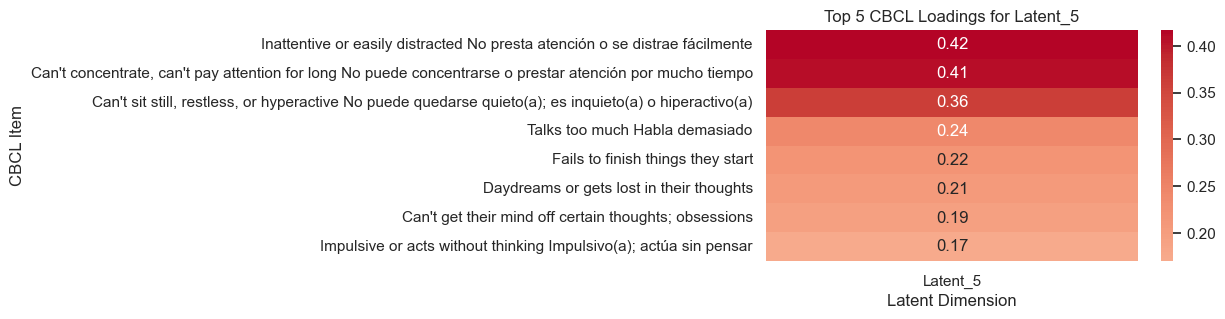

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set(style='whitegrid')

# 遍历每一列（latent）
for col in loadings_df.columns:
    # 获取当前列绝对值最大的前5个特征（CBCL item）
    top5 = loadings_df[col].abs().sort_values(ascending=False).head(8).index
    top5_data = loadings_df.loc[top5, [col]]

    # 绘图
    plt.figure(figsize=(6, 3))  # 每张图小一些方便展示
    sns.heatmap(top5_data, annot=True, cmap='coolwarm', center=0, cbar=True)
    plt.title(f"Top 5 CBCL Loadings for {col}")
    plt.xlabel("Latent Dimension")
    plt.ylabel("CBCL Item")
    plt.tight_layout()
    plt.show()

In [63]:
summary_rows = []

for col in loadings_df.columns:
    top5 = loadings_df[col].abs().nlargest(5)
    for idx in top5.index:
        summary_rows.append({
            'Factor': col,
            'Variable': idx,
            'Loading': loadings_df.loc[idx, col]
        })

summary_df = pd.DataFrame(summary_rows)
print(summary_df)


      Factor                                           Variable   Loading
0   Latent_1  Can't concentrate, can't pay attention for lon... -0.164157
1   Latent_1  Inattentive or easily distracted No presta ate... -0.159278
2   Latent_1          Bites fingernails Se come/muerde las uñas  0.142907
3   Latent_1  Can't sit still, restless, or hyperactive No p... -0.117904
4   Latent_1                  Fails to finish things they start -0.097824
5   Latent_2                         Argues a lot Discute mucho  0.199526
6   Latent_2  Inattentive or easily distracted No presta ate...  0.189930
7   Latent_2  Stubborn, sullen, or irritable Obstinado(a), m...  0.166911
8   Latent_2  Can't concentrate, can't pay attention for lon...  0.163669
9   Latent_2             Disobedient at home Desobedece en casa  0.162377
10  Latent_3          Bites fingernails Se come/muerde las uñas -0.145510
11  Latent_3  Self-conscious or easily embarrassed Se cohíbe...  0.108494
12  Latent_3                      Feel

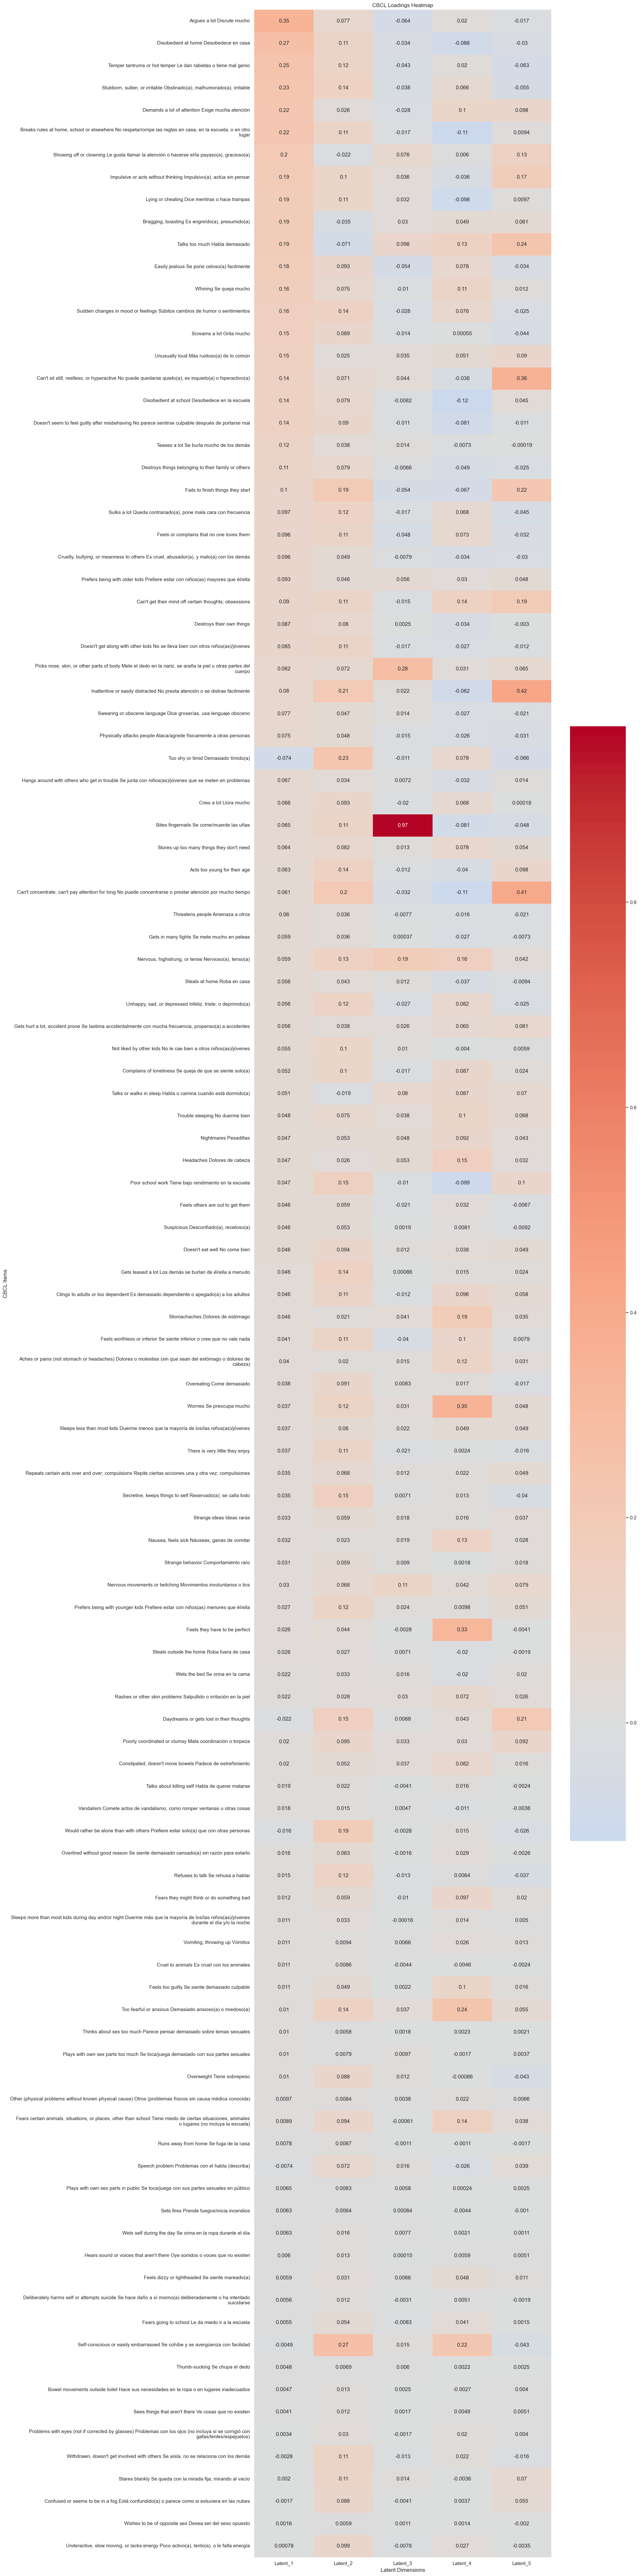

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 80))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("CBCL Loadings Heatmap")
plt.xlabel("Latent Dimensions")
plt.ylabel("CBCL Items")
plt.tight_layout()
plt.show()


In [261]:
z_all = autoencoder.get_latent_representation(X_scaled)
print("每个因子的激活均值：", z_all.mean(axis=0))


NameError: name 'autoencoder' is not defined

In [262]:
z_all = autoencoder.get_latent_representation(X_train)
import seaborn as sns
sns.heatmap(np.corrcoef(z_all.T))


NameError: name 'autoencoder' is not defined

In [16]:
latent_factors = autoencoder.get_latent_representation(X_scaled)
latent_factors.shape

(11331, 5)

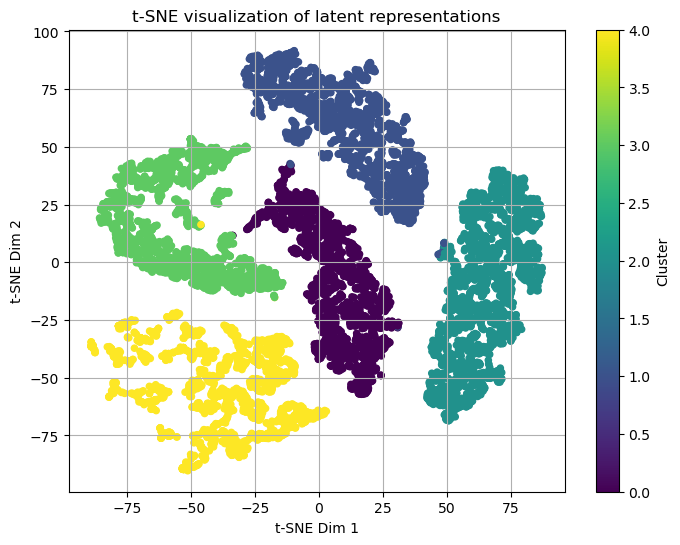

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(latent_factors)
# 获取聚类结果
with torch.no_grad():
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    _, _, p = autoencoder.model(X_tensor)
    cluster_labels = torch.argmax(p, dim=1).cpu().numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=20)
plt.title("t-SNE visualization of latent representations")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


c:\Anaconda\envs\mne\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda\envs\mne\Lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_20776\2694356937.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use th

<Figure size 640x480 with 0 Axes>

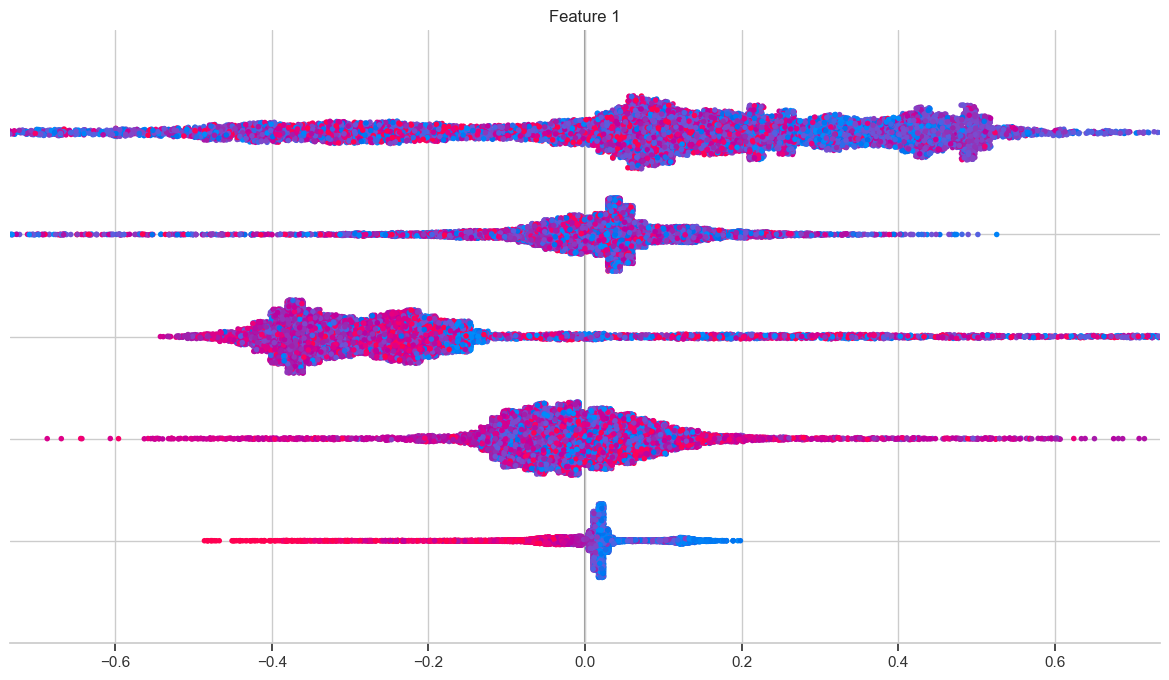

In [77]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import shap

# 1. 聚类标签作为伪 y
kmeans = KMeans(n_clusters=5, random_state=0).fit(latent_factors)
y_fake = kmeans.labels_

# 2. 用 ICA 成分预测这些伪标签
clf = RandomForestClassifier().fit(independent_components, y_fake)

# 3. 用 SHAP 分析
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(independent_components)
shap.summary_plot(shap_values, independent_components)



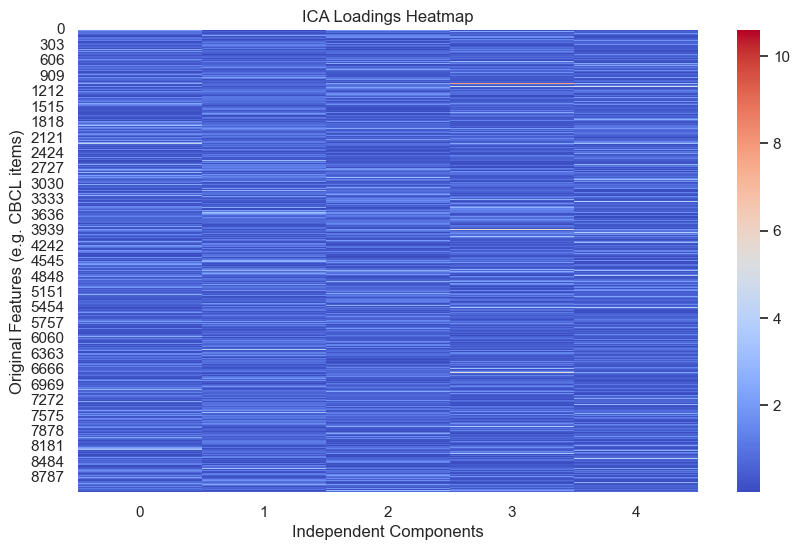

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 A_ 是 ICA 的 mixing matrix：shape (original_features, components)
plt.figure(figsize=(10, 6))
sns.heatmap(np.abs(independent_components), cmap='coolwarm', annot=False, cbar=True)
plt.xlabel("Independent Components")
plt.ylabel("Original Features (e.g. CBCL items)")
plt.title("ICA Loadings Heatmap")
plt.show()


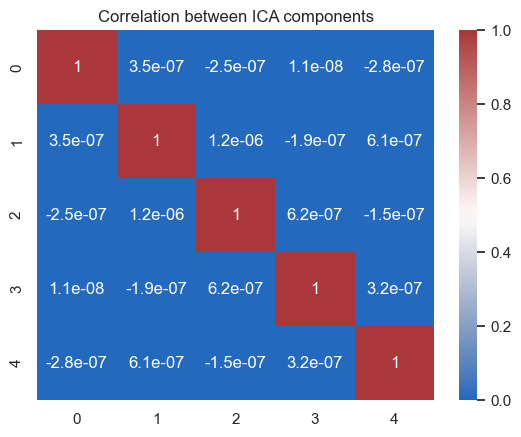

In [80]:
import pandas as pd
import seaborn as sns

df_ic = pd.DataFrame(independent_components)
sns.heatmap(df_ic.corr(), cmap="vlag", annot=True)
plt.title("Correlation between ICA components")
plt.show()


In [99]:
full_model

FactorVAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=114, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=32, out_features=20, bias=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=128, out_features=114, bias=True)
    )
  )
)

In [264]:
ae_model

SimpleVAE(
  (encoder): SimpleEncoder(
    (fc): Linear(in_features=114, out_features=10, bias=True)
  )
  (decoder): SimpleDecoder(
    (fc): Linear(in_features=5, out_features=114, bias=True)
  )
)

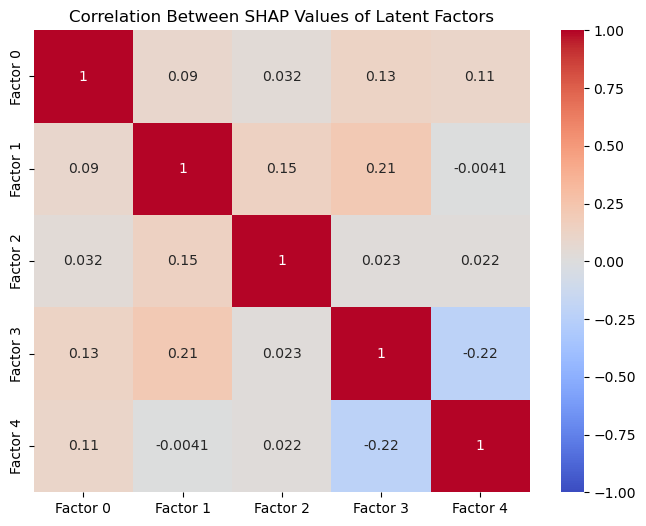

In [19]:
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 封装 autoencoder 的 encoder 部分为一个 nn.Module 对象
class EncoderWrapper(nn.Module):
    def __init__(self, model):
        super(EncoderWrapper, self).__init__()
        self.model = model  # 传入整个 autoencoder 模型

    def forward(self, x):

        output = self.model.encoder(x)  # 只返回编码器输出
        return output.clone()  # 返回编码器输出的副本
# 获取完整模型并封装 encoder
full_model = autoencoder.model
encoder_model = EncoderWrapper(full_model)
encoder_model.to(device)
encoder_model.eval()
for m in full_model.encoder.modules():
    # if you used nn.ReLU(inplace=True), switch it off
    if isinstance(m, torch.nn.ReLU):
        m.inplace = False
# 随机选取 100 个背景样本，保证背景数据与模型输入特征一致
background = X_train[np.random.choice(X_train.shape[0], 500, replace=False)]

# 构建 SHAP DeepExplainer，注意将背景数据转换为 tensor 并移至相同设备
explainer = shap.DeepExplainer(encoder_model, 
                               torch.tensor(background, dtype=torch.float32).to(device))

# 计算前 20 个测试样本的 SHAP 值
shap_values = explainer.shap_values(torch.tensor(X_test[:20], dtype=torch.float32).to(device))

# 将 latent_dim 向量分别 flatten 为 (n_samples × n_features) 的一列，用于计算 pairwise correlation
latent_dim = shap_values.shape[2]
shap_flat = []

for i in range(latent_dim):
    # 每一列是 flatten 后的第 i 个因子的 SHAP 值
    flattened = shap_values[:, :, i].reshape(-1)
    shap_flat.append(flattened)

# 构成 DataFrame：每列代表一个因子
shap_df = pd.DataFrame(np.array(shap_flat).T, columns=[f"Factor {i}" for i in range(latent_dim)])

# 计算 Pearson 相关性矩阵
corr_matrix = shap_df.corr(method='pearson')

# 可视化
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between SHAP Values of Latent Factors")
plt.show()


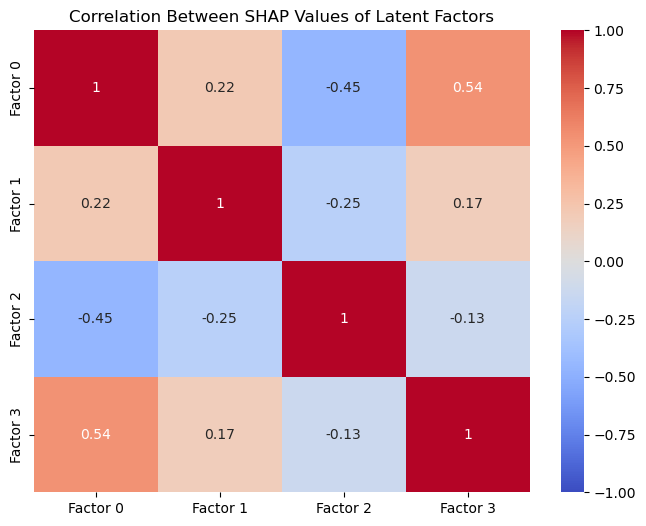

In [26]:
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 封装 autoencoder 的 encoder 部分为一个 nn.Module 对象
class EncoderWrapper(nn.Module):
    def __init__(self, model):
        super(EncoderWrapper, self).__init__()
        self.model = model  # 传入整个 autoencoder 模型

    def forward(self, x):
        return self.model.encode(x)  # 只返回编码器输出

# 获取完整模型并封装 encoder
full_model = autoencoder.model
encoder_model = EncoderWrapper(full_model)
encoder_model.to(device)
encoder_model.eval()

# 随机选取 100 个背景样本，保证背景数据与模型输入特征一致
background = X_train[np.random.choice(X_train.shape[0], 500, replace=False)]

# 构建 SHAP DeepExplainer，注意将背景数据转换为 tensor 并移至相同设备
explainer = shap.DeepExplainer(encoder_model, 
                               torch.tensor(background, dtype=torch.float32).to(device))

# 计算前 20 个测试样本的 SHAP 值
shap_values = explainer.shap_values(torch.tensor(X_test[:20], dtype=torch.float32).to(device))
# 将 latent_dim 向量分别 flatten 为 (n_samples × n_features) 的一列，用于计算 pairwise correlation
latent_dim = shap_values.shape[2]
shap_flat = []

for i in range(latent_dim):
    # 每一列是 flatten 后的第 i 个因子的 SHAP 值
    flattened = shap_values[:, :, i].reshape(-1)
    shap_flat.append(flattened)

# 构成 DataFrame：每列代表一个因子
shap_df = pd.DataFrame(np.array(shap_flat).T, columns=[f"Factor {i}" for i in range(latent_dim)])

# 计算 Pearson 相关性矩阵
corr_matrix = shap_df.corr(method='pearson')

# 可视化
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between SHAP Values of Latent Factors")
plt.show()


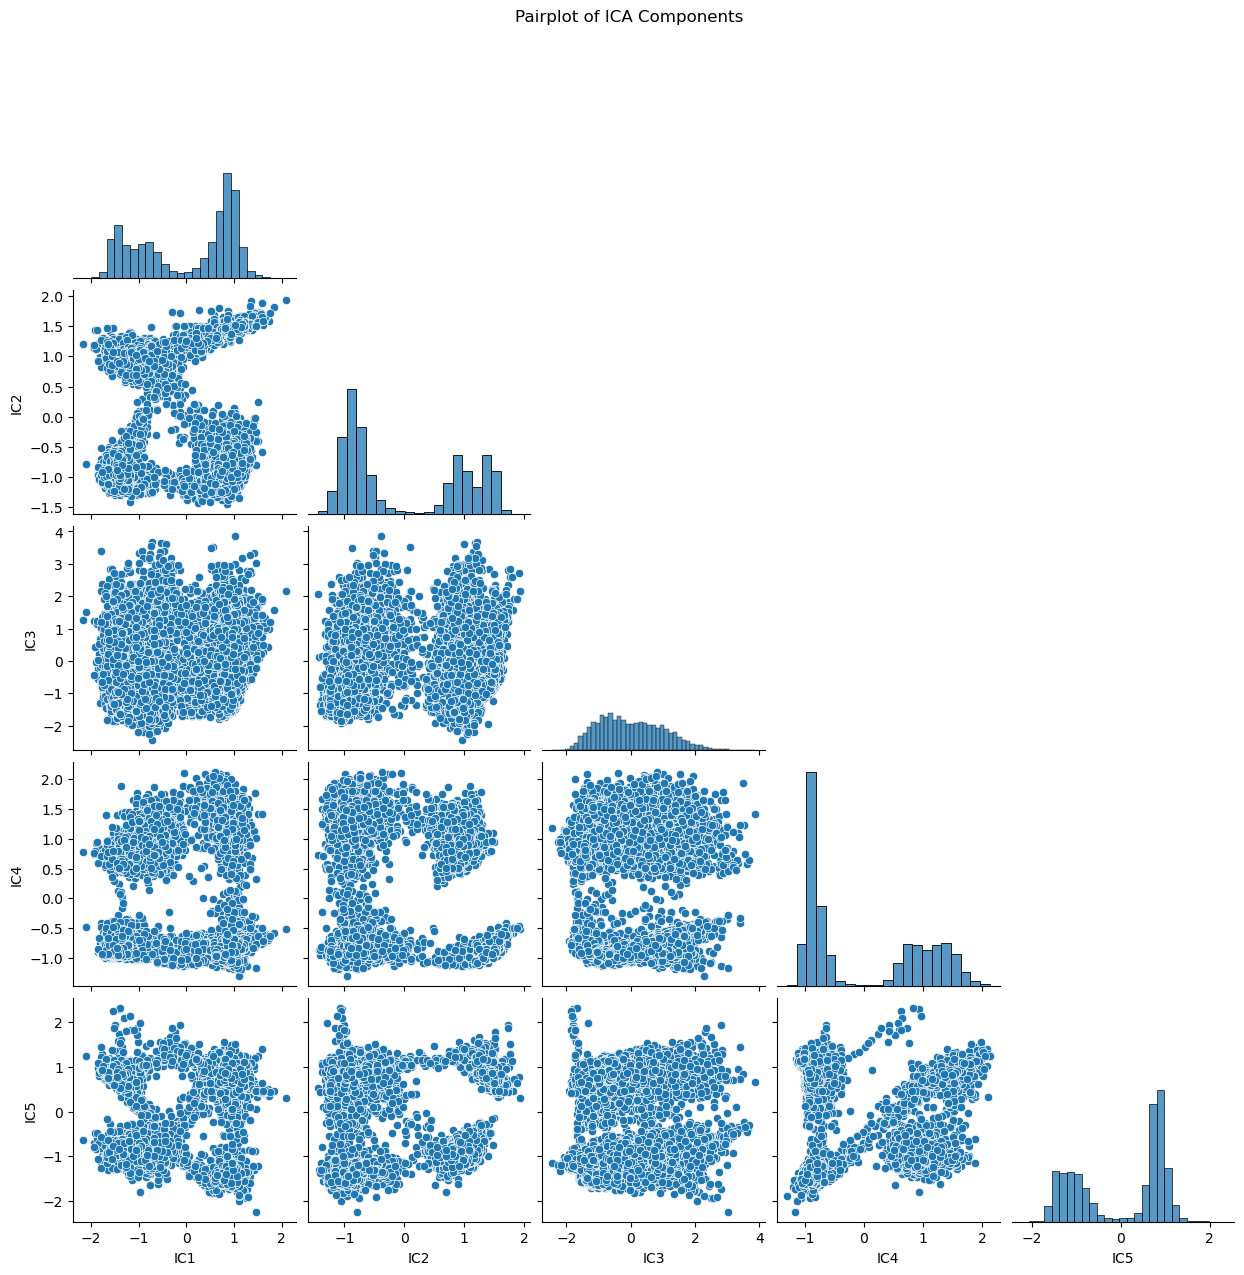

In [101]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=5, random_state=42)
independent_components = ica.fit_transform(latent_factors)
mixing_matrix = ica.mixing_         # shape: (5, 5)
unmixing_matrix = ica.components_   # shape: (5, 5)

import pandas as pd
import seaborn as sns

# 转成 DataFrame
ica_df = pd.DataFrame(independent_components, columns=[f'IC{i+1}' for i in range(5)])

# 可视化
sns.pairplot(ica_df, corner=True)
plt.suptitle("Pairplot of ICA Components", y=1.02)
plt.show()


In [102]:
print("Mixing matrix shape:", ica.mixing_.shape)
print("Mixing matrix:\n", ica.mixing_)


Mixing matrix shape: (5, 5)
Mixing matrix:
 [[ 0.3165617  -0.2194724  -0.14235891 -0.7482894  -0.4207567 ]
 [-0.01309753  0.00941494  0.27136377 -0.5122733   0.76531637]
 [ 0.7754739   0.16467021  0.4739514   0.19332653 -0.04198658]
 [ 0.46256724 -0.07926888 -0.71061397  0.15562537  0.38607177]
 [ 0.02709818 -0.9130338   0.19564727  0.20013352  0.07737396]]


In [55]:
def objective(trial):
    # 读取数据
    code_dir = Path(os.getcwd())
    data_path = code_dir.parent / "data"
    assert os.path.exists(data_path), "Cannot find data folder, please run the code in root directory of the project."
    
    qns = pd.read_csv(data_path / "cbcl_data_remove_unrelated.csv", encoding="utf-8")
    X = qns.iloc[:, 2:].values
    # Optuna 搜索的参数范围
    layer1_neurons = trial.suggest_int("layer1_neurons", 50, 200)
    layer2_neurons = trial.suggest_int("layer2_neurons", 50, 200)
    layer3_neurons = trial.suggest_int("layer3_neurons", 50, 200)
    layer4_neurons = trial.suggest_int("layer4_neurons", 50, 200)

    # 外层 CV
    outer_cv = KFold(n_splits=2, shuffle=True)
    outer_scores = []

    for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X), start=1):
        print(f"====== Outer Fold {outer_fold} ======")
        X_outer_train_raw, X_outer_test_raw = X[outer_train_idx], X[outer_test_idx]
        
        scaler_fold = MinMaxScaler()
        X_outer_train = scaler_fold.fit_transform(X_outer_train_raw)
        X_outer_test = scaler_fold.transform(X_outer_test_raw)
        
        # 内层 CV
        inner_cv = KFold(n_splits=2, shuffle=True)
        inner_scores = []

        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_outer_train), start=1):
            print(f"  -- Inner Fold {inner_fold}")
            X_inner_train = X_outer_train[inner_train_idx]
            X_inner_val = X_outer_train[inner_val_idx]
            
            autoencoder_inner = Autoencoder(
                X_inner_train,
                X_inner_val,
                encoding_dim=5,
                layer1_neurons=layer1_neurons,
                layer2_neurons=layer2_neurons,
                layer3_neurons=layer3_neurons,
                layer4_neurons=layer4_neurons,
            )
            
            autoencoder_inner.train()
            _, inner_score, _, inner_variance_explained = autoencoder_inner.evaluate_on_data(X_inner_val)
            inner_score = inner_score.mean()
            print(f"Inner fold reconstruction error: {inner_score}")
            print(f"Inner fold explained variance ratio: {inner_variance_explained}")
            inner_scores.append(inner_score)
        
        avg_inner_score = np.mean(inner_scores)
        print(f"Average inner CV score for outer fold {outer_fold}: {avg_inner_score}")
        
        # 用整个 outer train 再训练一次，在 outer test 上评估
        autoencoder_outer = Autoencoder(
            X_outer_train,
            X_outer_test,
            encoding_dim=5,
            layer1_neurons=layer1_neurons,
            layer2_neurons=layer2_neurons,
            layer3_neurons=layer3_neurons,
            layer4_neurons=layer4_neurons,
        )
        autoencoder_outer.train()
        _, outer_score, _, outer_variance_explained = autoencoder_outer.evaluate_on_data(X_outer_test)
        outer_score = outer_score.mean()
        print(f"Outer fold {outer_fold} test reconstruction error: {outer_score}")
        print(f"Outer fold {outer_fold} explained variance ratio: {outer_variance_explained}")
        outer_scores.append(outer_score)

    final_avg_score = np.mean(outer_scores)
    print("Final average test reconstruction error:", final_avg_score)

    return final_avg_score

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=15)

    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:", study.best_trial.params)

[I 2025-04-07 19:18:10,222] A new study created in memory with name: no-name-bf5a17ac-ce47-4817-b6ee-ee230d5cff9b


====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 84
Inner fold reconstruction error: 0.025933561846613884
Inner fold explained variance ratio: 0.3841517230030941
  -- Inner Fold 2
Early stopping at epoch 78
Inner fold reconstruction error: 0.025770053267478943
Inner fold explained variance ratio: 0.3889043813710389
Average inner CV score for outer fold 1: 0.025851808488368988
Early stopping at epoch 72
Outer fold 1 test reconstruction error: 0.024751322343945503
Outer fold 1 explained variance ratio: 0.4013496238900852
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 71
Inner fold reconstruction error: 0.02503691427409649
Inner fold explained variance ratio: 0.38681762298658
  -- Inner Fold 2
Early stopping at epoch 72
Inner fold reconstruction error: 0.026439674198627472
Inner fold explained variance ratio: 0.3626451037373667
Average inner CV score for outer fold 2: 0.025738295167684555


[I 2025-04-07 19:23:15,476] Trial 0 finished with value: 0.025017041712999344 and parameters: {'layer1_neurons': 180, 'layer2_neurons': 180, 'layer3_neurons': 170, 'layer4_neurons': 100}. Best is trial 0 with value: 0.025017041712999344.


Early stopping at epoch 70
Outer fold 2 test reconstruction error: 0.025282761082053185
Outer fold 2 explained variance ratio: 0.3931470177918337
Final average test reconstruction error: 0.025017042
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 104
Inner fold reconstruction error: 0.02588362991809845
Inner fold explained variance ratio: 0.36703432366374955
  -- Inner Fold 2
Early stopping at epoch 108
Inner fold reconstruction error: 0.02625611424446106
Inner fold explained variance ratio: 0.3773535355428045
Average inner CV score for outer fold 1: 0.026069872081279755
Early stopping at epoch 96
Outer fold 1 test reconstruction error: 0.024480782449245453
Outer fold 1 explained variance ratio: 0.3930977763845895
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 118
Inner fold reconstruction error: 0.02511564828455448
Inner fold explained variance ratio: 0.3790315681309928
  -- Inner Fold 2
Early stopping at epoch 115
Inner fold reconstruction e

[I 2025-04-07 19:30:20,594] Trial 1 finished with value: 0.0249042771756649 and parameters: {'layer1_neurons': 54, 'layer2_neurons': 132, 'layer3_neurons': 112, 'layer4_neurons': 70}. Best is trial 1 with value: 0.0249042771756649.


Early stopping at epoch 92
Outer fold 2 test reconstruction error: 0.0253277737647295
Outer fold 2 explained variance ratio: 0.38465347094880364
Final average test reconstruction error: 0.024904277
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 97
Inner fold reconstruction error: 0.02576451562345028
Inner fold explained variance ratio: 0.376265162188683
  -- Inner Fold 2
Early stopping at epoch 98
Inner fold reconstruction error: 0.025658082216978073
Inner fold explained variance ratio: 0.36994009975552217
Average inner CV score for outer fold 1: 0.0257112979888916
Early stopping at epoch 102
Outer fold 1 test reconstruction error: 0.024834804236888885
Outer fold 1 explained variance ratio: 0.39569202562597344
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 80
Inner fold reconstruction error: 0.026387864723801613
Inner fold explained variance ratio: 0.35555446040647615
  -- Inner Fold 2
Early stopping at epoch 83
Inner fold reconstruction erro

[I 2025-04-07 19:36:49,589] Trial 2 finished with value: 0.024870101362466812 and parameters: {'layer1_neurons': 115, 'layer2_neurons': 153, 'layer3_neurons': 50, 'layer4_neurons': 166}. Best is trial 2 with value: 0.024870101362466812.


Early stopping at epoch 93
Outer fold 2 test reconstruction error: 0.02490539848804474
Outer fold 2 explained variance ratio: 0.3962062423377248
Final average test reconstruction error: 0.024870101
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 103
Inner fold reconstruction error: 0.025778209790587425
Inner fold explained variance ratio: 0.38255372781561814
  -- Inner Fold 2
Early stopping at epoch 91
Inner fold reconstruction error: 0.025308361276984215
Inner fold explained variance ratio: 0.38683515613186
Average inner CV score for outer fold 1: 0.02554328553378582
Early stopping at epoch 79
Outer fold 1 test reconstruction error: 0.025279289111495018
Outer fold 1 explained variance ratio: 0.3989090381545376
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 73
Inner fold reconstruction error: 0.026046667248010635
Inner fold explained variance ratio: 0.3791259635642317
  -- Inner Fold 2
Early stopping at epoch 81
Inner fold reconstruction error

[I 2025-04-07 19:42:21,432] Trial 3 finished with value: 0.024998068809509277 and parameters: {'layer1_neurons': 164, 'layer2_neurons': 122, 'layer3_neurons': 141, 'layer4_neurons': 58}. Best is trial 2 with value: 0.024870101362466812.


Early stopping at epoch 67
Outer fold 2 test reconstruction error: 0.024716846644878387
Outer fold 2 explained variance ratio: 0.3888693925622205
Final average test reconstruction error: 0.024998069
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 74
Inner fold reconstruction error: 0.025369474664330482
Inner fold explained variance ratio: 0.38672244695825675
  -- Inner Fold 2
Early stopping at epoch 76
Inner fold reconstruction error: 0.026108242571353912
Inner fold explained variance ratio: 0.3800809330691126
Average inner CV score for outer fold 1: 0.025738857686519623
Early stopping at epoch 69
Outer fold 1 test reconstruction error: 0.024910228326916695
Outer fold 1 explained variance ratio: 0.39785373297932214
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 80
Inner fold reconstruction error: 0.02535296604037285
Inner fold explained variance ratio: 0.38099098088563166
  -- Inner Fold 2
Early stopping at epoch 72
Inner fold reconstruction e

[I 2025-04-07 19:47:19,608] Trial 4 finished with value: 0.025019951164722443 and parameters: {'layer1_neurons': 182, 'layer2_neurons': 188, 'layer3_neurons': 146, 'layer4_neurons': 146}. Best is trial 2 with value: 0.024870101362466812.


Early stopping at epoch 67
Outer fold 2 test reconstruction error: 0.02512967213988304
Outer fold 2 explained variance ratio: 0.3984564708069355
Final average test reconstruction error: 0.025019951
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 86
Inner fold reconstruction error: 0.025683460757136345
Inner fold explained variance ratio: 0.382558734520624
  -- Inner Fold 2
Early stopping at epoch 76
Inner fold reconstruction error: 0.02585715427994728
Inner fold explained variance ratio: 0.3823293062178643
Average inner CV score for outer fold 1: 0.02577030658721924
Early stopping at epoch 74
Outer fold 1 test reconstruction error: 0.024680742993950844
Outer fold 1 explained variance ratio: 0.392334824633223
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 72
Inner fold reconstruction error: 0.025304151698946953
Inner fold explained variance ratio: 0.3709620007268243
  -- Inner Fold 2
Early stopping at epoch 75
Inner fold reconstruction error: 0

[I 2025-04-07 19:52:29,650] Trial 5 finished with value: 0.024820685386657715 and parameters: {'layer1_neurons': 138, 'layer2_neurons': 179, 'layer3_neurons': 191, 'layer4_neurons': 165}. Best is trial 5 with value: 0.024820685386657715.


Early stopping at epoch 70
Outer fold 2 test reconstruction error: 0.024960625916719437
Outer fold 2 explained variance ratio: 0.3988110425662253
Final average test reconstruction error: 0.024820685
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 81
Inner fold reconstruction error: 0.025347266346216202
Inner fold explained variance ratio: 0.37183258651437884
  -- Inner Fold 2
Early stopping at epoch 74
Inner fold reconstruction error: 0.025595443323254585
Inner fold explained variance ratio: 0.3791237626125979
Average inner CV score for outer fold 1: 0.025471355766057968
Early stopping at epoch 81
Outer fold 1 test reconstruction error: 0.025160836055874825
Outer fold 1 explained variance ratio: 0.3913699904622543
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 85
Inner fold reconstruction error: 0.02599073201417923
Inner fold explained variance ratio: 0.38426618364203674
  -- Inner Fold 2
Early stopping at epoch 93
Inner fold reconstruction er

[I 2025-04-07 19:58:17,283] Trial 6 finished with value: 0.024896562099456787 and parameters: {'layer1_neurons': 101, 'layer2_neurons': 110, 'layer3_neurons': 141, 'layer4_neurons': 188}. Best is trial 5 with value: 0.024820685386657715.


Early stopping at epoch 88
Outer fold 2 test reconstruction error: 0.0246322862803936
Outer fold 2 explained variance ratio: 0.3873289862656503
Final average test reconstruction error: 0.024896562
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 103
Inner fold reconstruction error: 0.026158897206187248
Inner fold explained variance ratio: 0.3778503887673528
  -- Inner Fold 2
Early stopping at epoch 105
Inner fold reconstruction error: 0.025944186374545097
Inner fold explained variance ratio: 0.3661263968101245
Average inner CV score for outer fold 1: 0.026051541790366173
Early stopping at epoch 98
Outer fold 1 test reconstruction error: 0.02457382157444954
Outer fold 1 explained variance ratio: 0.3855219030230929
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 100
Inner fold reconstruction error: 0.025520481169223785
Inner fold explained variance ratio: 0.3763844797085864
  -- Inner Fold 2
Early stopping at epoch 113
Inner fold reconstruction er

[I 2025-04-07 20:05:23,722] Trial 7 finished with value: 0.02485886588692665 and parameters: {'layer1_neurons': 66, 'layer2_neurons': 108, 'layer3_neurons': 68, 'layer4_neurons': 93}. Best is trial 5 with value: 0.024820685386657715.


Early stopping at epoch 103
Outer fold 2 test reconstruction error: 0.025143910199403763
Outer fold 2 explained variance ratio: 0.39224988121703935
Final average test reconstruction error: 0.024858866
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 77
Inner fold reconstruction error: 0.025294730439782143
Inner fold explained variance ratio: 0.3813970274279528
  -- Inner Fold 2
Early stopping at epoch 94
Inner fold reconstruction error: 0.025810327380895615
Inner fold explained variance ratio: 0.3776664314164277
Average inner CV score for outer fold 1: 0.025552529841661453
Early stopping at epoch 66
Outer fold 1 test reconstruction error: 0.02509455196559429
Outer fold 1 explained variance ratio: 0.3883931398515058
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 85
Inner fold reconstruction error: 0.025792771950364113
Inner fold explained variance ratio: 0.3880229776385264
  -- Inner Fold 2
Early stopping at epoch 85
Inner fold reconstruction er

[I 2025-04-07 20:10:57,920] Trial 8 finished with value: 0.024952366948127747 and parameters: {'layer1_neurons': 116, 'layer2_neurons': 95, 'layer3_neurons': 197, 'layer4_neurons': 120}. Best is trial 5 with value: 0.024820685386657715.


Early stopping at epoch 82
Outer fold 2 test reconstruction error: 0.0248101819306612
Outer fold 2 explained variance ratio: 0.39140690449019466
Final average test reconstruction error: 0.024952367
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 72
Inner fold reconstruction error: 0.02507459558546543
Inner fold explained variance ratio: 0.3775727314378347
  -- Inner Fold 2
Early stopping at epoch 78
Inner fold reconstruction error: 0.025741862133145332
Inner fold explained variance ratio: 0.40264753230269884
Average inner CV score for outer fold 1: 0.025408228859305382
Early stopping at epoch 72
Outer fold 1 test reconstruction error: 0.025133652612566948
Outer fold 1 explained variance ratio: 0.38955721425644535
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 80
Inner fold reconstruction error: 0.025721019133925438
Inner fold explained variance ratio: 0.3830691867018158
  -- Inner Fold 2
Early stopping at epoch 72
Inner fold reconstruction err

[I 2025-04-07 20:16:31,129] Trial 9 finished with value: 0.02495731972157955 and parameters: {'layer1_neurons': 166, 'layer2_neurons': 90, 'layer3_neurons': 151, 'layer4_neurons': 174}. Best is trial 5 with value: 0.024820685386657715.


Early stopping at epoch 66
Outer fold 2 test reconstruction error: 0.024780986830592155
Outer fold 2 explained variance ratio: 0.39885787329476347
Final average test reconstruction error: 0.02495732
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 102
Inner fold reconstruction error: 0.0263731200248003
Inner fold explained variance ratio: 0.35707619626297293
  -- Inner Fold 2
Early stopping at epoch 93
Inner fold reconstruction error: 0.025166679173707962
Inner fold explained variance ratio: 0.3767279199574371
Average inner CV score for outer fold 1: 0.025769900530576706
Early stopping at epoch 74
Outer fold 1 test reconstruction error: 0.02532818354666233
Outer fold 1 explained variance ratio: 0.38903100345227476
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 75
Inner fold reconstruction error: 0.02632283791899681
Inner fold explained variance ratio: 0.3815719787544033
  -- Inner Fold 2
Early stopping at epoch 87
Inner fold reconstruction erro

[I 2025-04-07 20:22:45,329] Trial 10 finished with value: 0.025002870708703995 and parameters: {'layer1_neurons': 139, 'layer2_neurons': 52, 'layer3_neurons': 200, 'layer4_neurons': 143}. Best is trial 5 with value: 0.024820685386657715.


Early stopping at epoch 85
Outer fold 2 test reconstruction error: 0.02467755787074566
Outer fold 2 explained variance ratio: 0.391674626106777
Final average test reconstruction error: 0.02500287
====== Outer Fold 1 ======
  -- Inner Fold 1
Early stopping at epoch 83
Inner fold reconstruction error: 0.0258087906986475
Inner fold explained variance ratio: 0.38355806236474493
  -- Inner Fold 2
Early stopping at epoch 101
Inner fold reconstruction error: 0.025497140362858772
Inner fold explained variance ratio: 0.3774379800057924
Average inner CV score for outer fold 1: 0.025652965530753136
Early stopping at epoch 92
Outer fold 1 test reconstruction error: 0.0248387660831213
Outer fold 1 explained variance ratio: 0.38700028237553696
====== Outer Fold 2 ======
  -- Inner Fold 1
Early stopping at epoch 85
Inner fold reconstruction error: 0.025596173480153084
Inner fold explained variance ratio: 0.36855045157490796
  -- Inner Fold 2
Early stopping at epoch 116
Inner fold reconstruction error

[W 2025-04-07 20:28:17,468] Trial 11 failed with parameters: {'layer1_neurons': 73, 'layer2_neurons': 153, 'layer3_neurons': 86, 'layer4_neurons': 98} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Anaconda\envs\mne\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_18708\3091074461.py", line 66, in objective
    autoencoder_outer.train()
  File "C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_18708\466509701.py", line 125, in train
    self.optimizer.step()
  File "c:\Anaconda\envs\mne\Lib\site-packages\torch\optim\optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Anaconda\envs\mne\Lib\site-packages\torch\optim\optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c

KeyboardInterrupt: 

In [56]:
if __name__ == "__main__":
    # study = optuna.create_study(direction="minimize")
    # study.optimize(objective, n_trials=50)

    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:", study.best_trial.params)

Best trial:
FrozenTrial(number=5, state=1, values=[0.024820685386657715], datetime_start=datetime.datetime(2025, 4, 7, 19, 47, 19, 609994), datetime_complete=datetime.datetime(2025, 4, 7, 19, 52, 29, 650268), params={'layer1_neurons': 138, 'layer2_neurons': 179, 'layer3_neurons': 191, 'layer4_neurons': 165}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layer1_neurons': IntDistribution(high=200, log=False, low=50, step=1), 'layer2_neurons': IntDistribution(high=200, log=False, low=50, step=1), 'layer3_neurons': IntDistribution(high=200, log=False, low=50, step=1), 'layer4_neurons': IntDistribution(high=200, log=False, low=50, step=1)}, trial_id=5, value=None)
Best hyperparameters: {'layer1_neurons': 138, 'layer2_neurons': 179, 'layer3_neurons': 191, 'layer4_neurons': 165}


In [20]:
%matplotlib inline
# model = autoencoder.get_model().encoder
# model =model.Encoder()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(model, torch.tensor(background, dtype=torch.float32).to(device), )

# 计算 SHAP 值
shap_values = explainer.shap_values(torch.tensor(X_test[:20], dtype=torch.float32).to(device))

NameError: name 'model' is not defined

In [ ]:
from utils import get_cbcl_details
items = [get_cbcl_details(col) for col in qns.iloc[:, 1:].columns]

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_17592\3011981108.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,i], X_test[:20], feature_names=items, show=False)
c:\Anaconda\envs\mne\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_17592\3011981108.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,i], X_test[:20], feature_names=items, show=False)
c:\Anaconda\en

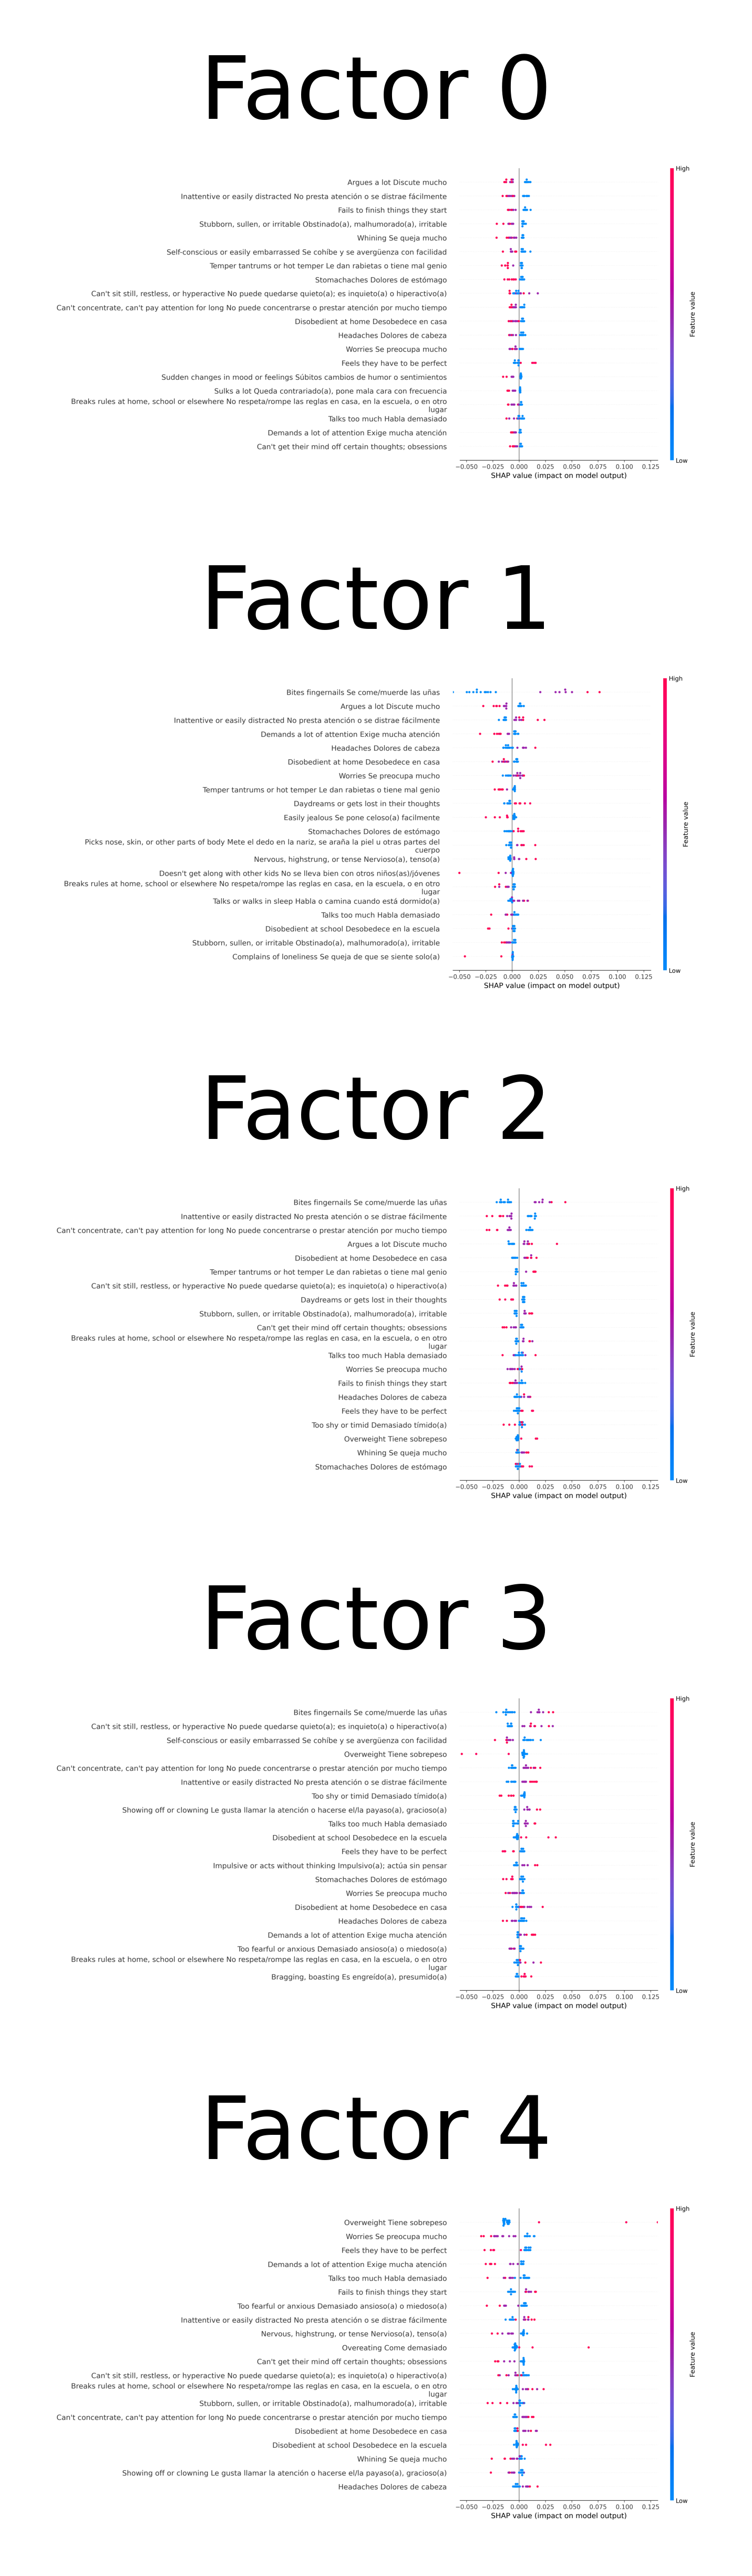

In [21]:
import shap
import matplotlib.pyplot as plt
import io
from PIL import Image

# We'll store each SHAP summary_plot as an in-memory PNG, then display them
images = []

for i in range(5):
    # 1) Create the SHAP summary plot on a brand-new figure
    shap.summary_plot(shap_values[:,:,i], X_test[:20], feature_names=items, show=False)
    plt.xlim(shap_values.min(), shap_values.max())
    
    # 2) Grab that just-created figure object
    tmp_fig = plt.gcf()
    
    # 3) Save it to a buffer in PNG format
    buf = io.BytesIO()
    tmp_fig.savefig(buf, format='png', bbox_inches='tight', dpi=300)
    buf.seek(0)
    
    # 4) Convert buffer -> PIL image and store
    images.append(Image.open(buf))
    
    # 5) Close that figure to avoid overlapping the next iteration
    plt.close(tmp_fig)

# Now create a single "master" figure of 1 row × 4 columns
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20,5), dpi=1000)

for idx, ax in enumerate(axes):
    # 6) Display each PIL image in its own subplot
    ax.imshow(images[idx])
    ax.set_axis_off()
    ax.set_title(f"Factor {idx}")

plt.tight_layout()
plt.show()


In [68]:
import numpy as np
import pandas as pd

# 初始化结果字典
shap_summary_dict = {}

for i in range(shap_values.shape[2]):  # 对每个 factor
    # 取第 i 个 latent factor 的 SHAP 值（所有样本 × 所有输入特征）
    shap_i = shap_values[:, :, i]

    # 计算平均绝对值贡献（每列取平均）
    mean_abs_shap = np.mean(np.abs(shap_i), axis=0)

    # 加入结果字典
    shap_summary_dict[f"z{i+1}"] = mean_abs_shap

# 拼成 DataFrame
shap_summary_df = pd.DataFrame(shap_summary_dict)
shap_summary_df.index = items  # 题目列名
shap_summary_df = shap_summary_df.round(4)

shap_summary_df

z1      z2      z3  \
Acts too young for their age                        0.0011  0.0012  0.0014   
Argues a lot Discute mucho                          0.0046  0.0090  0.0046   
Fails to finish things they start                   0.0052  0.0046  0.0055   
There is very little they enjoy                     0.0003  0.0006  0.0004   
Bowel movements outside toilet Hace sus necesid...  0.0001  0.0004  0.0003   
...                                                    ...     ...     ...   
Wets the bed Se orina en la cama                    0.0002  0.0004  0.0002   
Whining Se queja mucho                              0.0051  0.0055  0.0014   
Wishes to be of opposite sex Desea ser del sexo...  0.0000  0.0000  0.0000   
Withdrawn, doesn't get involved with others Se ...  0.0004  0.0003  0.0006   
Worries Se preocupa mucho                           0.0033  0.0037  0.0031   

                                                        z4      z5  
Acts too young for their age                        0.0028  0.0040  
Argues a lot Discute mucho                          0.0048  0.0106  
Fails to finish things they start                   0.0019  0.0035  
There is very little they enjoy                     0.0020  0.0019  
Bowel movements outside toilet Hace sus necesid...  0.0004  0.0003  
...                                                    ...     ...  
Wets the bed Se orina en la cama                    0.0005  0.0002  
Whining Se queja mucho                              0.0020  0.0019  
Wishes to be of opposite sex Desea ser del sexo...  0.0000  0.0000  
Withdrawn, doesn't get involved with others Se ...  0.0009  0.0013  
Worries Se preocupa mucho                           0.0078  0.0052  

[114 rows x 5 columns]

## coupling between latent factors and brain


In [50]:
#loading data mri_y_rsfmr_cor_gp_gp_reduced.csv
X = pd.read_csv('../data/mri_y_rsfmr_cor_gp_gp_reduced.csv')
y = autoencoder.get_latent_representation(X_scaled)


In [51]:
# 将y 的 index变得和qns一样
y = pd.DataFrame(y, columns=[f'z{i+1}' for i in range(encoding_dim)])
y.insert(0, 'src_subject_id', qns['src_subject_id'])
y

src_subject_id        z1        z2        z3        z4        z5
0      NDAR_INV003RTV85  1.695466  0.441841  1.257728  0.073835 -0.312454
1      NDAR_INV005V6D2C  0.611542 -0.584648 -1.729291  0.639216  0.833229
2      NDAR_INV007W6H7B  0.046896  0.196570 -0.432695 -1.637767 -1.284091
3      NDAR_INV00BD7VDC -0.047717  0.830602 -1.364371 -0.815839 -1.261323
4      NDAR_INV00CY2MDM -0.853960 -0.077876  1.128281 -0.741885  1.210628
...                 ...       ...       ...       ...       ...       ...
11326  NDAR_INVZZNX6W2P -1.061116 -0.846579 -0.129846  1.325475 -0.721905
11327  NDAR_INVZZPKBDAC  0.404521  0.076876 -1.987494  0.101776  1.245773
11328  NDAR_INVZZZ2ALR6 -0.515624 -1.620612  0.296924  0.816273 -1.012424
11329  NDAR_INVZZZNB0XC  0.006803  0.403159 -0.671674 -1.495016 -1.262918
11330  NDAR_INVZZZP87KR  1.080591 -1.080958 -0.802723 -0.908287  1.024961

[11331 rows x 6 columns]

In [52]:
#only kept overlapping subjects in X and y
X = X[X['src_subject_id'].isin(y['src_subject_id'])]
y = y[y['src_subject_id'].isin(X['src_subject_id'])]
# drop src_subject_id
# X = X.drop(columns=['src_subject_id'])
# y = y.drop(columns=['src_subject_id'])

In [32]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=1)
cca.fit(y, X)
Z_c, FC_c = cca.transform(y, X)  # 得到 canonical variates


Running bootstrap CCA...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


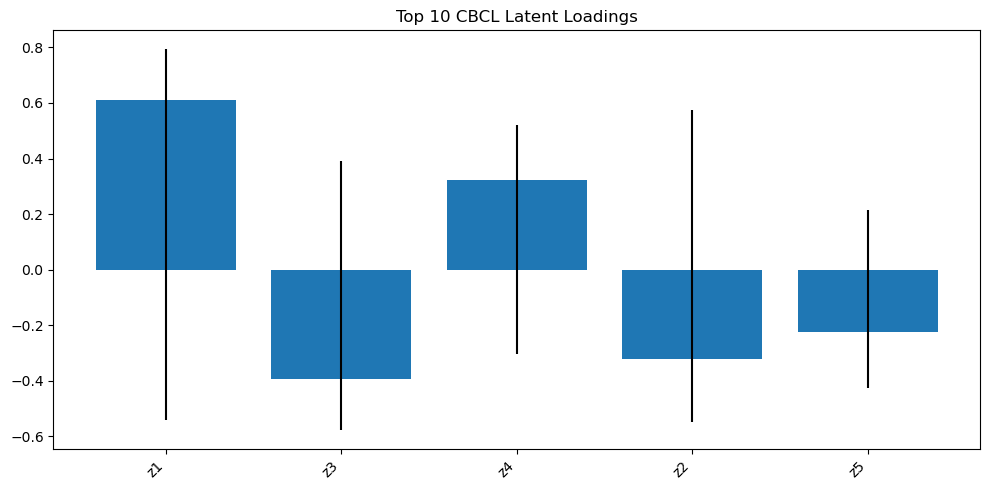

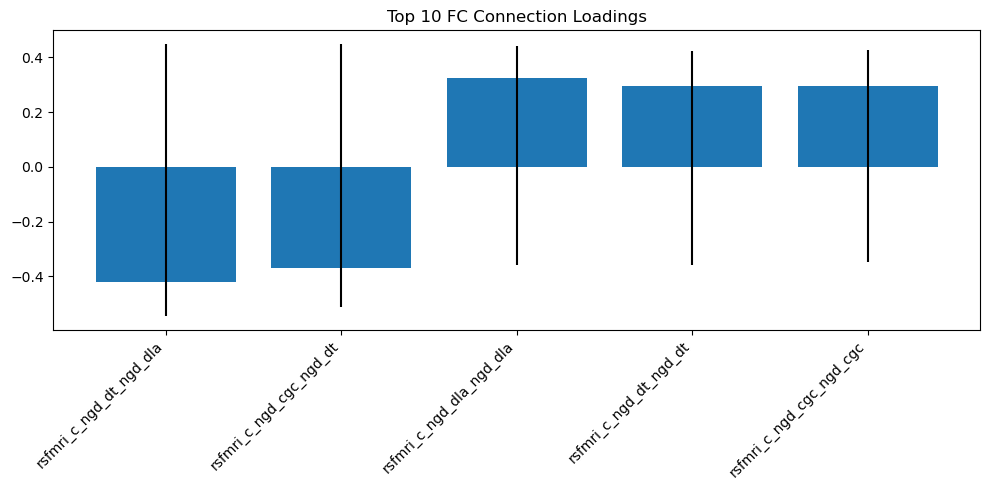

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

### === 1. 数据加载 === ###

Z_df = y
FC_df = X

Z = Z_df.values
FC = FC_df.values

cbcl_latent_names = Z_df.columns.tolist()
fc_names = FC_df.columns.tolist()

### === 2. 标准化 === ###
scaler_Z = StandardScaler()
scaler_FC = StandardScaler()
Z_scaled = scaler_Z.fit_transform(Z)
FC_scaled = scaler_FC.fit_transform(FC)

### === 3. CCA + Canonical Loading 计算 === ###
def run_cca_and_get_loadings(Z_sub, FC_sub):
    cca = CCA(n_components=1)
    cca.fit(Z_sub, FC_sub)
    Z_c, FC_c = cca.transform(Z_sub, FC_sub)

    cbcl_l = [pearsonr(Z_sub[:, i], Z_c[:, 0])[0] for i in range(Z_sub.shape[1])]
    fc_l = [pearsonr(FC_sub[:, i], FC_c[:, 0])[0] for i in range(FC_sub.shape[1])]
    return cbcl_l, fc_l, np.corrcoef(Z_c[:, 0], FC_c[:, 0])[0, 1]

### === 4. Bootstrap 分析 === ###
n_bootstrap = 100  # 建议设为1000，演示阶段用100
cbcl_boot = []
fc_boot = []
canonical_corrs = []

print("Running bootstrap CCA...")
for _ in tqdm(range(n_bootstrap)):
    Z_sample, FC_sample = resample(Z_scaled, FC_scaled)
    cbcl_l, fc_l, r = run_cca_and_get_loadings(Z_sample, FC_sample)
    cbcl_boot.append(cbcl_l)
    fc_boot.append(fc_l)
    canonical_corrs.append(r)

cbcl_boot = np.array(cbcl_boot)
fc_boot = np.array(fc_boot)

### === 5. 计算均值与置信区间 === ###
cbcl_mean = np.mean(cbcl_boot, axis=0)
cbcl_ci_low = np.percentile(cbcl_boot, 2.5, axis=0)
cbcl_ci_high = np.percentile(cbcl_boot, 97.5, axis=0)

fc_mean = np.mean(fc_boot, axis=0)
fc_ci_low = np.percentile(fc_boot, 2.5, axis=0)
fc_ci_high = np.percentile(fc_boot, 97.5, axis=0)

### === 6. 可视化函数 === ###
def plot_top_loadings(mean, ci_low, ci_high, feature_names=None, top_n=5, title='Canonical Loadings'):
    top_idx = np.argsort(np.abs(mean))[::-1][:top_n]
    top_mean = mean[top_idx]
    top_ci_low = ci_low[top_idx]
    top_ci_high = ci_high[top_idx]

    plt.figure(figsize=(10, 5))
    plt.bar(range(top_n), top_mean,
            yerr=[top_mean - top_ci_low, top_ci_high - top_mean])
    if feature_names:
        xticks = [feature_names[i] for i in top_idx]
    else:
        xticks = [f'Feature {i}' for i in top_idx]
    plt.xticks(range(top_n), xticks, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### === 7. 可视化结果 === ###
plot_top_loadings(cbcl_mean, cbcl_ci_low, cbcl_ci_high,
                  feature_names=cbcl_latent_names,
                  title='Top 5 CBCL Latent Loadings')

plot_top_loadings(fc_mean, fc_ci_low, fc_ci_high,
                  feature_names=fc_names,
                  title='Top 5 FC Connection Loadings')

### === 8. 保存结果（可选） === ###
# np.save('cbcl_bootstrap_loadings.npy', cbcl_boot)
# np.save('fc_bootstrap_loadings.npy', fc_boot)
# np.save('cca_canonical_correlations.npy', canonical_corrs)


## new

In [84]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

# 假设你要对 FC（或 CBCL）数据做 Kernel PCA
# X: shape = (n_samples, n_features)


# 标准化（强烈推荐）
scaler = MinMaxScaler()
cbcl_orig_scaled = scaler.fit_transform(cbcl_orig)

# Kernel PCA
kpca = KernelPCA(n_components=5, kernel='rbf', gamma=0.01, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(cbcl_orig_scaled)
X_kpca

array([[-0.12417416, -0.00870995,  0.00857525, -0.01971075,  0.03025508],
       [-0.13526821,  0.00695527, -0.01328707, -0.0212899 ,  0.00964517],
       [ 0.01331961,  0.03892705,  0.03278979,  0.04970904, -0.10656799],
       ...,
       [-0.13785533, -0.00627715, -0.00759089, -0.01269328, -0.00107657],
       [-0.05298225,  0.05631245, -0.06382953, -0.03694772, -0.00534341],
       [-0.03111792, -0.03790543,  0.02442474,  0.02553542,  0.02590987]])

In [87]:
X_reconstructed = kpca.inverse_transform(X_kpca)

reconstruction_error = np.mean((cbcl_orig_scaled - X_reconstructed) ** 2)
print(f"Reconstruction error: {reconstruction_error:.4f}")



Reconstruction error: 0.0287


In [88]:
cbcl_orig

cbcl_q01_p  cbcl_q03_p  cbcl_q04_p  cbcl_q05_p  cbcl_q06_p  cbcl_q07_p  \
0               0           0           0           0           0           0   
1               0           0           0           0           0           0   
2               0           1           0           0           0           1   
3               0           1           1           0           0           1   
4               1           2           1           0           0           1   
...           ...         ...         ...         ...         ...         ...   
11325           0           2           1           0           0           0   
11326           0           1           0           1           0           0   
11327           0           0           0           0           0           0   
11328           0           1           0           0           0           0   
11329           1           0           1           0           0           0   

       cbcl_q08_p  cbcl_q09_p  cbcl_q10_p  cbcl_q11_p  ...  cbcl_q102_p  \
0               0           0           0           0  ...            0   
1               0           0           0           0  ...            0   
2               0           1           0           0  ...            0   
3               1           1           1           0  ...            0   
4               2           0           1           0  ...            0   
...           ...         ...         ...         ...  ...          ...   
11325           1           1           1           0  ...            1   
11326           0           0           0           0  ...            0   
11327           0           0           0           0  ...            0   
11328           0           0           0           0  ...            0   
11329           0           1           0           0  ...            0   

       cbcl_q103_p  cbcl_q104_p  cbcl_q106_p  cbcl_q107_p  cbcl_q108_p  \
0                0            0            0            0            1   
1                0            0            0            0            0   
2                0            1            0            0            1   
3                0            1            0            0            0   
4                1            0            0            0            0   
...            ...          ...          ...          ...          ...   
11325            0            1            0            0            0   
11326            1            0            0            0            0   
11327            0            0            0            0            0   
11328            0            0            0            0            0   
11329            0            0            0            0            0   

       cbcl_q109_p  cbcl_q110_p  cbcl_q111_p  cbcl_q112_p  
0                0            0            0            0  
1                0            0            0            0  
2                0            0            0            1  
3                0            0            0            1  
4                0            0            0            0  
...            ...          ...          ...          ...  
11325            1            0            1            1  
11326            1            0            0            0  
11327            0            0            0            0  
11328            0            0            0            0  
11329            0            0            0            0  

[10669 rows x 114 columns]

In [90]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# 假设 X 是非负数据，如 CBCL 原始或 FC（如果是负数要转成非负）
X = cbcl_orig.values  # shape: (n_subjects, 114)

# 确保非负
X = MinMaxScaler().fit_transform(X)  # 将数据缩放到 [0, 1]

nmf = NMF(n_components=5, init='nndsvda', random_state=42, max_iter=1000)
W = nmf.fit_transform(X)  # shape: (n_subjects, 5) → 每个样本的因子得分
H = nmf.components_       # shape: (5, 114) → 每个因子对 CBCL 项的贡献
from sklearn.metrics import mean_squared_error

# 对 NMF 结果反构
X_reconstructed_nmf = nmf.inverse_transform(W)
nmf_mse = mean_squared_error(X, X_reconstructed_nmf)
print(f"NMF MSE: {nmf_mse:.4f}")



NMF MSE: 0.0266


In [91]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# 假设 X 是非负数据，如 CBCL 原始或 FC（如果是负数要转成非负）
X = cbcl_orig.values  # shape: (n_subjects, 114)

# 确保非负
X = MinMaxScaler().fit_transform(X)  # 将数据缩放到 [0, 1]
pca = PCA(n_components=5)  # 或者你想保留的维度数
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)
mse = mean_squared_error(X_scaled, X_reconstructed)
print(f"PCA Reconstruction MSE: {mse:.5f}")


PCA Reconstruction MSE: 0.02639


In [54]:
y

src_subject_id        z1        z2        z3        z4        z5
0      NDAR_INV003RTV85  1.695466  0.441841  1.257728  0.073835 -0.312454
1      NDAR_INV005V6D2C  0.611542 -0.584648 -1.729291  0.639216  0.833229
2      NDAR_INV007W6H7B  0.046896  0.196570 -0.432695 -1.637767 -1.284091
3      NDAR_INV00BD7VDC -0.047717  0.830602 -1.364371 -0.815839 -1.261323
4      NDAR_INV00CY2MDM -0.853960 -0.077876  1.128281 -0.741885  1.210628
...                 ...       ...       ...       ...       ...       ...
11325  NDAR_INVZZLZCKAY -1.362541  0.408095  0.006793 -0.387665  1.347393
11326  NDAR_INVZZNX6W2P -1.061116 -0.846579 -0.129846  1.325475 -0.721905
11327  NDAR_INVZZPKBDAC  0.404521  0.076876 -1.987494  0.101776  1.245773
11328  NDAR_INVZZZ2ALR6 -0.515624 -1.620612  0.296924  0.816273 -1.012424
11329  NDAR_INVZZZNB0XC  0.006803  0.403159 -0.671674 -1.495016 -1.262918

[10669 rows x 6 columns]

In [57]:
Z = y
cbcl_orig = qns
cbcl_orig = cbcl_orig[cbcl_orig['src_subject_id'].isin(y['src_subject_id'])]

In [58]:
cbcl_orig

src_subject_id  cbcl_q01_p  cbcl_q03_p  cbcl_q04_p  cbcl_q05_p  \
0      NDAR_INV003RTV85           0           0           0           0   
1      NDAR_INV005V6D2C           0           0           0           0   
2      NDAR_INV007W6H7B           0           1           0           0   
3      NDAR_INV00BD7VDC           0           1           1           0   
4      NDAR_INV00CY2MDM           1           2           1           0   
...                 ...         ...         ...         ...         ...   
11325  NDAR_INVZZLZCKAY           0           2           1           0   
11326  NDAR_INVZZNX6W2P           0           1           0           1   
11327  NDAR_INVZZPKBDAC           0           0           0           0   
11328  NDAR_INVZZZ2ALR6           0           1           0           0   
11329  NDAR_INVZZZNB0XC           1           0           1           0   

       cbcl_q06_p  cbcl_q07_p  cbcl_q08_p  cbcl_q09_p  cbcl_q10_p  ...  \
0               0           0           0           0           0  ...   
1               0           0           0           0           0  ...   
2               0           1           0           1           0  ...   
3               0           1           1           1           1  ...   
4               0           1           2           0           1  ...   
...           ...         ...         ...         ...         ...  ...   
11325           0           0           1           1           1  ...   
11326           0           0           0           0           0  ...   
11327           0           0           0           0           0  ...   
11328           0           0           0           0           0  ...   
11329           0           0           0           1           0  ...   

       cbcl_q102_p  cbcl_q103_p  cbcl_q104_p  cbcl_q106_p  cbcl_q107_p  \
0                0            0            0            0            0   
1                0            0            0            0            0   
2                0            0            1            0            0   
3                0            0            1            0            0   
4                0            1            0            0            0   
...            ...          ...          ...          ...          ...   
11325            1            0            1            0            0   
11326            0            1            0            0            0   
11327            0            0            0            0            0   
11328            0            0            0            0            0   
11329            0            0            0            0            0   

       cbcl_q108_p  cbcl_q109_p  cbcl_q110_p  cbcl_q111_p  cbcl_q112_p  
0                1            0            0            0            0  
1                0            0            0            0            0  
2                1            0            0            0            1  
3                0            0            0            0            1  
4                0            0            0            0            0  
...            ...          ...          ...          ...          ...  
11325            0            1            0            1            1  
11326            0            1            0            0            0  
11327            0            0            0            0            0  
11328            0            0            0            0            0  
11329            0            0            0            0            0  

[10669 rows x 115 columns]

In [59]:
Z

src_subject_id        z1        z2        z3        z4        z5
0      NDAR_INV003RTV85  1.695466  0.441841  1.257728  0.073835 -0.312454
1      NDAR_INV005V6D2C  0.611542 -0.584648 -1.729291  0.639216  0.833229
2      NDAR_INV007W6H7B  0.046896  0.196570 -0.432695 -1.637767 -1.284091
3      NDAR_INV00BD7VDC -0.047717  0.830602 -1.364371 -0.815839 -1.261323
4      NDAR_INV00CY2MDM -0.853960 -0.077876  1.128281 -0.741885  1.210628
...                 ...       ...       ...       ...       ...       ...
11325  NDAR_INVZZLZCKAY -1.362541  0.408095  0.006793 -0.387665  1.347393
11326  NDAR_INVZZNX6W2P -1.061116 -0.846579 -0.129846  1.325475 -0.721905
11327  NDAR_INVZZPKBDAC  0.404521  0.076876 -1.987494  0.101776  1.245773
11328  NDAR_INVZZZ2ALR6 -0.515624 -1.620612  0.296924  0.816273 -1.012424
11329  NDAR_INVZZZNB0XC  0.006803  0.403159 -0.671674 -1.495016 -1.262918

[10669 rows x 6 columns]

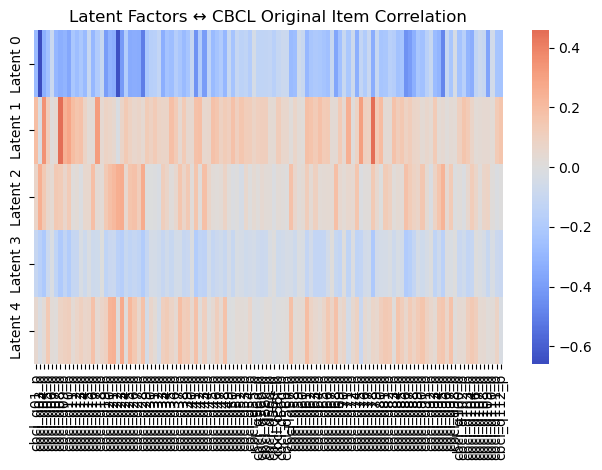

In [61]:
# Z: shape = (n_subjects, 5)
# cbcl_orig: shape = (n_subjects, 114)  # 原始 CBCL 题项或 syndromes
Z = y
cbcl_orig = qns
cbcl_orig = cbcl_orig[cbcl_orig['src_subject_id'].isin(y['src_subject_id'])]
Z = Z.iloc[:,1:]
cbcl_orig = cbcl_orig.iloc[:,1:]
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 计算相关矩阵
corr_mat = np.corrcoef(Z.T, cbcl_orig.T)[:5, 5:]  # shape: (5, 114)
cbcl_item_names = cbcl_orig.columns.tolist()

sns.heatmap(corr_mat, cmap="coolwarm", xticklabels=cbcl_item_names,
            yticklabels=[f"Latent {i}" for i in range(5)], center=0)
plt.title("Latent Factors ↔ CBCL Original Item Correlation")
plt.tight_layout()
plt.show()


In [62]:
X

src_subject_id  rsfmri_c_ngd_ad_ngd_ad  rsfmri_c_ngd_ad_ngd_cgc  \
0      NDAR_INV003RTV85                0.471330                 0.256267   
1      NDAR_INV005V6D2C                0.279435                 0.116256   
2      NDAR_INV007W6H7B                0.294463                 0.209772   
3      NDAR_INV00BD7VDC                0.241918                 0.163942   
4      NDAR_INV00CY2MDM                0.395300                 0.180940   
...                 ...                     ...                      ...   
11182  NDAR_INVZZLZCKAY                0.315367                 0.176642   
11183  NDAR_INVZZNX6W2P                0.343187                 0.142774   
11184  NDAR_INVZZPKBDAC                0.404070                 0.300714   
11185  NDAR_INVZZZ2ALR6                0.411105                 0.209193   
11186  NDAR_INVZZZNB0XC                0.270290                 0.147113   

       rsfmri_c_ngd_ad_ngd_ca  rsfmri_c_ngd_ad_ngd_dt  \
0                   -0.076960               -0.116451   
1                    0.063664               -0.024781   
2                   -0.071834               -0.138693   
3                   -0.090651               -0.044039   
4                   -0.142808               -0.073424   
...                       ...                     ...   
11182               -0.010926               -0.019208   
11183               -0.055901               -0.046064   
11184               -0.167735               -0.093816   
11185               -0.041473               -0.063504   
11186               -0.111270               -0.093982   

       rsfmri_c_ngd_ad_ngd_dla  rsfmri_c_ngd_ad_ngd_fo  rsfmri_c_ngd_ad_ngd_n  \
0                     0.022202               -0.036302              -0.057183   
1                    -0.000840               -0.023421              -0.016284   
2                    -0.035168                0.044412              -0.041321   
3                     0.012523               -0.022455              -0.005482   
4                    -0.049414               -0.144481              -0.024881   
...                        ...                     ...                    ...   
11182                -0.030765               -0.062264               0.021828   
11183                -0.006279                0.013171               0.017289   
11184                -0.044867                0.019305               0.049103   
11185                -0.102791               -0.046049              -0.009828   
11186                -0.005676               -0.083171              -0.018443   

       rsfmri_c_ngd_ad_ngd_rspltp  rsfmri_c_ngd_ad_ngd_sa  ...  \
0                       -0.048132                0.006416  ...   
1                        0.022696                0.056241  ...   
2                       -0.185939                0.071985  ...   
3                       -0.124627                0.095889  ...   
4                       -0.012894               -0.036592  ...   
...                           ...                     ...  ...   
11182                   -0.043990                0.140031  ...   
11183                   -0.064605               -0.014693  ...   
11184                   -0.157262                0.192685  ...   
11185                   -0.162120                0.026045  ...   
11186                   -0.074797                0.052438  ...   

       rsfmri_c_ngd_smh_ngd_smh  rsfmri_c_ngd_smh_ngd_smm  \
0                      0.314437                  0.056185   
1                      0.302632                  0.062337   
2                      0.288158                  0.088796   
3                      0.333995                  0.056474   
4                      0.426006                  0.380348   
...                         ...                       ...   
11182                  0.211188                  0.024467   
11183                  0.379075                  0.120344   
11184                  0.223616                 -0.033873   
11185                  0.302695    

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

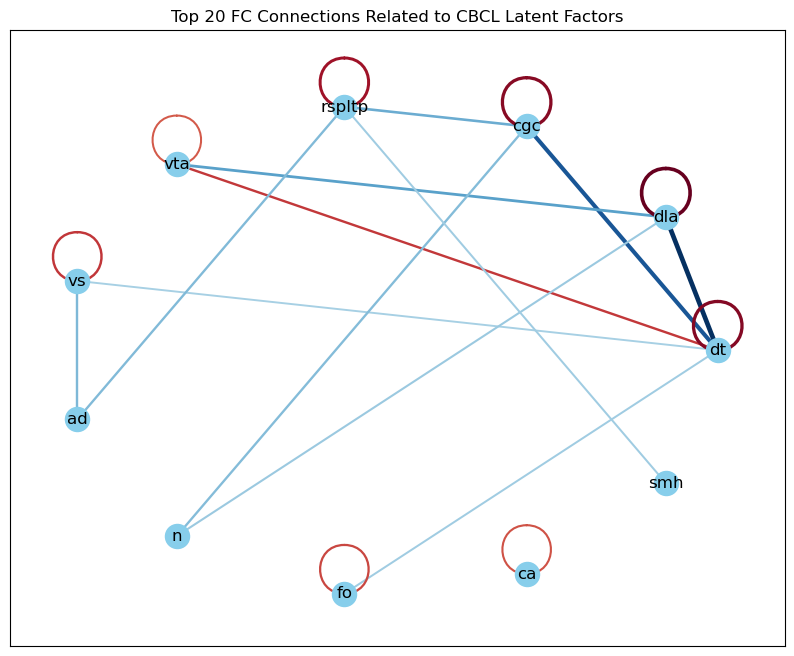

In [63]:
def extract_region_pair(column_name):
    """
    从列名中提取连接的两个脑区名
    示例输入：'rsfmri_c_ngd_ad_ngd_cgc'
    返回：('ad', 'cgc')
    """
    try:
        parts = column_name.split('_ngd_')
        return parts[-2], parts[-1]
    except:
        return ('UNKNOWN', 'UNKNOWN')
top_n = 20
top_fc_idx = np.argsort(np.abs(fc_mean))[::-1][:top_n]
top_fc_names = [fc_names[i] for i in top_fc_idx]
top_fc_values = fc_mean[top_fc_idx]

# 提取脑区对
region_pairs = [extract_region_pair(name) for name in top_fc_names]
region_1 = [p[0] for p in region_pairs]
region_2 = [p[1] for p in region_pairs]
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for r1, r2, w in zip(region_1, region_2, top_fc_values):
    G.add_edge(r1, r2, weight=w)

pos = nx.circular_layout(G)
weights = [np.abs(G[u][v]['weight']) * 8 for u, v in G.edges()]
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos, node_color='skyblue', with_labels=True,
                 width=weights, edge_color=edge_colors, edge_cmap=plt.cm.RdBu_r)
plt.title("Top 20 FC Connections Related to CBCL Latent Factors")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r), label='Canonical Loading')
plt.axis('off')
plt.tight_layout()
plt.show()


In [64]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_fc_network(region_pairs, weights, title="Top FC Loadings"):
    G = nx.Graph()

    for (r1, r2), w in zip(region_pairs, weights):
        G.add_edge(r1, r2, weight=w)

    pos = nx.circular_layout(G)

    edge_weights = [np.abs(G[u][v]['weight']) * 8 for u, v in G.edges()]
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]

    vmin, vmax = -max(np.abs(edge_colors)), max(np.abs(edge_colors))  # 对称颜色区间
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.RdBu_r

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
    nx.draw_networkx_labels(G, pos, font_size=12)
    nx.draw_networkx_edges(G, pos,
                           edge_color=edge_colors,
                           edge_cmap=cmap,
                           edge_vmin=vmin,
                           edge_vmax=vmax,
                           width=edge_weights)

    # 添加 colorbar 正确做法：
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # 需要设置空数据给 colorbar 用
    cbar = plt.colorbar(sm, shrink=0.6, pad=0.03)
    cbar.set_label("Canonical Loading")

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

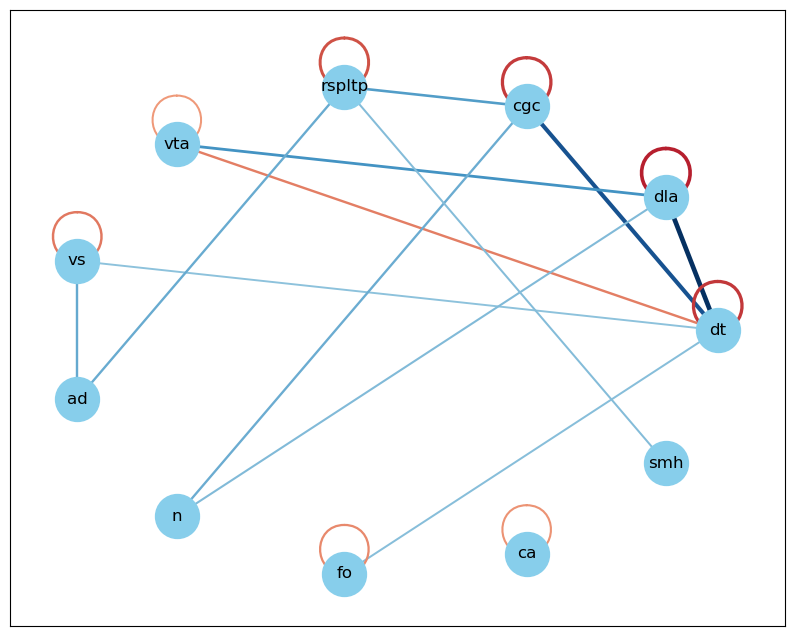

In [65]:
# 已经提取好了：
# region_pairs = [('ad', 'cgc'), ('ca', 'thalamus'), ...]
# top_fc_values = [0.65, -0.42, ...]

plot_fc_network(region_pairs, top_fc_values, title="Top 20 FC Connections Related to CBCL")


## Regression between FC and behavioral measures

In [42]:
X = pd.read_csv('../data/mri_y_rsfmr_cor_gp_gp_reduced.csv')
y = qns
X = X[X['src_subject_id'].isin(y['src_subject_id'])]
y = y[y['src_subject_id'].isin(X['src_subject_id'])]

In [43]:
latent_factors = pd.read_csv('../data/latent_factors.csv')
latent_factors = latent_factors[latent_factors['src_subject_id'].isin(X['src_subject_id'])]


In [44]:
X = X.iloc[:,1:]
y = y.iloc[:,1:]
latent_factors = latent_factors.iloc[:,1:]
X = X.values


In [45]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# 1. 标准化
X_fc = StandardScaler().fit_transform(X)  # shape: (n, 91)
Y_cbcl = StandardScaler().fit_transform(latent_factors)  # shape: (n, 5)

# 2. 做 CCA（取最小维度）
cca = CCA(n_components=5)
X_c, Y_c = cca.fit_transform(X_fc, Y_cbcl)

# 3. 计算 canonical correlations
import numpy as np
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(5)]

print("Canonical correlations:", canonical_corrs)


Canonical correlations: [0.2449281136536583, 0.17083575117825703, 0.14618244814807776, 0.1271388862983054, 0.0940447243645623]


In [48]:
n_permutations = 100
perm_corrs = []

for _ in range(n_permutations):
    permuted_Y = np.random.permutation(Y_cbcl)
    X_c_perm, Y_c_perm = cca.fit(X_fc, permuted_Y).transform(X_fc, permuted_Y)
    perm_corr = np.mean([np.corrcoef(X_c_perm[:, i], Y_c_perm[:, i])[0, 1] for i in range(5)])
    perm_corrs.append(perm_corr)

real_corr = np.mean(canonical_corrs)
p_val = np.mean(np.array(perm_corrs) > real_corr)

print(f"\n平均 canonical corr: {real_corr:.4f}")
print(f"p-value (permutation test): {p_val:.4f}")



平均 canonical corr: 0.1566
p-value (permutation test): 0.0000


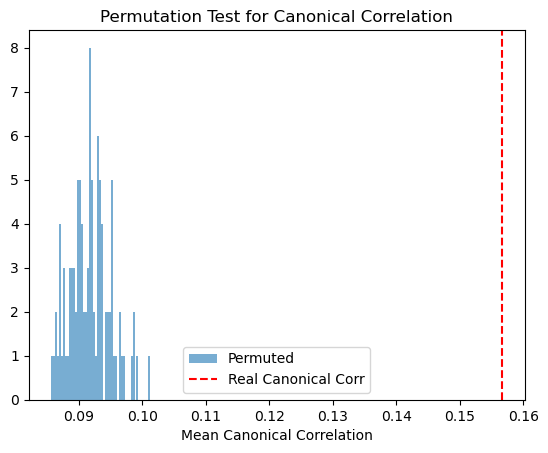

In [49]:
import matplotlib.pyplot as plt
plt.hist(perm_corrs, bins=50, alpha=0.6, label="Permuted")
plt.axvline(real_corr, color='red', linestyle='--', label="Real Canonical Corr")
plt.title("Permutation Test for Canonical Correlation")
plt.xlabel("Mean Canonical Correlation")
plt.legend()
plt.show()
